In [1]:
# !pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib

In [2]:
# from google.colab import auth

# PROJECT_ID = "ee-mlglobalhealth"  # @param {type:"string"}

# auth.authenticate_user(project_id=PROJECT_ID)

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# %cd gdrive/My Drive/'Oxford Thesis'/my_code/aggVAE_colab
# !ls

In [4]:
#import jax

# print("JAX backend:", jax.lib.xla_bridge.get_backend().platform)
# print("CUDA available:", jax.devices("gpu"))

In [5]:
# !pip install pip==24.0
# !pip install dill==0.3.8
# !pip install shapely==2.0.3
# !pip install geopandas==0.14.3
# !pip install arviz==0.18.0
# !pip install numpyro==0.14.0
# !pip install jax==0.4.25
# !pip install jaxlib==0.4.25

In [6]:
# !pip install -U "jax[cuda12]"

In [7]:
# ! pip install jax==0.4.30

In [8]:
# ! pip show jaxlib

In [9]:
# ! pip install wandb

In [10]:
# ! pip install numpyro==0.14.0

In [11]:
# ! pip show numpyro

In [12]:
# ! pip install --upgrade shapely


In [13]:
# general libraries
import time
import math
import numpy as np
from shapely import geometry
from shapely.geometry import Polygon, Point
import matplotlib
import matplotlib.pyplot as plt
import pickle
import os
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
# import dill
import geopandas
import geopandas as gpd
import matplotlib.colors as colors
import wandb
from typing import Optional, Union
from pathlib import Path
import orbax.checkpoint
import dill
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error, mean_absolute_error



# JAX
import jax
import jax.numpy as jnp

# jax.config.update('jax_platform_name', 'gpu')  # Use GPU

from jax import random, lax, jit, ops
from jax.example_libraries import stax
# previously was "from jax.experimental import stax" due to previous versions of jax



# Numpyro
import numpyro
from numpyro.infer import SVI, MCMC, NUTS, init_to_median, Predictive, RenyiELBO
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from numpyro import optim

print(jax.__version__)
print(numpyro.__version__)

0.4.30
0.14.0


## Read shape files

In [14]:
shape_new = gpd.read_file('data/Shapefiles/zmb_admbnda_adm1_dmmu_20201124.shp')
shape_new = shape_new[['ADM1_EN', 'geometry']]
shape_new['new'] = 1
shape_new.head(2)

ADM1_EN                                           geometry  new
0     Central  POLYGON ((29.99949 -12.00267, 30.00002 -12.002...    1
1  Copperbelt  POLYGON ((27.94644 -12.28198, 27.95514 -12.297...    1

In [15]:
shape_old = gpd.read_file('data/Shapefiles/zmb_admbnda_adm2_dmmu_20201124.shp')
shape_old = shape_old[['ADM2_EN', 'geometry']]
shape_old['new'] = 0
shape_old.head(2)

ADM2_EN                                           geometry  new
0  Chibombo  POLYGON ((28.00409 -14.51361, 28.00989 -14.514...    0
1  Chisamba  POLYGON ((28.65022 -14.38920, 28.65131 -14.389...    0

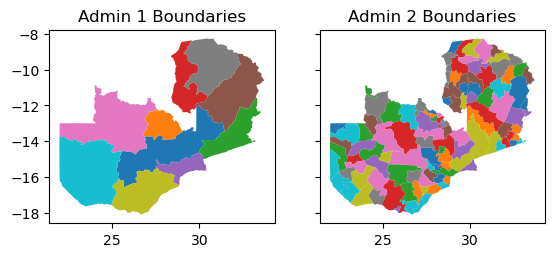

In [16]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True)
shape_new.plot(ax=ax1, column='ADM1_EN')
shape_old.plot(ax=ax2, column='ADM2_EN')
ax1.set_title('Admin 1 Boundaries')
ax2.set_title('Admin 2 Boundaries')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig('figures/boundaries_all_admins.pdf')

<Axes: >

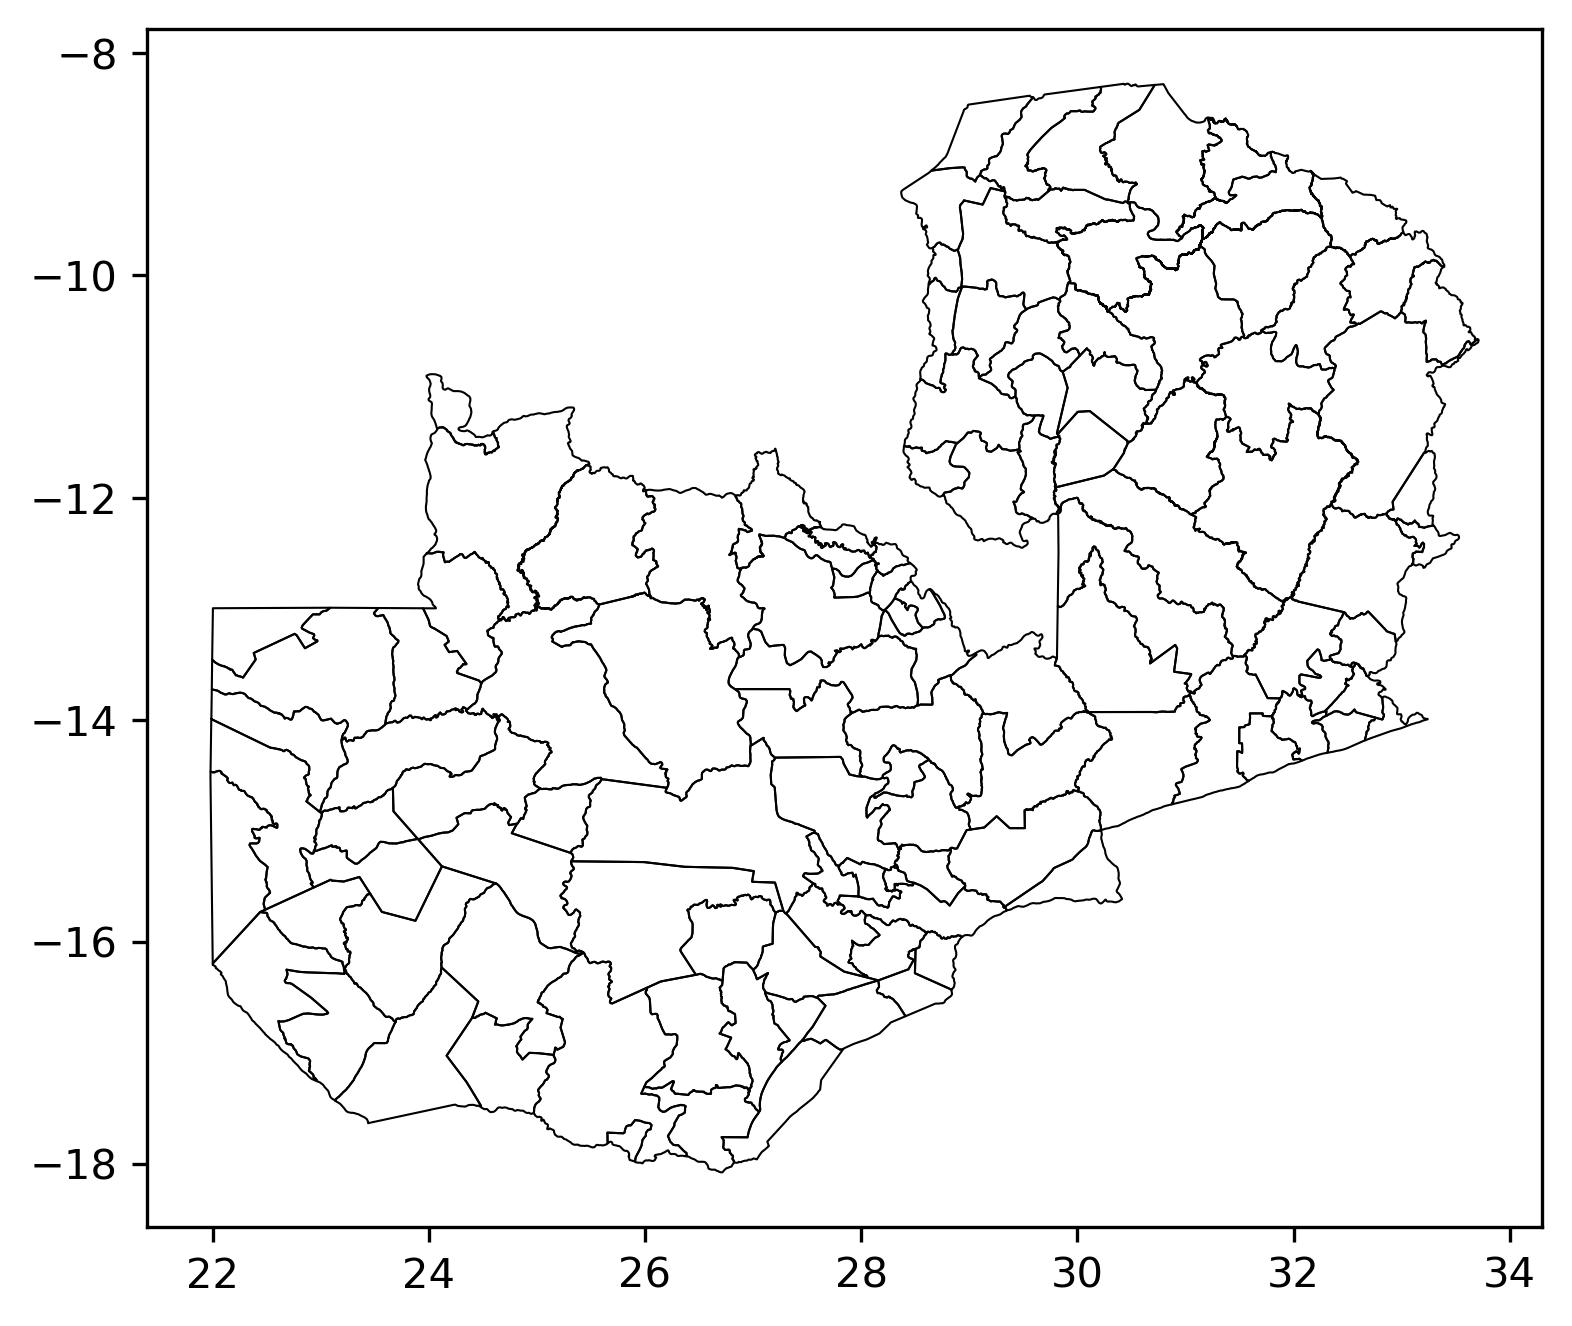

In [17]:
shape_old.boundary.plot(linewidth=0.5,  edgecolor='black', figsize=(6,6))
#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/boundaries_before2010.pdf')

<Axes: >

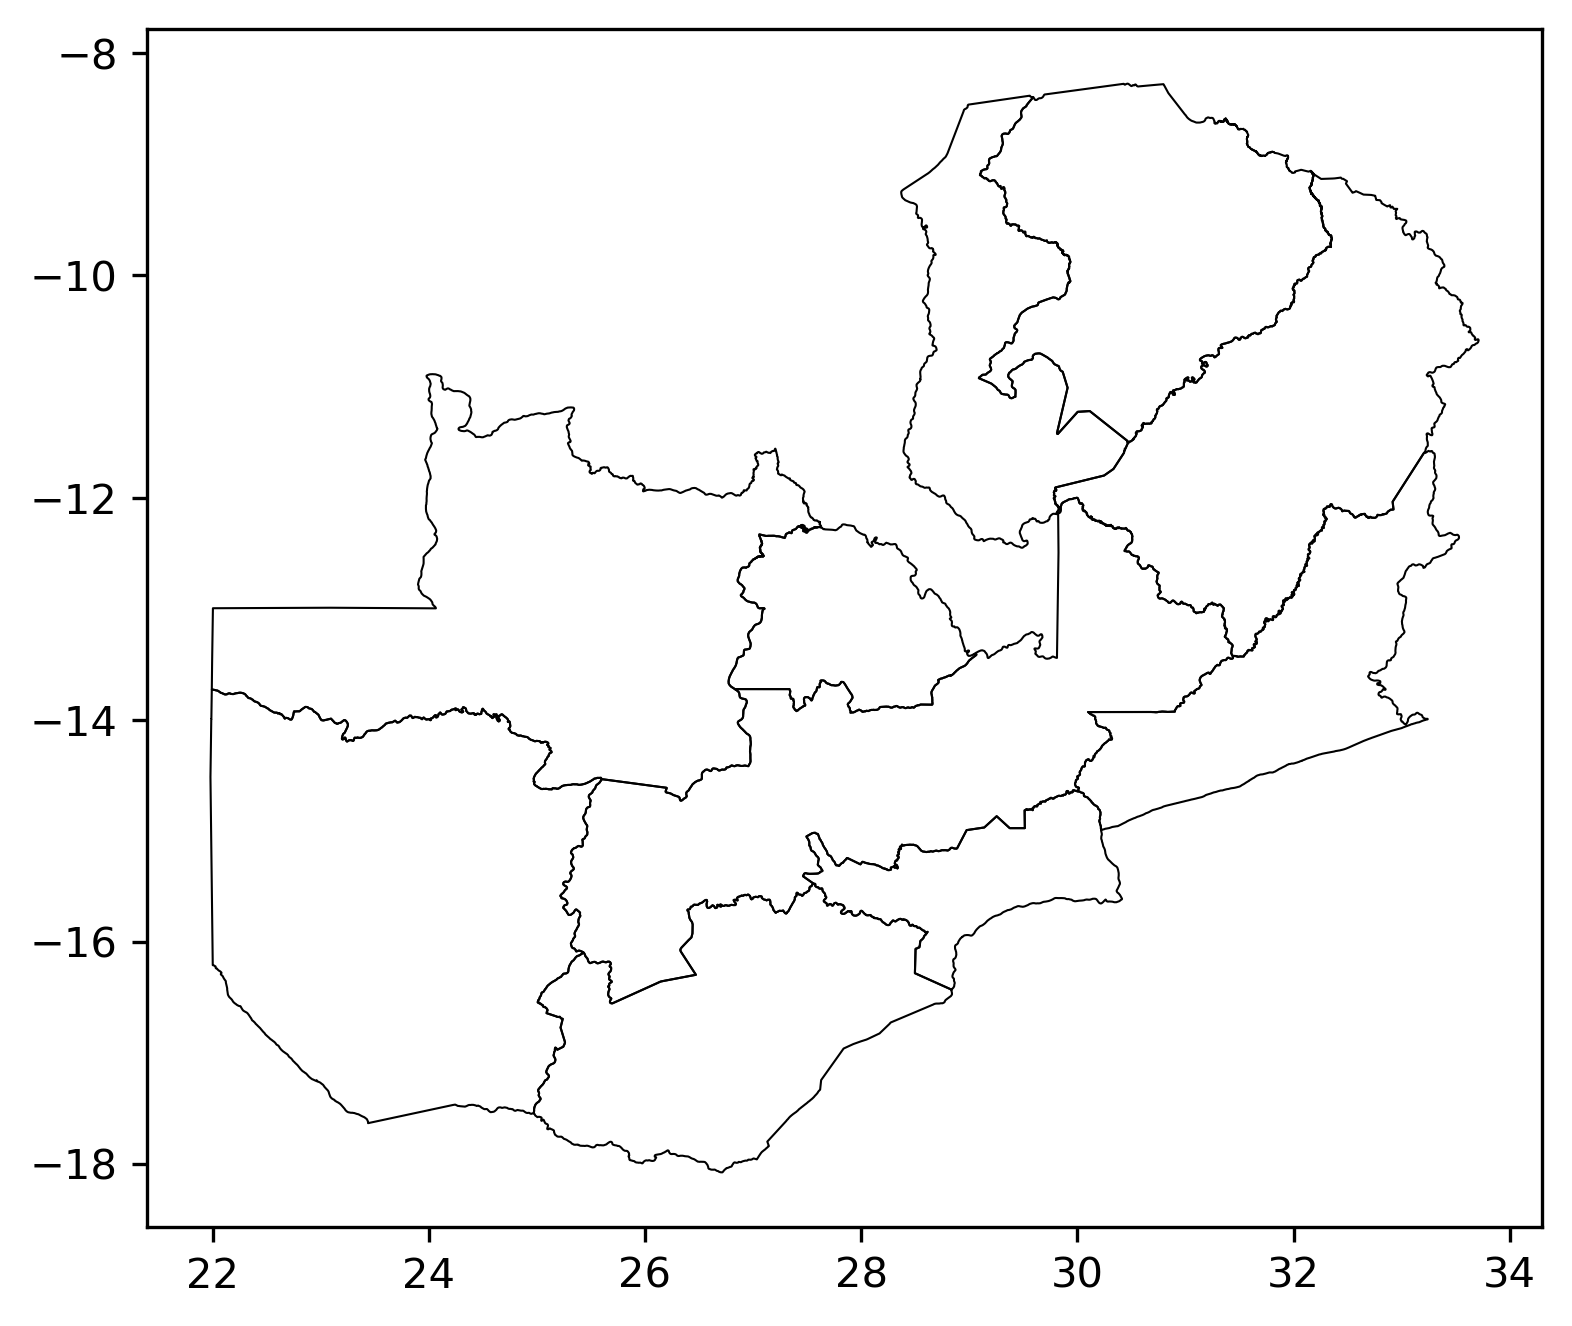

In [18]:
shape_new.boundary.plot(linewidth=0.5,  edgecolor='black', figsize=(6,6))
#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/boundaries_after2010.pdf')

In [19]:
# capitalise unit names
names_shape_new = shape_new['ADM1_EN'].values
shape_new['ADM1_EN'] =  np.array([names_shape_new[i].upper() for i in range(len(names_shape_new))])
shape_new.head(5)

ADM1_EN                                           geometry  new
0     CENTRAL  POLYGON ((29.99949 -12.00267, 30.00002 -12.002...    1
1  COPPERBELT  POLYGON ((27.94644 -12.28198, 27.95514 -12.297...    1
2     EASTERN  POLYGON ((33.25764 -11.58238, 33.26164 -11.585...    1
3     LUAPULA  POLYGON ((29.37374 -8.70908, 29.36164 -8.72298...    1
4      LUSAKA  POLYGON ((29.98254 -14.64278, 29.98494 -14.643...    1

In [20]:
names_shape_new = shape_new['ADM1_EN'].values
names_shape_new

array(['CENTRAL', 'COPPERBELT', 'EASTERN', 'LUAPULA', 'LUSAKA',
       'MUCHINGA', 'NORTH-WESTERN', 'NORTHERN', 'SOUTHERN', 'WESTERN'],
      dtype=object)

In [21]:
# capitalise unit names
names_shape_old = shape_old['ADM2_EN'].values
shape_old['ADM2_EN'] =  np.array([names_shape_old[i].upper() for i in range(len(names_shape_old))])
shape_old.head(5)

ADM2_EN                                           geometry  new
0      CHIBOMBO  POLYGON ((28.00409 -14.51361, 28.00989 -14.514...    0
1      CHISAMBA  POLYGON ((28.65022 -14.38920, 28.65131 -14.389...    0
2      CHITAMBO  POLYGON ((29.99949 -12.00267, 30.00002 -12.002...    0
3  ITEZHI-TEZHI  POLYGON ((26.99044 -15.46178, 27.20284 -15.468...    0
4         KABWE  POLYGON ((28.33593 -14.26089, 28.33684 -14.262...    0

In [22]:
names_shape_old = shape_old['ADM2_EN'].values
names_shape_old

array(['CHIBOMBO', 'CHISAMBA', 'CHITAMBO', 'ITEZHI-TEZHI', 'KABWE',
       'LUANO', 'MKUSHI', 'MUMBWA', 'NGABWE', 'SERENJE', 'CHILILABOMBWE',
       'CHINGOLA', 'KALULUSHI', 'KITWE', 'LUANSHYA', 'LUFWANYAMA',
       'MASAITI', 'MPONGWE', 'MUFULIRA', 'NDOLA', 'CHADIZA', 'CHASEFU',
       'CHIPANGALI', 'CHIPATA', 'KASENENGWA', 'KATETE', 'LUMEZI',
       'LUNDAZI', 'MAMBWE', 'NYIMBA', 'PETAUKE', 'SINDA', 'VUBWI',
       'CHEMBE', 'CHIENGI', 'CHIFUNABULI', 'CHIPILI', 'KAWAMBWA', 'LUNGA',
       'MANSA', 'MILENGI', 'MWANSABOMBWE', 'MWENSE', 'SAMFYA', 'CHILANGA',
       'CHIRUNDU', 'CHONGWE', 'KAFUE', 'LUANGWA', 'LUSAKA', 'RUFUNSA',
       'SHIBUYUNJI', 'CHAMA', 'CHINSALI', 'ISOKA', 'KANCHIBIYA',
       'LAVUSHIMANDA', 'MAFINGA', 'MPIKA', 'NAKONDE', 'CHAVUMA',
       'IKELENGE', 'KABOMPO', 'KALUMBILA', 'KASEMPA', 'MANYINGA',
       'MUFUMBWE', 'MUSHINDANO', 'MWINILUNGA', 'SOLWEZI', 'ZAMBEZI',
       'CHILUBI', 'KAPUTA', 'KASAMA', 'LUNTE DISTRICT', 'LUPOSOSHI',
       'LUWINGU', 'MBALA', 'MPU

# Malaria data

In [23]:
infections_new = pd.read_csv("../../data/dhs/ZMB_prev_data_admin1.csv")
infections_new = infections_new[['unit', 'usage', 'num_rdt', 'num_rdt_positive', 'prev_estimate']]
infections_new = infections_new.rename({'unit': 'area'}, axis='columns')
infections_new = infections_new.sort_values(by=['area'])
infections_new.head(5)

area     usage      num_rdt  num_rdt_positive  prev_estimate
3     Central  0.379661  2073.082241        105.938283       0.051102
1  Copperbelt  0.444083  3490.462209        420.221728       0.120391
0     Eastern  0.547537  3013.083502        194.763008       0.064639
6     Luapula  0.614999  1627.434474         89.950700       0.055271
9      Lusaka  0.222109  4881.258989        628.867127       0.128833

In [24]:
infections_old = pd.read_csv("../../data/dhs/ZMB_prev_data_admin2.csv")
infections_old.head(2)

Unnamed: 0     unit  year     usage     num_rdt  num_rdt_positive  \
0           1  Chadiza  2018  0.592593   43.522101          2.352546   
1           2    Chama  2018  0.656690  219.745559         13.109616   

   prev_estimate  
0       0.054054  
1       0.059658

In [25]:
infections_old = infections_old[['unit', 'usage', 'num_rdt', 'num_rdt_positive', 'prev_estimate']]
infections_old = infections_old.rename({'unit': 'area'}, axis='columns')
infections_old = infections_old.sort_values(by=['area'])
infections_old.head(2)

area     usage     num_rdt  num_rdt_positive  prev_estimate
0  Chadiza  0.592593   43.522101          2.352546       0.054054
1    Chama  0.656690  219.745559         13.109616       0.059658

## Merge infections and shape

### Admin 1

In [26]:
names_infections_new = infections_new.area.values
shape_new = shape_new.rename({'ADM1_EN': 'area'}, axis='columns')
shape_new = shape_new.sort_values(by=['area'])
shape_new.head(3)
names_shape_new = shape_new['area'].values
print(names_infections_new)
print(names_shape_new)

['Central' 'Copperbelt' 'Eastern' 'Luapula' 'Lusaka' 'Muchinga'
 'North Western' 'Northern' 'Southern' 'Western']
['CENTRAL' 'COPPERBELT' 'EASTERN' 'LUAPULA' 'LUSAKA' 'MUCHINGA'
 'NORTH-WESTERN' 'NORTHERN' 'SOUTHERN' 'WESTERN']


In [27]:
names_infections_new[6] = 'North-Western'
# convert to uppercase
names_infections_new = [names_infections_new[i].upper() for i in range(len(names_infections_new))]
print(names_infections_new)
print(names_shape_new)

['CENTRAL', 'COPPERBELT', 'EASTERN', 'LUAPULA', 'LUSAKA', 'MUCHINGA', 'NORTH-WESTERN', 'NORTHERN', 'SOUTHERN', 'WESTERN']
['CENTRAL' 'COPPERBELT' 'EASTERN' 'LUAPULA' 'LUSAKA' 'MUCHINGA'
 'NORTH-WESTERN' 'NORTHERN' 'SOUTHERN' 'WESTERN']


In [28]:
names_shape_new_lst = list(names_shape_new)
lst = [names_shape_new_lst[i] not in names_infections_new for i in range(len(names_shape_new))]
[i for i in range(len(lst)) if lst[i] == True]

[]

In [29]:
shape_new['area'] =  names_shape_new
infections_new.area = names_infections_new

In [30]:
infections_new

area     usage      num_rdt  num_rdt_positive  prev_estimate
3        CENTRAL  0.379661  2073.082241        105.938283       0.051102
1     COPPERBELT  0.444083  3490.462209        420.221728       0.120391
0        EASTERN  0.547537  3013.083502        194.763008       0.064639
6        LUAPULA  0.614999  1627.434474         89.950700       0.055271
9         LUSAKA  0.222109  4881.258989        628.867127       0.128833
4       MUCHINGA  0.570684  1436.135923         67.596165       0.047068
8  NORTH-WESTERN  0.482494  1291.284642         60.660640       0.046977
2       NORTHERN  0.592238  1992.388614        107.870632       0.054141
5       SOUTHERN  0.429838  2850.930546        345.899545       0.121329
7        WESTERN  0.527002  1328.493995        129.634803       0.097580

In [31]:
shape_new

area                                           geometry  new
0        CENTRAL  POLYGON ((29.99949 -12.00267, 30.00002 -12.002...    1
1     COPPERBELT  POLYGON ((27.94644 -12.28198, 27.95514 -12.297...    1
2        EASTERN  POLYGON ((33.25764 -11.58238, 33.26164 -11.585...    1
3        LUAPULA  POLYGON ((29.37374 -8.70908, 29.36164 -8.72298...    1
4         LUSAKA  POLYGON ((29.98254 -14.64278, 29.98494 -14.643...    1
5       MUCHINGA  POLYGON ((32.16182 -9.05766, 32.19187 -9.09042...    1
6  NORTH-WESTERN  POLYGON ((24.15075 -11.02947, 24.15078 -11.029...    1
7       NORTHERN  POLYGON ((30.48184 -8.28098, 30.48544 -8.28408...    1
8       SOUTHERN  POLYGON ((27.61591 -15.52350, 27.61987 -15.524...    1
9        WESTERN  POLYGON ((22.03129 -13.73621, 22.03666 -13.738...    1

In [32]:
shape_new = shape_new.merge(infections_new, how='left', left_on='area', right_on='area')
shape_new.head(3)

area                                           geometry  new  \
0     CENTRAL  POLYGON ((29.99949 -12.00267, 30.00002 -12.002...    1   
1  COPPERBELT  POLYGON ((27.94644 -12.28198, 27.95514 -12.297...    1   
2     EASTERN  POLYGON ((33.25764 -11.58238, 33.26164 -11.585...    1   

      usage      num_rdt  num_rdt_positive  prev_estimate  
0  0.379661  2073.082241        105.938283       0.051102  
1  0.444083  3490.462209        420.221728       0.120391  
2  0.547537  3013.083502        194.763008       0.064639

In [33]:
np.sum(np.isnan(shape_new.num_rdt))

0

In [34]:
s_new = shape_new.rename({'num_rdt': 'n_obs', 'num_rdt_positive': 'y', 'prev_estimate': 'estimate'}, axis='columns')
s_new['y'] = round(s_new['y']).astype(int)
s_new['n_obs'] = round(s_new['n_obs']).astype(int)
s_new.head(3)

area                                           geometry  new  \
0     CENTRAL  POLYGON ((29.99949 -12.00267, 30.00002 -12.002...    1   
1  COPPERBELT  POLYGON ((27.94644 -12.28198, 27.95514 -12.297...    1   
2     EASTERN  POLYGON ((33.25764 -11.58238, 33.26164 -11.585...    1   

      usage  n_obs    y  estimate  
0  0.379661   2073  106  0.051102  
1  0.444083   3490  420  0.120391  
2  0.547537   3013  195  0.064639

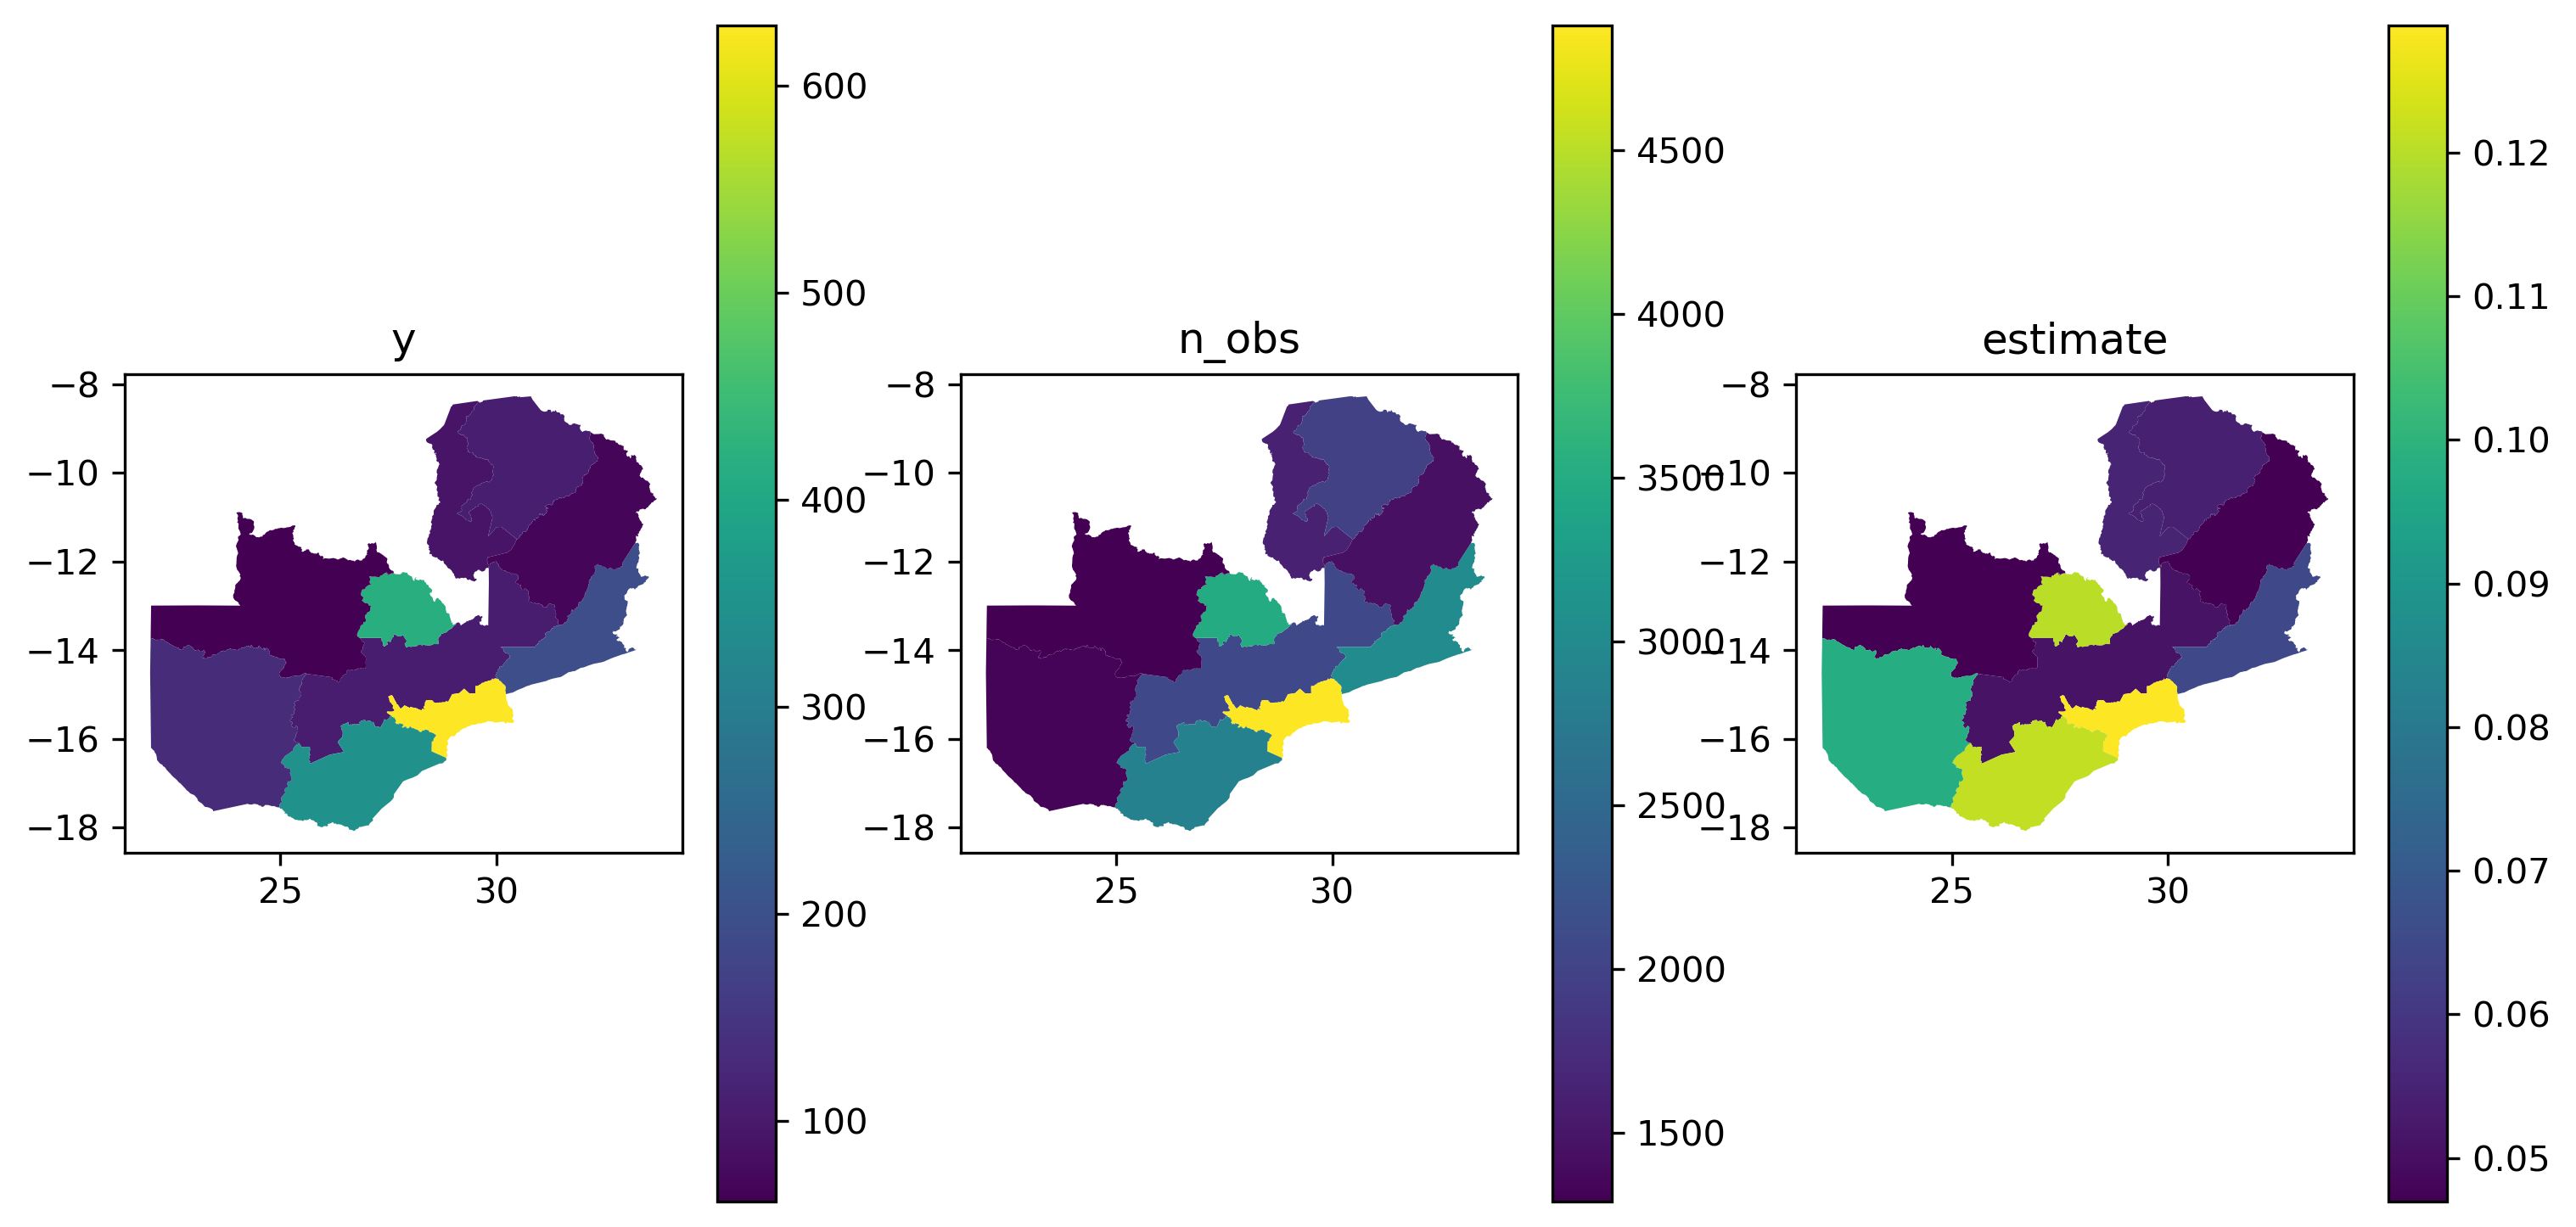

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(12,6))
s_new.plot(column="y", ax=ax[0], legend=True)
s_new.plot(column="n_obs", ax=ax[1], legend=True)
s_new.plot(column="estimate", ax=ax[2], legend=True)
ax[0].set_title('y')
ax[1].set_title('n_obs')
ax[2].set_title('estimate')

# Save
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig('figures/ZMB2018_adm1_observations.pdf')

In [36]:
del shape_new
del infections_new

### Admin 2

In [37]:
# Create new rows with zero values
new_rows = pd.DataFrame({'area': ['CHIRUNDU', 'ITEZHI-TEZHI', 'SHIBUYUNJI'],
                             'usage': [0.0, 0.0, 0.0],
                             'num_rdt': [0.0, 0.0, 0.0],
                             'num_rdt_positive': [0.0, 0.0, 0.0],
                             'prev_estimate': [0.0, 0.0, 0.0]})

# Append new rows to infections_new
infections_old = pd.concat([infections_old, new_rows])

In [38]:
names_infections_old = infections_old.area.values
names_infections_old

array(['Chadiza', 'Chama', 'Chasefu', 'Chavuma', 'Chembe', 'Chibombo',
       'Chiengi', 'Chifunabuli', 'Chikankanta', 'Chilanga',
       'Chililabombwe', 'Chilubi', 'Chingola', 'Chinsali', 'Chipangali',
       'Chipata', 'Chipili', 'Chisamba', 'Chitambo', 'Choma', 'Chongwe',
       'Gwembe', 'Ikelenge', 'Isoka', 'Kabompo', 'Kabwe', 'Kafue',
       'Kalabo', 'Kalomo', 'Kalulushi', 'Kalumbila', 'Kanchibiya',
       'Kaoma', 'Kapiri Mposhi', 'Kaputa', 'Kasama', 'Kasempa',
       'Kasenengwa', 'Katete', 'Kawambwa', 'Kazungula', 'Kitwe',
       'Lavushimanda', 'Limulunga', 'Livingstone', 'Luampa', 'Luangwa',
       'Luano', 'Luanshya', 'Lufwanyama', 'Lukulu', 'Lumezi', 'Lundazi',
       'Lunga', 'Lunte District', 'Lupososhi', 'Lusaka', 'Luwingu',
       'Mafinga', 'Mambwe', 'Mansa', 'Manyinga', 'Masaiti', 'Mazabuka',
       'Mbala', 'Milengi', 'Mitete', 'Mkushi', 'Mongu', 'Monze', 'Mpika',
       'Mpongwe', 'Mporokoso', 'Mpulungu', 'Mufulira', 'Mufumbwe',
       'Mulobezi', 'Mumbwa', 'Mung

In [39]:
shape_old = shape_old.rename({'ADM2_EN': 'area'}, axis='columns')
shape_old = shape_old.sort_values(by=['area'])
shape_old.head(3)

area                                           geometry  new
20  CHADIZA  POLYGON ((32.57804 -13.93448, 32.75563 -13.982...    0
52    CHAMA  POLYGON ((32.84411 -10.34120, 32.84790 -10.341...    0
21  CHASEFU  POLYGON ((32.94614 -12.21183, 32.94578 -12.211...    0

In [40]:
names_shape_old = shape_old['area'].values
names_shape_old

array(['CHADIZA', 'CHAMA', 'CHASEFU', 'CHAVUMA', 'CHEMBE', 'CHIBOMBO',
       'CHIENGI', 'CHIFUNABULI', 'CHIKANKANTA', 'CHILANGA',
       'CHILILABOMBWE', 'CHILUBI', 'CHINGOLA', 'CHINSALI', 'CHIPANGALI',
       'CHIPATA', 'CHIPILI', 'CHIRUNDU', 'CHISAMBA', 'CHITAMBO', 'CHOMA',
       'CHONGWE', 'GWEMBE', 'IKELENGE', 'ISOKA', 'ITEZHI-TEZHI',
       'KABOMPO', 'KABWE', 'KAFUE', 'KALABO', 'KALOMO', 'KALULUSHI',
       'KALUMBILA', 'KANCHIBIYA', 'KAOMA', 'KAPIRI MPOSHI', 'KAPUTA',
       'KASAMA', 'KASEMPA', 'KASENENGWA', 'KATETE', 'KAWAMBWA',
       'KAZUNGULA', 'KITWE', 'LAVUSHIMANDA', 'LIMULUNGA', 'LIVINGSTONE',
       'LUAMPA', 'LUANGWA', 'LUANO', 'LUANSHYA', 'LUFWANYAMA', 'LUKULU',
       'LUMEZI', 'LUNDAZI', 'LUNGA', 'LUNTE DISTRICT', 'LUPOSOSHI',
       'LUSAKA', 'LUWINGU', 'MAFINGA', 'MAMBWE', 'MANSA', 'MANYINGA',
       'MASAITI', 'MAZABUKA', 'MBALA', 'MILENGI', 'MITETE', 'MKUSHI',
       'MONGU', 'MONZE', 'MPIKA', 'MPONGWE', 'MPOROKOSO', 'MPULUNGU',
       'MUFULIRA', 'MUFUMBWE',

In [41]:
# convert to uppercase
names_infections_old = [names_infections_old[i].upper() for i in range(len(names_infections_old))]
print(names_infections_old)
print(names_shape_old)

['CHADIZA', 'CHAMA', 'CHASEFU', 'CHAVUMA', 'CHEMBE', 'CHIBOMBO', 'CHIENGI', 'CHIFUNABULI', 'CHIKANKANTA', 'CHILANGA', 'CHILILABOMBWE', 'CHILUBI', 'CHINGOLA', 'CHINSALI', 'CHIPANGALI', 'CHIPATA', 'CHIPILI', 'CHISAMBA', 'CHITAMBO', 'CHOMA', 'CHONGWE', 'GWEMBE', 'IKELENGE', 'ISOKA', 'KABOMPO', 'KABWE', 'KAFUE', 'KALABO', 'KALOMO', 'KALULUSHI', 'KALUMBILA', 'KANCHIBIYA', 'KAOMA', 'KAPIRI MPOSHI', 'KAPUTA', 'KASAMA', 'KASEMPA', 'KASENENGWA', 'KATETE', 'KAWAMBWA', 'KAZUNGULA', 'KITWE', 'LAVUSHIMANDA', 'LIMULUNGA', 'LIVINGSTONE', 'LUAMPA', 'LUANGWA', 'LUANO', 'LUANSHYA', 'LUFWANYAMA', 'LUKULU', 'LUMEZI', 'LUNDAZI', 'LUNGA', 'LUNTE DISTRICT', 'LUPOSOSHI', 'LUSAKA', 'LUWINGU', 'MAFINGA', 'MAMBWE', 'MANSA', 'MANYINGA', 'MASAITI', 'MAZABUKA', 'MBALA', 'MILENGI', 'MITETE', 'MKUSHI', 'MONGU', 'MONZE', 'MPIKA', 'MPONGWE', 'MPOROKOSO', 'MPULUNGU', 'MUFULIRA', 'MUFUMBWE', 'MULOBEZI', 'MUMBWA', 'MUNGWI', 'MUSHINDANO', 'MWANDI', 'MWANSABOMBWE', 'MWENSE', 'MWINILUNGA', 'NAKONDE', 'NALOLO', 'NAMWALA', 'NC

In [42]:
names_shape_old_lst = list(names_shape_old)
lst = [names_shape_old_lst[i] not in names_infections_old for i in range(len(names_shape_old))]
[i for i in range(len(lst)) if lst[i] == True]

[]

In [43]:
shape_old['area'] =  names_shape_old
infections_old.area = names_infections_old

In [44]:
shape_old = shape_old.merge(infections_old, how='left', left_on='area', right_on='area')
shape_old.head(3)

area                                           geometry  new     usage  \
0  CHADIZA  POLYGON ((32.57804 -13.93448, 32.75563 -13.982...    0  0.592593   
1    CHAMA  POLYGON ((32.84411 -10.34120, 32.84790 -10.341...    0  0.656690   
2  CHASEFU  POLYGON ((32.94614 -12.21183, 32.94578 -12.211...    0  0.491268   

      num_rdt  num_rdt_positive  prev_estimate  
0   43.522101          2.352546       0.054054  
1  219.745559         13.109616       0.059658  
2  157.033307          2.872475       0.018292

In [45]:
print(np.sum(np.isnan(shape_old.num_rdt)))
print(np.sum(np.isnan(shape_old.num_rdt_positive)))

0
0


In [46]:
s_old = shape_old.rename({'num_rdt': 'n_obs', 'num_rdt_positive': 'y', 'prev_estimate': 'estimate'}, axis='columns')
s_old['y'] = round(s_old['y']).astype(int)
s_old['n_obs'] = round(s_old['n_obs']).astype(int)
s_old.head(3)

area                                           geometry  new     usage  \
0  CHADIZA  POLYGON ((32.57804 -13.93448, 32.75563 -13.982...    0  0.592593   
1    CHAMA  POLYGON ((32.84411 -10.34120, 32.84790 -10.341...    0  0.656690   
2  CHASEFU  POLYGON ((32.94614 -12.21183, 32.94578 -12.211...    0  0.491268   

   n_obs   y  estimate  
0     44   2  0.054054  
1    220  13  0.059658  
2    157   3  0.018292

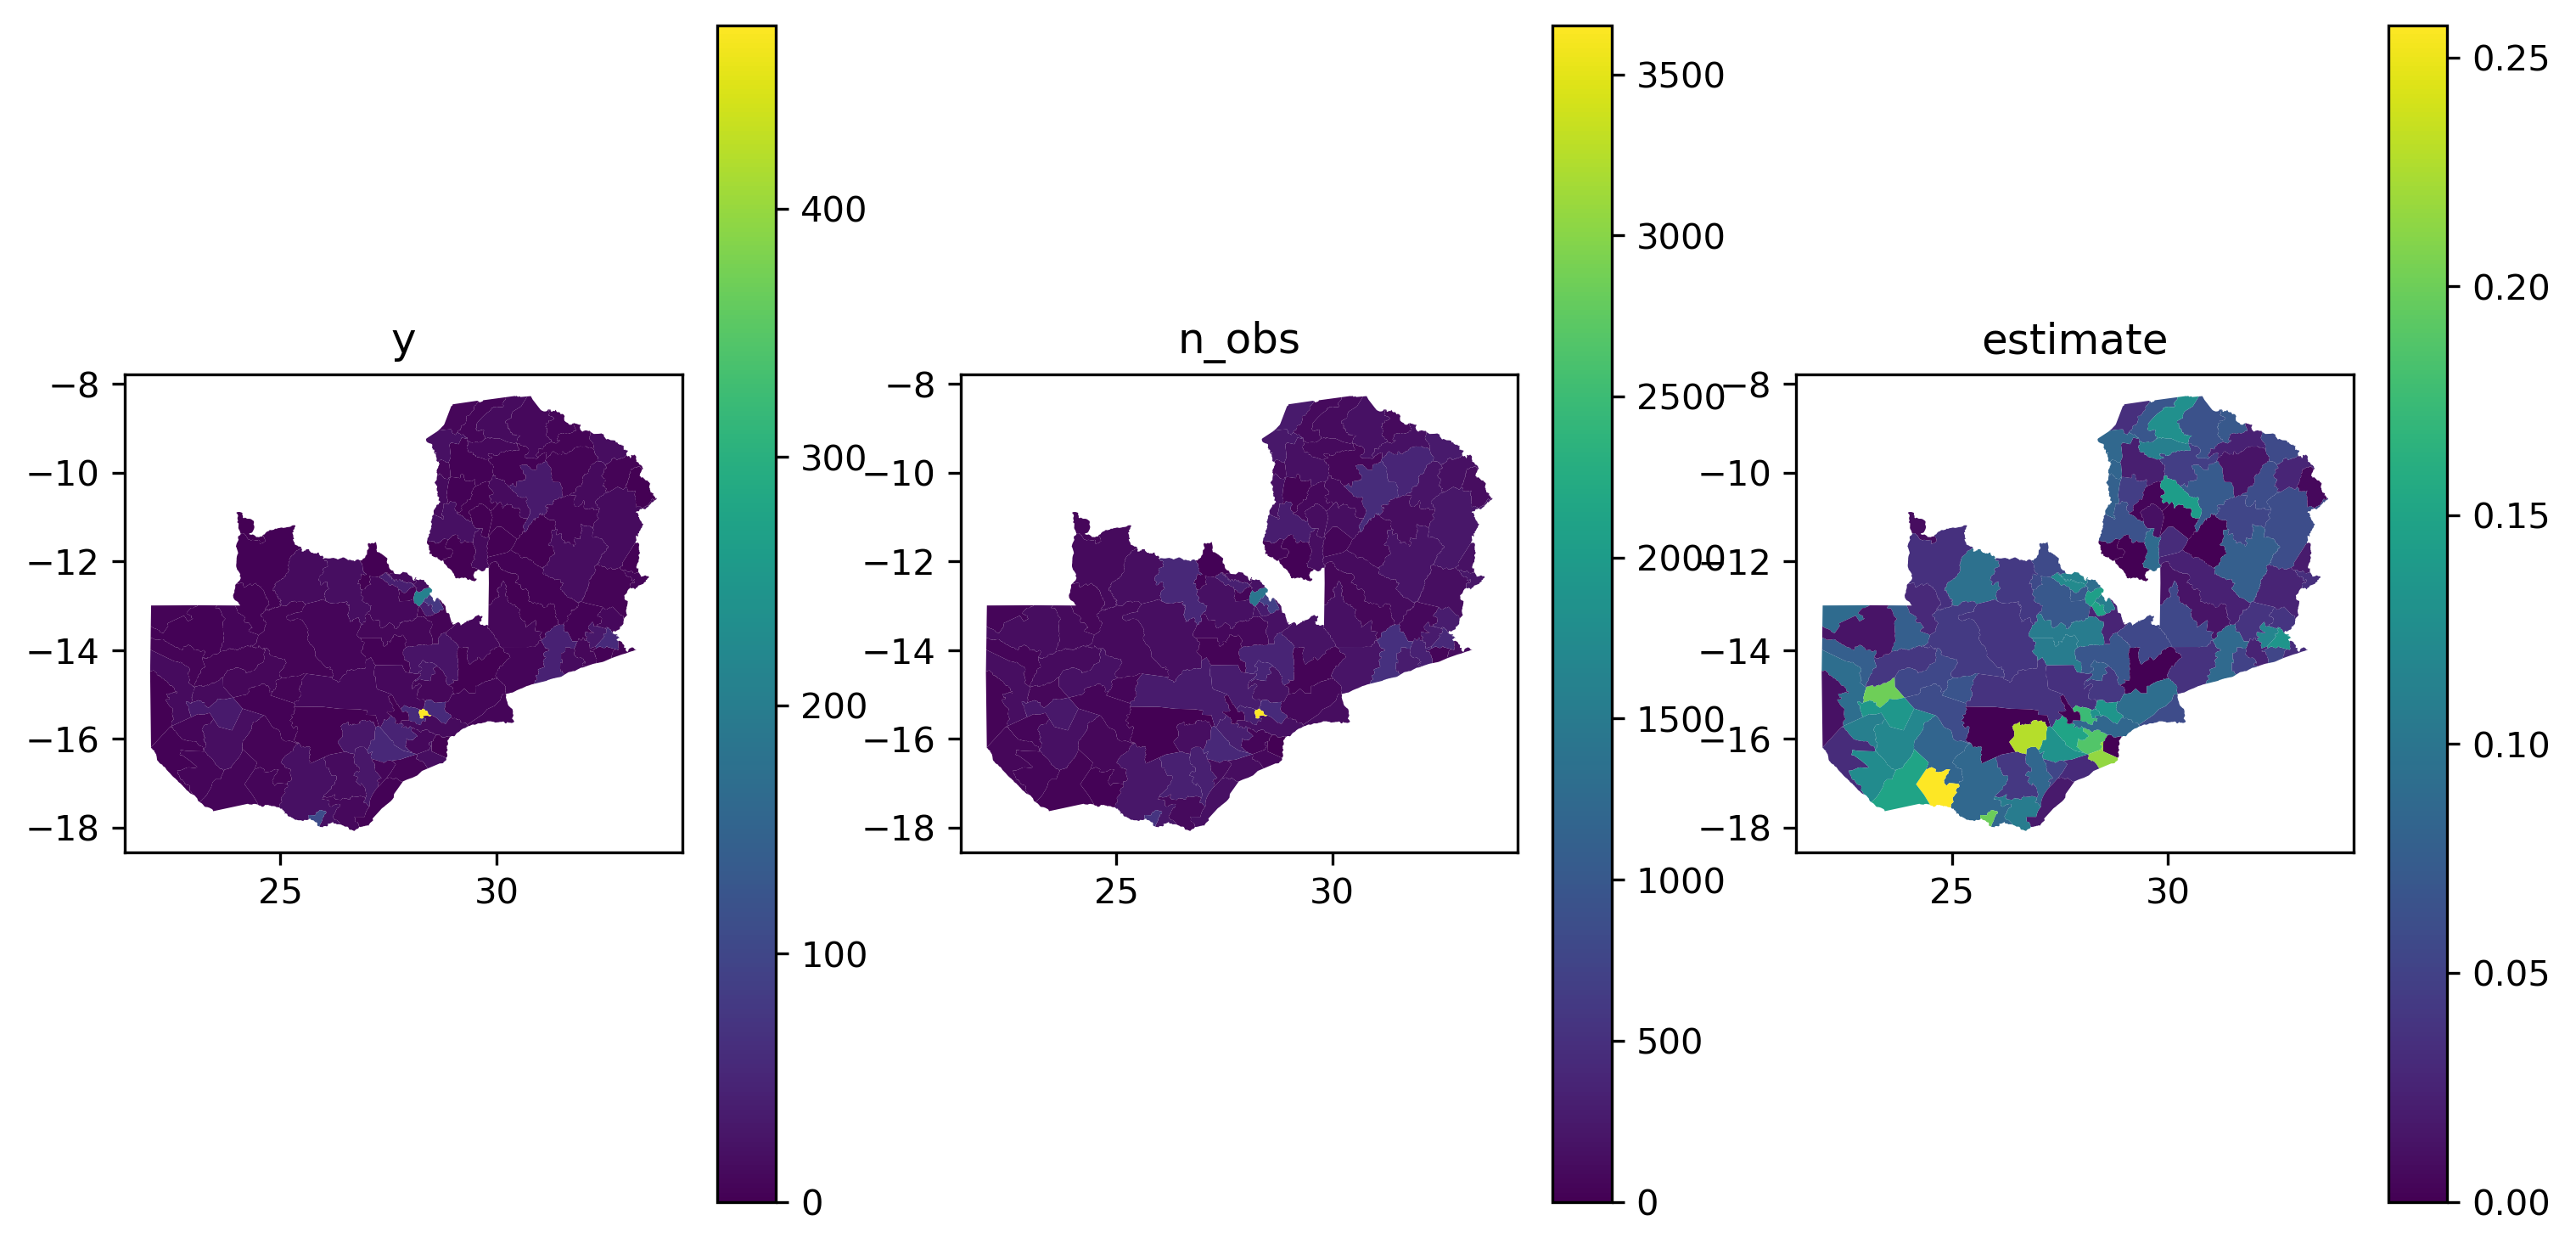

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(12,6))
s_old.plot(column="y", ax=ax[0], legend=True)
s_old.plot(column="n_obs", ax=ax[1], legend=True)
s_old.plot(column="estimate", ax=ax[2], legend=True)
ax[0].set_title( 'y')
ax[1].set_title( 'n_obs')
ax[2].set_title( 'estimate')

# Save
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig('figures/ZMB2018_adm2_observations.pdf')

In [48]:
del shape_old
del infections_old

## Computational grid

In [49]:
x_min, x_max, y_min, y_max = 21.5, 34, -19, -8
dy = y_max - y_min
dx = x_max - x_min
factor = dy / dx
n_x = 40
n_y = math.ceil(n_x * factor)
print(n_x)
print(n_y)
print(n_x * n_y)

x_grid = np.linspace(x_min, x_max, n_x, endpoint=True)
y_grid = np.linspace(y_min, y_max, n_y, endpoint=True)

# full coordinate arrays
x_coords, y_coords = np.meshgrid(x_grid, y_grid)
x_coords = x_coords.reshape(-1)
y_coords = y_coords.reshape(-1)

df = pd.DataFrame({'Latitude': y_coords, 'Longitude': x_coords})

grid_pts = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.Longitude, df.Latitude))

x = jnp.array([x_coords, y_coords]).transpose((1, 0))
print(x.shape)

40
36
1440
(1440, 2)


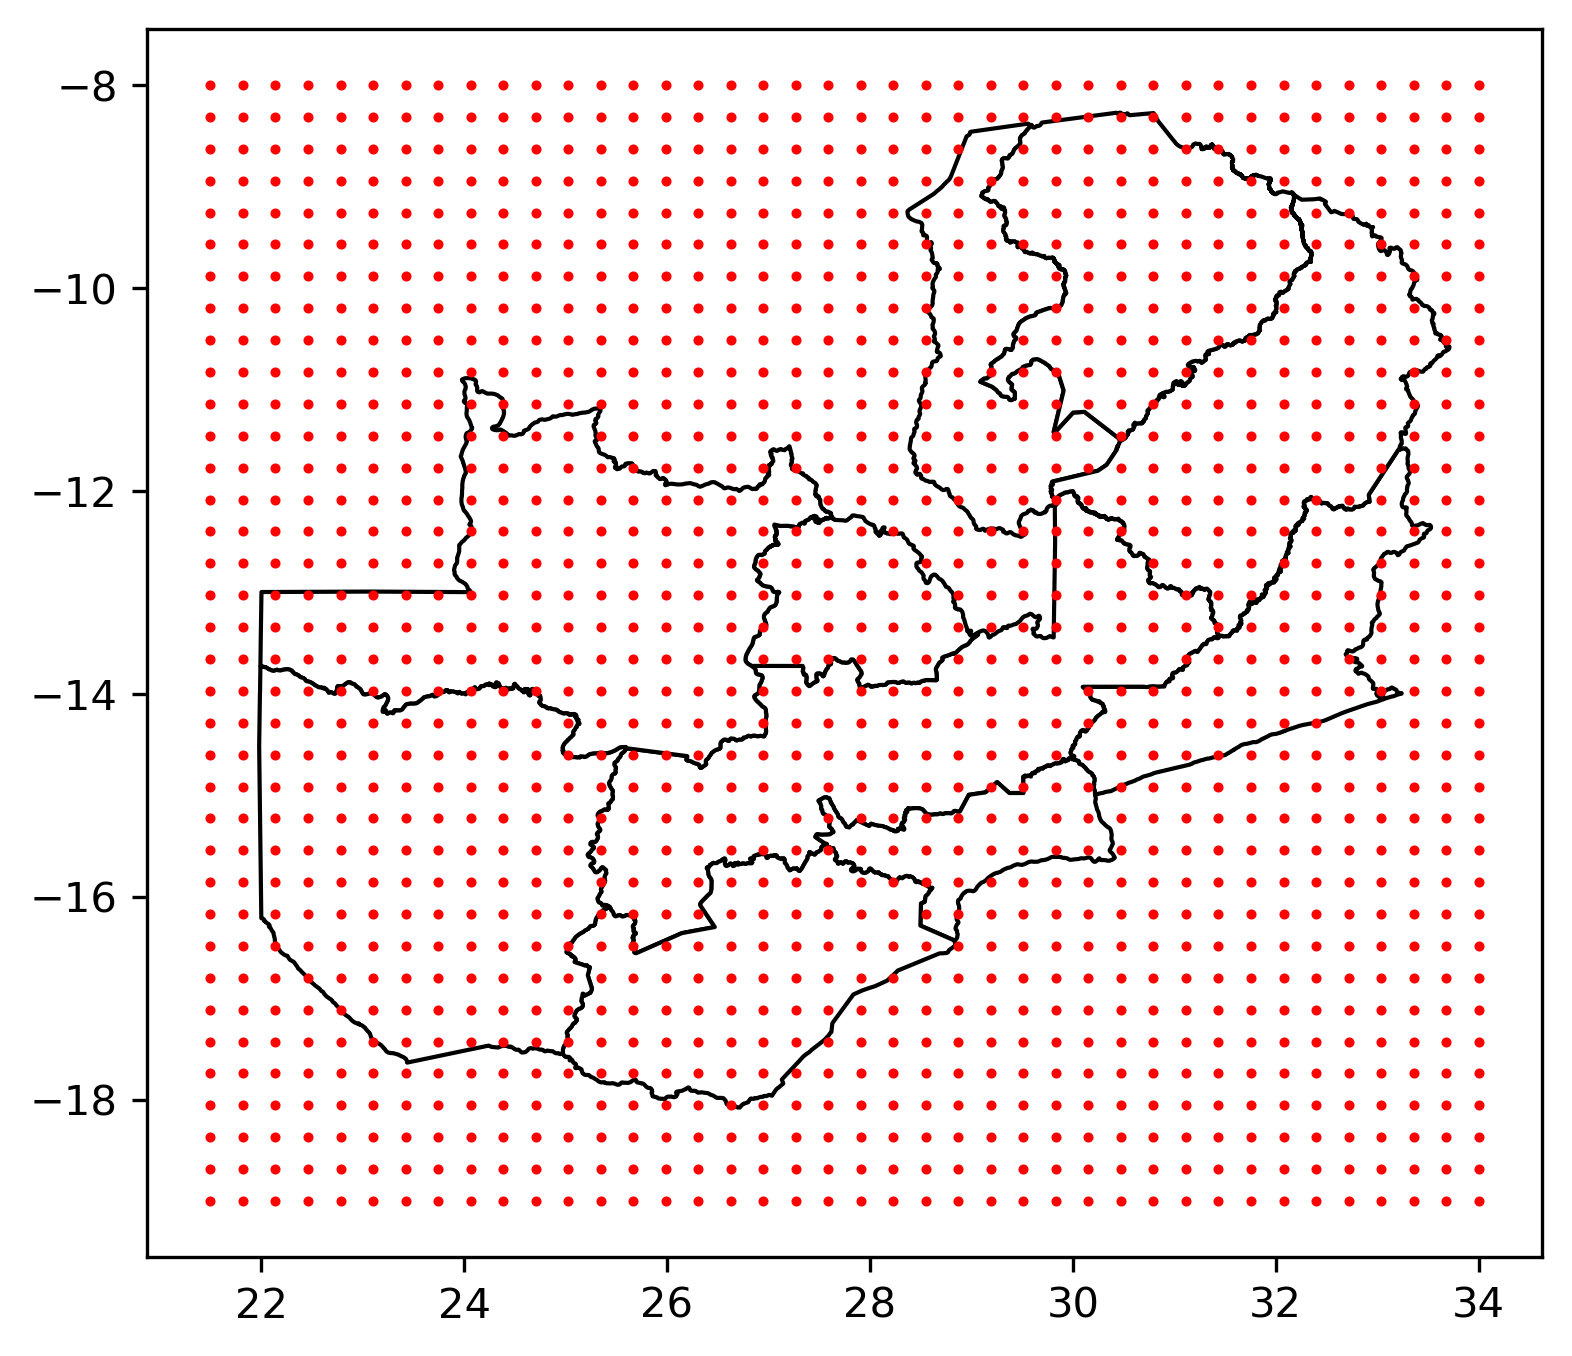

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
divider = make_axes_locatable(ax)
s_new.plot(ax=ax, color='white', edgecolor='black')
grid_pts.plot(ax=ax, marker='o', color='red', markersize=2)

# save
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig(f"figures/ZMB2018_comp_grid{n_x}.pdf")

In [51]:
# def interpolate(polygon, min_pts=10):

#   # extract points from the polygon
#   x, y

In [52]:
def pol_pts(shape, grid_pts, min_pts=10):
    grid_pts.set_crs(epsg=4326, inplace=True);
    grid_pts.crs == shape.crs

    n_pol = len(shape.geometry)
    n_pts = len(grid_pts.geometry)

    pl_pt = np.zeros((n_pol, n_pts), dtype=int)

    pt_which_pol = np.zeros(n_pts, dtype=int)

    for i_pol in range(n_pol):
        pol = shape.geometry[i_pol]
        for j_pts in range(n_pts):
            pt = grid_pts.geometry[j_pts]
            if pol.contains(pt):
                pl_pt[i_pol, j_pts] = 1
                pt_which_pol[j_pts] = i_pol + 1 # note the enumeration!


    # ensure a minimum number of points

    pol_sums = np.sum(pl_pt, axis=1)

    fix_pols = np.where(pol_sums<min_pts)[0]

    if fix_pols.size > 0:

      for i_pol in fix_pols:

        # print(f'i_pol:{i_pol}')

        polygon = shape.geometry[i_pol]
        no_points = pol_sums[i_pol]

        extra_len = min_pts - no_points
        minx, miny, maxx, maxy = polygon.bounds
        extra_y_coords = []
        extra_x_coords = []

        main_rng_key = random.PRNGKey(44)

        # print(extra_len)

        while extra_len > 0:
            main_rng_key, rng_key_pts = random.split(main_rng_key)
            random_point_coords = [
                random.uniform(rng_key_pts, (1,), minval=minx, maxval=maxx)[0],
                random.uniform(rng_key_pts, (1,), minval=miny, maxval=maxy)[0]
            ]
            random_point = Point(float(random_point_coords[0]), float(random_point_coords[1]))

            if polygon.contains(random_point):
              # print('Contains random point')
              extra_y_coords.append(random_point.y)
              extra_x_coords.append(random_point.x)
              extra_len -= 1

        # add extra points to grid

        # Create DataFrame for new points
        extra_df = pd.DataFrame({'Latitude': extra_y_coords, 'Longitude': extra_x_coords})
        extra_grid_pts = gpd.GeoDataFrame(extra_df, geometry=gpd.points_from_xy(extra_df.Longitude, extra_df.Latitude))

        # Set CRS for the new GeoDataFrame
        extra_grid_pts.set_crs(epsg=4326, inplace=True)

        # Concatenate the original and new GeoDataFrames
        grid_pts = pd.concat([grid_pts, extra_grid_pts]).reset_index(drop=True)


      # Amend pl_pt and pt_which_pol (outside polygon loop)
      pl_pt, pt_which_pol, _ = pol_pts(shape, grid_pts, min_pts)

    return([pl_pt, pt_which_pol, grid_pts])

In [53]:
pol_pt_old, pt_which_pol_old, grid_pts_old = pol_pts(s_old, grid_pts, min_pts=10)
pol_sums_old = np.sum(pol_pt_old, axis=1) # how many points in each polygon
print(all(item >= 10 for item in pol_sums_old)) # in each polygon there is at least 10 points
grid_pts_old['pt_which_pol_old'] = pt_which_pol_old
np.where(pol_sums_old<10)
grid_pts_old

True


Latitude  Longitude                    geometry  pt_which_pol_old
0    -19.000000  21.500000  POINT (21.50000 -19.00000)                 0
1    -19.000000  21.820513  POINT (21.82051 -19.00000)                 0
2    -19.000000  22.141026  POINT (22.14103 -19.00000)                 0
3    -19.000000  22.461538  POINT (22.46154 -19.00000)                 0
4    -19.000000  22.782051  POINT (22.78205 -19.00000)                 0
...         ...        ...                         ...               ...
2013 -17.455769  26.790142  POINT (26.79014 -17.45577)               115
2014 -17.507141  26.722168  POINT (26.72217 -17.50714)               115
2015 -17.777426  26.364519  POINT (26.36452 -17.77743)               115
2016 -17.394756  26.870876  POINT (26.87088 -17.39476)               115
2017 -17.401566  26.861866  POINT (26.86187 -17.40157)               115

[2018 rows x 4 columns]

In [54]:
pol_sums_old

array([10, 16, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 13, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 18, 10, 10, 10, 13, 10, 13, 10, 10, 10, 10, 11, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 13, 10, 10, 10, 10, 15, 10, 18, 10, 10, 10, 10, 10,
       17, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       11, 10, 10, 10, 10, 10, 10, 10, 10, 11, 10, 12, 10])

In [55]:
pol_pt_new, pt_which_pol_new, grid_pts_new = pol_pts(s_new, grid_pts_old, min_pts=10)
pol_sums_new = np.sum(pol_pt_new, axis=1) # how many points in each polygon
# print(all(item > 0 for item in pol_sums_new)) # in each polygon there is at least one point
print(all(item > 10 for item in pol_sums_new)) # in each polygon there is at least 10 points
grid_pts_new['pt_which_pol_new'] = pt_which_pol_new
grid_pts_new

True


Latitude  Longitude                    geometry  pt_which_pol_old  \
0    -19.000000  21.500000  POINT (21.50000 -19.00000)                 0   
1    -19.000000  21.820513  POINT (21.82051 -19.00000)                 0   
2    -19.000000  22.141026  POINT (22.14103 -19.00000)                 0   
3    -19.000000  22.461538  POINT (22.46154 -19.00000)                 0   
4    -19.000000  22.782051  POINT (22.78205 -19.00000)                 0   
...         ...        ...                         ...               ...   
2013 -17.455769  26.790142  POINT (26.79014 -17.45577)               115   
2014 -17.507141  26.722168  POINT (26.72217 -17.50714)               115   
2015 -17.777426  26.364519  POINT (26.36452 -17.77743)               115   
2016 -17.394756  26.870876  POINT (26.87088 -17.39476)               115   
2017 -17.401566  26.861866  POINT (26.86187 -17.40157)               115   

      pt_which_pol_new  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  
...                ...  
2013                 9  
2014                 9  
2015                 9  
2016                 9  
2017                 9  

[2018 rows x 5 columns]

In [56]:
pol_sums_new

array([122, 100, 130, 120,  80, 102, 133, 120, 133, 161])

In [57]:
new_y_coords = grid_pts_new['Latitude']
new_x_coords = grid_pts_new['Longitude']
new_x = jnp.array([new_x_coords, new_y_coords]).transpose((1, 0))
print(new_x.shape)

(2018, 2)


In [58]:
grid_pts = grid_pts_new

In [59]:
grid_pts['in_out_new'] = grid_pts['pt_which_pol_new'].apply(lambda x: 'out' if x==0 else 'in')
grid_pts['marker_size_new'] = grid_pts['pt_which_pol_new'].apply(lambda x: 1 if x==0 else 12)
n_pol_new = len(s_new.geometry)

grid_pts['in_out_old'] = grid_pts['pt_which_pol_old'].apply(lambda x: 'out' if x==0 else 'in')
grid_pts['marker_size_old'] = grid_pts['pt_which_pol_old'].apply(lambda x: 1 if x==0 else 12)
n_pol_old = len(s_old.geometry)

In [60]:
cmap = plt.cm.prism  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
cmaplist[0] = (.5, .5, .5, 1.0)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

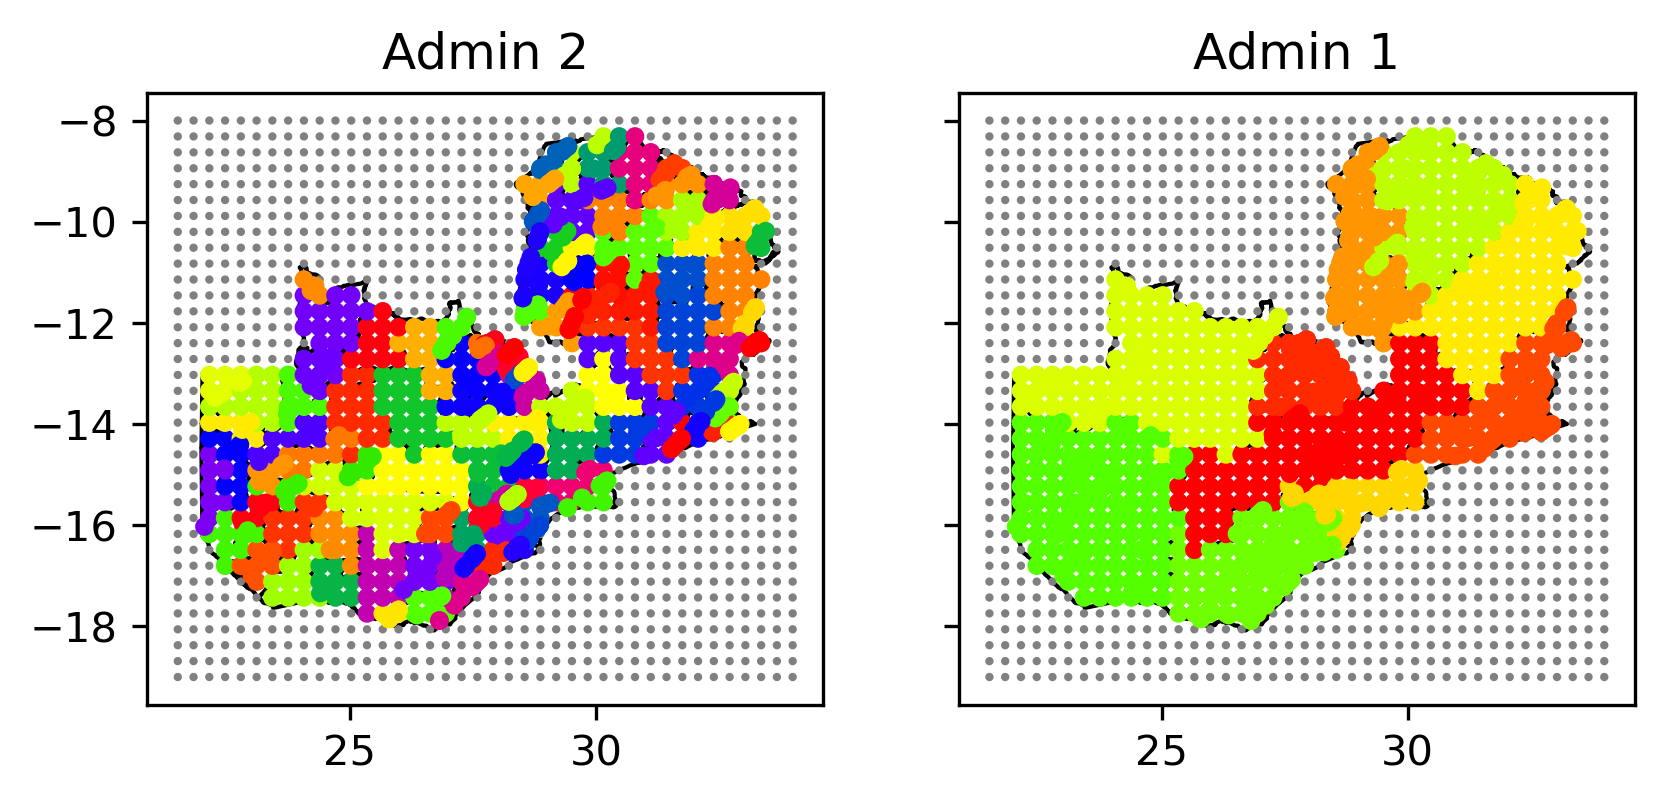

In [61]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, sharey=True)
divider = make_axes_locatable(ax)

# define the bins and normalize
bounds_old = np.linspace(min(pt_which_pol_old), max(pt_which_pol_old), n_pol_old)
norm_old = matplotlib.colors.BoundaryNorm(bounds_old, cmap.N)
s_old.plot(ax=ax1, color='white', edgecolor='black')
grid_pts.plot(ax=ax1, marker='o', column='pt_which_pol_old', markersize='marker_size_old', cmap=cmap)
ax1.title.set_text('Admin 2')

# define the bins and normalize
bounds_new = np.linspace(min(pt_which_pol_new), max(pt_which_pol_new), n_pol_new)
norm_new = matplotlib.colors.BoundaryNorm(bounds_new, cmap.N)
s_new.plot(ax=ax2, color='white', edgecolor='black')
grid_pts.plot(ax=ax2, marker='o', column='pt_which_pol_new', markersize='marker_size_new', cmap=cmap)
ax2.title.set_text('Admin 1')

# Save
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig(f"figures/ZMB2018_grid_polygons_all_admin_grid{n_x}.pdf")

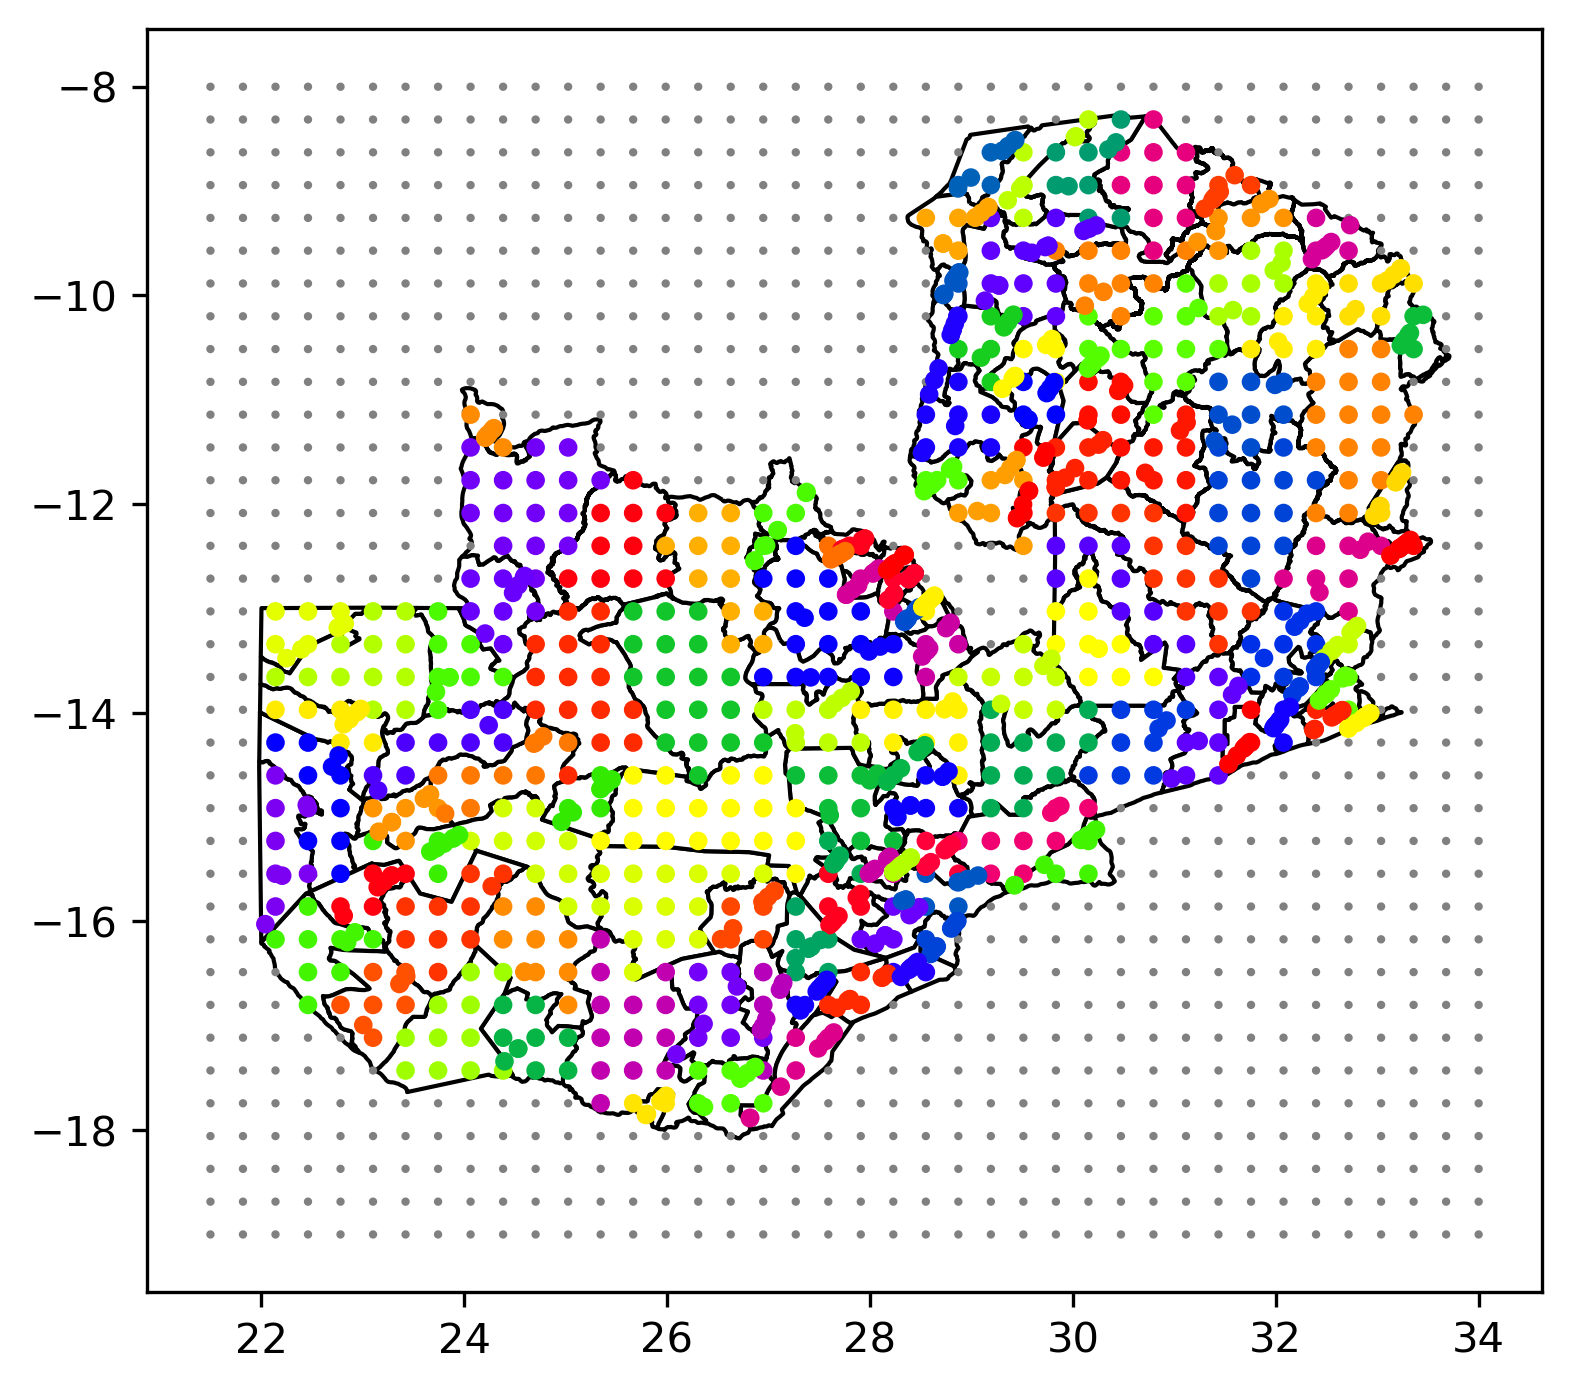

In [62]:
fig, ax1 = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6,6))
divider = make_axes_locatable(ax)

# define the bins and normalize
bounds_old = np.linspace(min(pt_which_pol_old), max(pt_which_pol_old), n_pol_old)
norm_old = matplotlib.colors.BoundaryNorm(bounds_old, cmap.N)
s_old.plot(ax=ax1, color='white', edgecolor='black')
grid_pts.plot(ax=ax1, marker='o', column='pt_which_pol_old', markersize='marker_size_old', cmap=cmap)
#ax1.title.set_text('Before 2010')

# define the bins and normalize
#bounds_new = np.linspace(min(pt_which_pol_new), max(pt_which_pol_new), n_pol_new)
#norm_new = matplotlib.colors.BoundaryNorm(bounds_new, cmap.N)
#s_new.plot(ax=ax2, color='white', edgecolor='black')
#grid_pts.plot(ax=ax2, marker='o', column='pt_which_pol_new', markersize='marker_size_new', cmap=cmap)
#ax2.title.set_text('After 2010')

# Save
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig(f"figures/ZMB2018_grid_polygons_admin2_grid{n_x}.pdf")

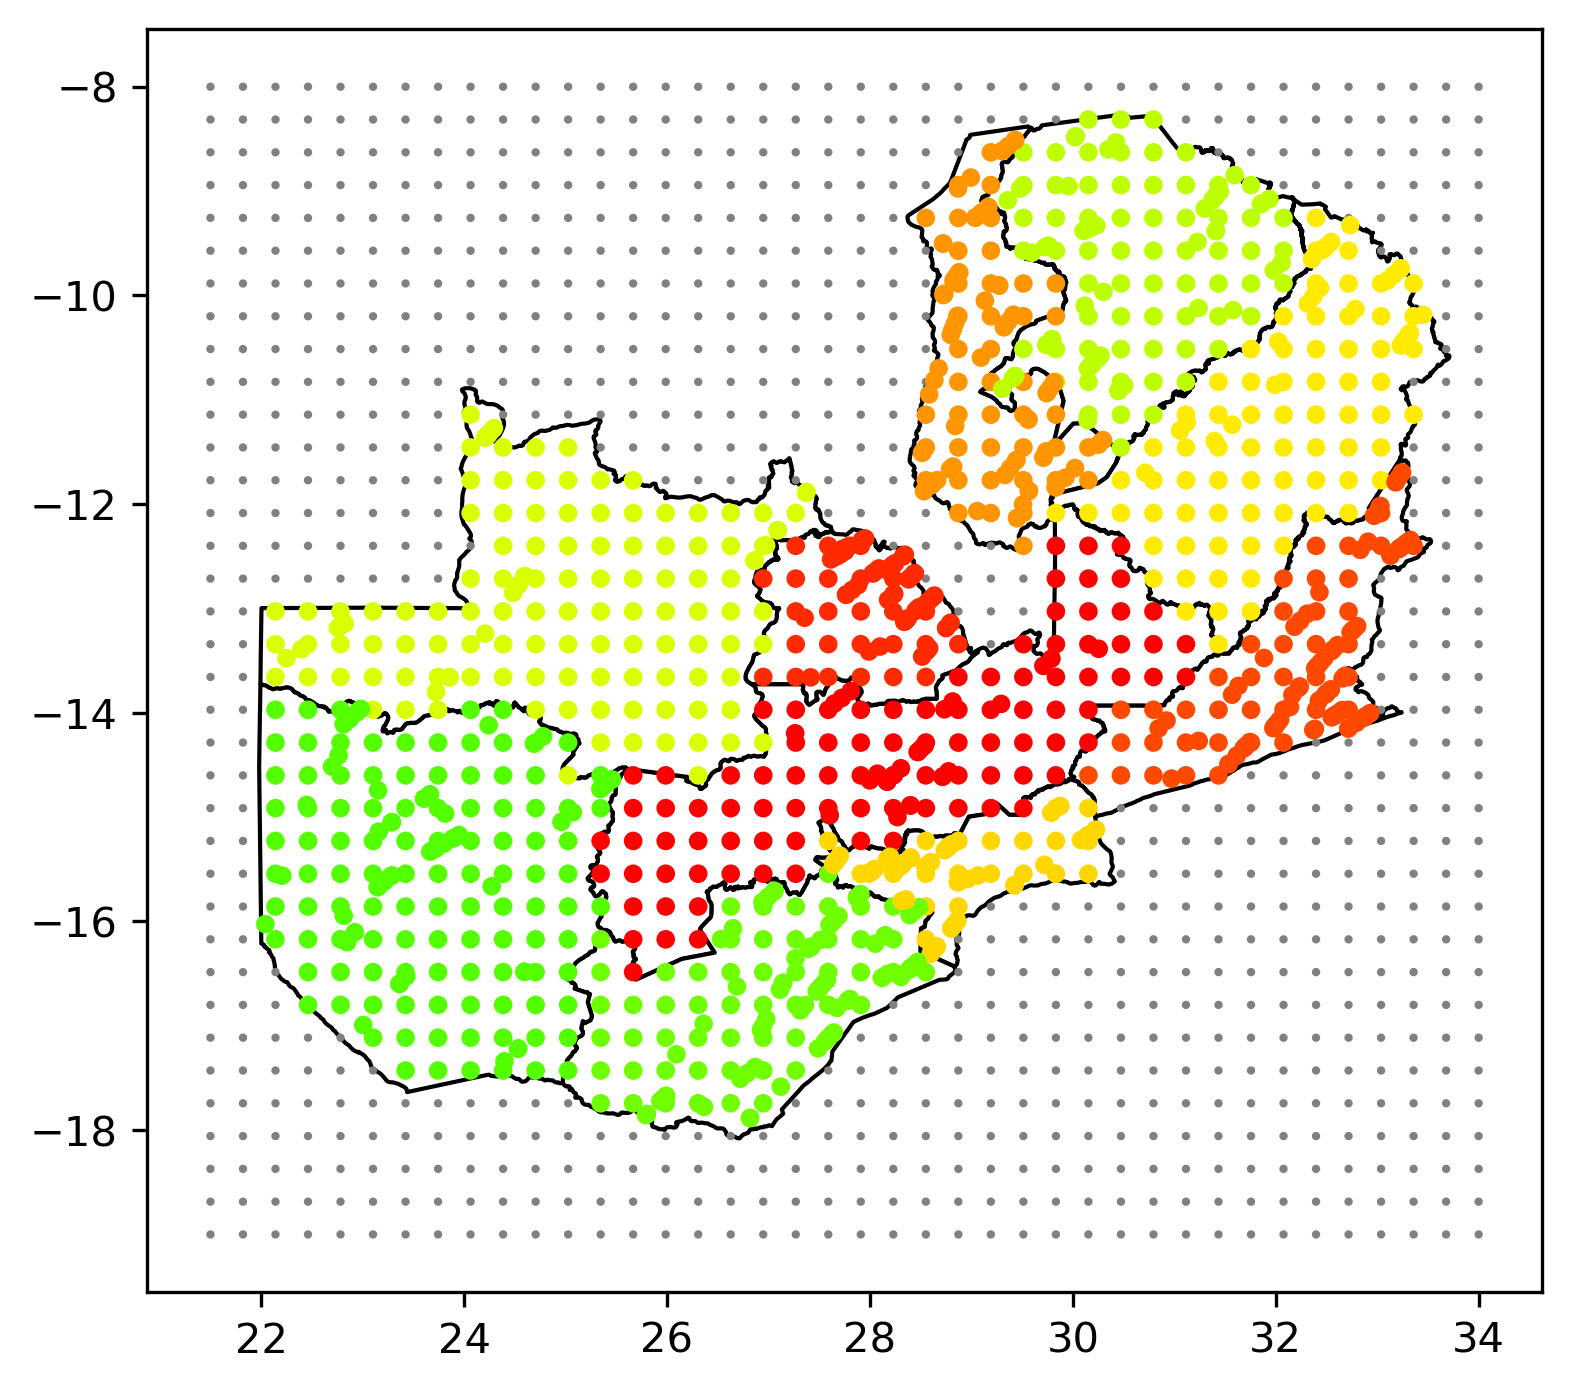

In [63]:
fig, ax2 = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(6,6))
divider = make_axes_locatable(ax)

# define the bins and normalize
bounds_new = np.linspace(min(pt_which_pol_new), max(pt_which_pol_new), n_pol_new)
norm_new = matplotlib.colors.BoundaryNorm(bounds_new, cmap.N)
s_new.plot(ax=ax2, color='white', edgecolor='black')
grid_pts.plot(ax=ax2, marker='o', column='pt_which_pol_new', markersize='marker_size_new', cmap=cmap)
#ax2.title.set_text('After 2010')

# Save
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig(f"figures/ZMB2018_grid_polygons_admin1_grid{n_x}.pdf")

In [64]:
s_old.head(3)

area                                           geometry  new     usage  \
0  CHADIZA  POLYGON ((32.57804 -13.93448, 32.75563 -13.982...    0  0.592593   
1    CHAMA  POLYGON ((32.84411 -10.34120, 32.84790 -10.341...    0  0.656690   
2  CHASEFU  POLYGON ((32.94614 -12.21183, 32.94578 -12.211...    0  0.491268   

   n_obs   y  estimate  
0     44   2  0.054054  
1    220  13  0.059658  
2    157   3  0.018292

In [65]:
s_new.head(3)

area                                           geometry  new  \
0     CENTRAL  POLYGON ((29.99949 -12.00267, 30.00002 -12.002...    1   
1  COPPERBELT  POLYGON ((27.94644 -12.28198, 27.95514 -12.297...    1   
2     EASTERN  POLYGON ((33.25764 -11.58238, 33.26164 -11.585...    1   

      usage  n_obs    y  estimate  
0  0.379661   2073  106  0.051102  
1  0.444083   3490  420  0.120391  
2  0.547537   3013  195  0.064639

In [66]:
type(s_new)

geopandas.geodataframe.GeoDataFrame

In [67]:
s = pd.concat([s_old, s_new])
s.head()
print(s.shape)

(125, 7)


# Traditional prevalence model

In [68]:
n_old, _= s_old.shape
n_new, _= s_new.shape

In [69]:
# draw GP samples on the grid

def dist_euclid(x, z):
    x = jnp.array(x)
    z = jnp.array(z)
    if len(x.shape)==1:
        x = x.reshape(x.shape[0], 1)
    if len(z.shape)==1:
        z = x.reshape(x.shape[0], 1)
    n_x, m = x.shape
    n_z, m_z = z.shape
    assert m == m_z
    delta = jnp.zeros((n_x,n_z))
    for d in jnp.arange(m):
        x_d = x[:,d]
        z_d = z[:,d]
        delta += (x_d[:,jnp.newaxis] - z_d)**2
    return jnp.sqrt(delta)


def exp_sq_kernel(x, z, var, length, noise, jitter=1.0e-4):
    dist = dist_euclid(x, z)
    deltaXsq = jnp.power(dist/ length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * jnp.eye(x.shape[0])
    return k

In [70]:
def M_g(M, g, averages=False, grid_nb_vec=None):
    '''
    - $M$ is a matrix with binary entries $m_{ij},$ showing whether point $j$ is in polygon $i$
    - $g$ is a vector of GP draws over grid
    - $maltmul(M, g)$ gives a vector of sums over each polygon
    '''
    M = jnp.array(M)
    g = jnp.array(g).T
    if averages:
      return (jnp.multiply(jnp.matmul(M, g), jnp.reciprocal(grid_nb_vec)))
    else:
      return(jnp.matmul(M, g))

# Train VAE

In [71]:
s_old_plot = s[0:n_old].copy()
s_new_plot = s[n_old:(n_old + n_new)].copy()

In [72]:
# ! pip install flax

In [73]:
# ! pip install jax

In [74]:
# ! pip install jaxlib

In [75]:
from collections.abc import Callable
from typing import Iterable

import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import optax
from flax.training.train_state import TrainState
from jax import Array, value_and_grad, jit, random
from jax.scipy.stats import norm
from numpyro.infer import MCMC, NUTS
from tqdm.notebook import tqdm

In [76]:
args = {"seed": 0,

        # architecture
        "conditional": True,
        "hidden_dim": 512,
        "z_dim": 256,

        # data generation
        "new_data": True,  # set to True to generate new data. Otherwise read from file
        "save_data": False, # set to True to save generated training and test datasets
        "batch_size": 100,
        "samples": 5000,

        # VAE setup
        "vae_sd": 1,
        "n_epochs": 100,        # for better results, set to 15000
        "learning_rate": 1e-3,
        "train_vae": True,      # set to True to train VAE
        "save_vae": False,
        "load_vae": False,      # set to True to load trained CVAE
        "decoder_params": None,
        "hyperprior_ls_name": "Gamma(3, 10)",
        "hyperprior_var_name": "Gamma(8, 100)",
        "hyperprior_ls": dist.Gamma(3, 10),
        "hyperprior_var": dist.Gamma(8, 100),

        # MCMC setup
        "num_warmup": 200,
        "num_mcmc_samples": 3000,
        "num_chains": 4,
        "thinning": 1,
        "true_ls": 0.2,

        'n_obs': jnp.array(s.n_obs),
        "x": new_x,
        "gp_kernel": exp_sq_kernel,
        "jitter": 1e-4,
        "encode_avg": True,
        "encode_avg_name": "encode_avg",
        "M_old": pol_pt_old,
        "M_new": pol_pt_new,
        
        # posterior analysis
        "num_samples_posterior": 1000,

        # VAE training
        "rng_key": random.PRNGKey(5),

       }

In [77]:
model_specs =('_all_admin' +
              '_' + str(args['encode_avg_name']) +
              '_mcmcsamp' + str(args['num_mcmc_samples'])+
             '_h' + str(args["hidden_dim"])+
             '_z' + str(args["z_dim"])+
             '_epochs' + str(args["n_epochs"])+
             '_ls' + args['hyperprior_ls_name']+
             '_var' + args['hyperprior_var_name'])
print('Model specifications:', model_specs)

Model specifications: _all_admin_encode_avg_mcmcsamp3000_h512_z256_epochs100_lsGamma(3, 10)_varGamma(8, 100)


In [78]:
# Create the new directory
os.makedirs('figures/ZMB2018_aggCVAE'+model_specs, exist_ok=True)

In [79]:
# ! pip install seaborn

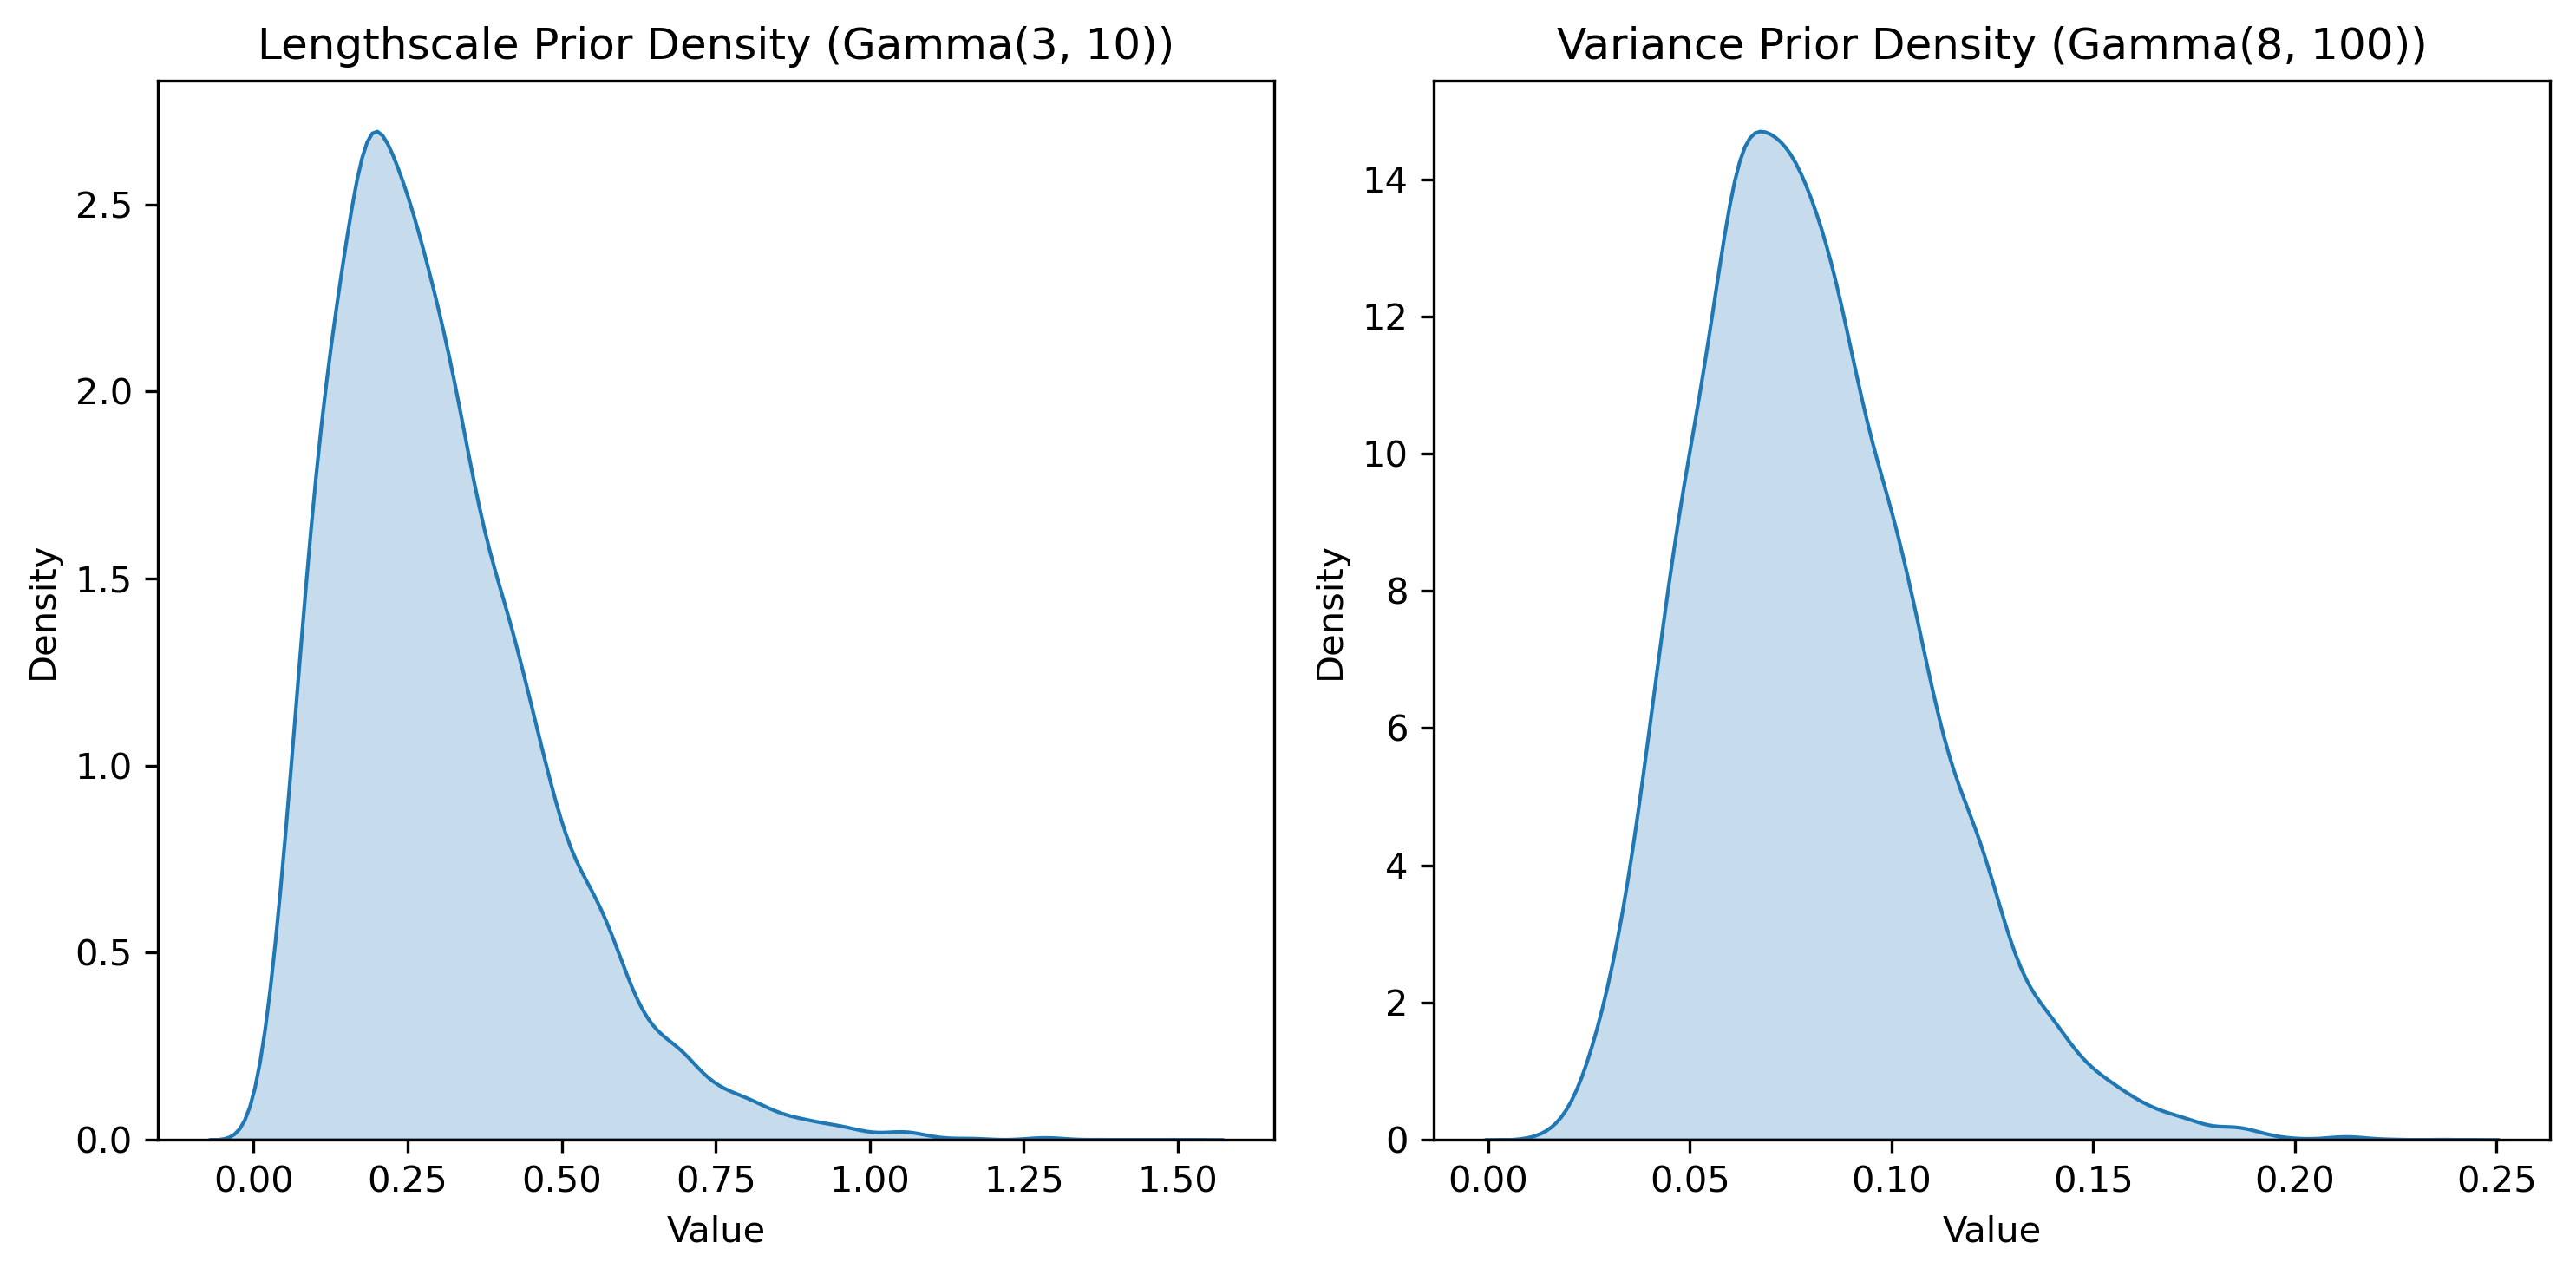

In [80]:
# Plot the hyperpriors
import matplotlib.pyplot as plt
import seaborn as sns
import jax.random as random

# Set random seed for reproducibility
rng_key = random.PRNGKey(0)

# Define the gamma distribution
dist_ls = args['hyperprior_ls']
dist_var = args['hyperprior_var']

# Sample from the gamma distribution
samples_ls = dist_ls.sample(rng_key, (10000,))
samples_var = dist_var.sample(rng_key, (10000,))


# Set plot parameters
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

# Create a figure and two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # Adjust the figsize as needed

# Plot the Lengthscale density
sns.kdeplot(samples_ls, ax=axs[0], fill=True)
axs[0].set_title(f'Lengthscale Prior Density ({args["hyperprior_ls_name"]})')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Density')

# Plot the Variance density
sns.kdeplot(samples_var, ax=axs[1], fill=True)
axs[1].set_title(f'Variance Prior Density ({args["hyperprior_var_name"]})')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Density')

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig('figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+model_specs+ '_hyperprior_distributions.pdf')
plt.show()

In [81]:
from collections.abc import Callable
from flax import linen as nn


class MLP(nn.Module):
    dims: list[int]
    act_fn: Callable = nn.relu
    p_dropout: float = 0.0

    @nn.compact
    def __call__(self, x, training: bool = False):
        for dim in self.dims[:-1]:
            x = nn.Dense(dim)(x)
            x = self.act_fn(x)
            x = nn.Dropout(self.p_dropout, deterministic=not training)(x)
        return nn.Dense(self.dims[-1])(x)

In [82]:
#!/usr/bin/env python3
import jax.numpy as jnp
from flax import linen as nn
from jax import Array, random


class PriorCVAE(nn.Module):
    r"""[PriorCVAE](https://arxiv.org/pdf/2304.04307) approximates a Gaussian Process.

    Once trained, the module's `decoder` can be used as a generative
    model to simulate a GP from the samples it was trained on.

    Args:
        encoder: A module used to encode GP realizations and
            their hyperparamters.
        decoder: A module used to decode random vectors and
            GP hyperparameters into GP samples.
        z_dim: The size of the hidden dimension.

    Returns:
        An instance of the PriorCVAE network.
        $\hat{\mathbf{f}}$, a recreation of the original $\mathbf{f}$,
        along with $\mu$ and $\log(\sigma^2)$, which are often used
        to calculate losses involving KL divergence.
    """

    encoder: nn.Module
    decoder: nn.Module
    z_dim: int

    @nn.compact
    def __call__(self, rng: Array, var: float, ls: float, f: Array):
        r"""Run module forward.

        Args:
            rng: A pseudo-random number generator.
            var: The variance for the GP.
            ls: The lengthscale for the GP.
            f: The function values, an array of shape `(B, K, 1)`.

        Returns:
            $\hat{\mathbf{f}}$, a recreation of the original$\mathbf{f}$,
            along with $\mu$ and $\log(\sigma^2)$, which are often used
            to calculate losses involving KL divergence.
        """
        batch_size = f.shape[0]
        var = jnp.full((batch_size, 1), var)
        ls = jnp.full((batch_size, 1), ls)
        f_flat = f.reshape(batch_size, -1)
        latents = self.encoder(jnp.hstack([f_flat, var, ls]))
        mu = nn.Dense(self.z_dim)(latents)
        log_var = nn.Dense(self.z_dim)(latents)
        std = jnp.exp(log_var / 2)
        eps = random.normal(rng, log_var.shape)
        z = mu + std * eps
        f_hat = self.decoder(jnp.hstack([z, var, ls]))
        return f_hat.reshape(f.shape), mu, log_var
    
    def decode(self, z: Array, var: float, ls: float):
        B = z.shape[0]
        var = jnp.full((B, 1), var)
        ls = jnp.full((B, 1), ls)
        return self.decoder(jnp.hstack([z, var, ls]))

In [83]:
def gp_aggr(args):

    x = args["x"]
    gp_kernel=args["gp_kernel"]
    jitter = args["jitter"]
    M_old = args["M_old"]
    M_new = args["M_new"]

    # random effect - aggregated GP
    # length = numpyro.sample("kernel_length", dist.InverseGamma(3,3))
    # random effect - aggregated GP
    length = numpyro.sample("kernel_length", args['hyperprior_ls'])
    variance = numpyro.sample("kernel_var", args['hyperprior_var'])
    k = gp_kernel(x, x, variance, length, jitter)
    f = numpyro.sample("f", dist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k))

    # aggregate f into gp_aggr according to indexing of (point in polygon)
    # gp_aggr_old = numpyro.deterministic('gp_aggr_old', M_g(M_old, f, averages=True, obs_vec=jnp.array(s_old_plot['n_obs'])))
    if args["encode_avg"]:
        gp_aggr_old = numpyro.deterministic('gp_aggr_old', M_g(M_old, f, averages=True, grid_nb_vec=pol_sums_old))
        gp_aggr_new = numpyro.deterministic('gp_aggr_new', M_g(M_new, f, averages=True, grid_nb_vec=pol_sums_new))
    else:
        gp_aggr_old = numpyro.deterministic('gp_aggr_old', M_g(M_old, f))
        gp_aggr_new = numpyro.deterministic('gp_aggr_new', M_g(M_new, f))
    
    
    # gp_aggr_new = numpyro.deterministic('gp_aggr_new', M_g(M_new, f, averages=True, obs_vec=jnp.array(s_new_plot['n_obs'])))
    gp_aggr = numpyro.deterministic('gp_aggr', jnp.concatenate([gp_aggr_old, gp_aggr_new]))
    ls = numpyro.deterministic('ls', length)
    var = numpyro.deterministic('var', variance)

In [84]:
# rng_key, rng_key_ = random.split(random.PRNGKey(4))
# agg_gp_predictive = Predictive(gp_aggr, num_samples=args['num_samples_posterior'])
# agg_gp_preds = agg_gp_predictive(rng_key_, args)
# agg_gp_draws = agg_gp_preds['gp_aggr']
# ls_draws = agg_gp_preds['ls']
# var_draws = jnp.array(agg_gp_preds['var'])

In [85]:
# import matplotlib.gridspec as gridspec

# s_old_plot = s[0:n_old].copy()

# # Create a figure with a gridspec
# fig = plt.figure(figsize=(25, 5))
# gs = gridspec.GridSpec(1, 6, width_ratios=[1, 1, 1, 1, 1, 0.1], wspace=0.3)  # Adjust wspace for more horizontal space

# axs = [fig.add_subplot(gs[i]) for i in range(5)]

# # Plot each column in a separate subplot
# for i in range(5):
#     nm = 'gp_aggr_' + str(i)
#     s_old_plot[nm] = agg_gp_draws[i, 0:n_old]
#     s_old_plot.plot(column=nm, ax=axs[i], legend=False)
#     axs[i].set_xlabel('Longitude')
#     axs[i].set_ylabel('Latitude')
#     axs[i].set_title(f'aggGP-prior {i}')

# # Add an overall title
# fig.suptitle('Admin 2: aggGP priors before training', fontsize=16)

# # Create a colorbar
# cbar_ax = fig.add_subplot(gs[5])
# sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=s_old_plot[nm].min(), vmax=s_old_plot[nm].max()))
# cbar = fig.colorbar(sm, cax=cbar_ax)
# cbar_ax.set_ylabel('Value')

# # Save the figure
# plt.savefig('figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+model_specs+'_aggGP_priors_before_training_admin2.pdf')
# plt.show()

In [86]:
# s_new_plot = s[n_old:(n_old + n_new)].copy()

# # Create a figure with a gridspec
# fig = plt.figure(figsize=(25, 5))
# gs = gridspec.GridSpec(1, 6, width_ratios=[1, 1, 1, 1, 1, 0.1], wspace=0.3)  # Adjust wspace for more horizontal space

# axs = [fig.add_subplot(gs[i]) for i in range(5)]

# # Plot each column in a separate subplot
# for i in range(5):
#     nm = 'gp_aggr_' + str(i)
#     s_new_plot[nm] = agg_gp_draws[i,n_old:(n_old + n_new)]
#     s_new_plot.plot(column=nm, ax=axs[i], legend=False)
#     axs[i].set_xlabel('Longitude')
#     axs[i].set_ylabel('Latitude')
#     axs[i].set_title(f'aggGP-prior {i}')

# # Add an overall title
# fig.suptitle('Admin 1: aggGP priors before training', fontsize=16)

# # Create a colorbar
# cbar_ax = fig.add_subplot(gs[5])
# sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=s_new_plot[nm].min(), vmax=s_new_plot[nm].max()))
# cbar = fig.colorbar(sm, cax=cbar_ax)
# cbar_ax.set_ylabel('Value')

# # Save the figure
# plt.savefig('figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+model_specs+'_aggGP_priors_before_training_admin1.pdf')
# plt.show()

In [87]:
class aggCVAED:
  def __init__(self, n_samples, x, model_args):
    self.n_samples = n_samples
    self.args = model_args
    self.x, self.y, self.ls, self.var = self._sampledata()

  def __len__(self):
    return self.n_samples

  def __getitem__(self, idx=0):
    return(self.x[idx], self.y[idx], self.ls[idx], self.var[idx])

  def _sampledata(self):
    # rng_key = rnd.randint(0, 912393890428)
    rng_key = 0
    rng_key, rng_key_ = random.split(random.PRNGKey(rng_key))
    agg_gp_predictive = Predictive(gp_aggr, num_samples=self.n_samples)
    all_draws = agg_gp_predictive(rng_key, self.args)

    ls_draws = all_draws['ls']
    ls_draws = jnp.array(ls_draws.reshape(ls_draws.shape[0], 1))
    
    gp_draws = all_draws['gp_aggr']
    gp_draws = jnp.array(gp_draws.reshape(gp_draws.shape[0], gp_draws.shape[1], 1))
    
    var_draws = all_draws['var']
    var_draws = jnp.array(var_draws.reshape(var_draws.shape[0], 1))
    
    x_repeated = np.tile(x, (self.n_samples, 1, 1))
    # x_repeated is of the shape (n_samples, N, D), where N is number of datapoints, D is dimensionality
    # return (x.repeat(self.n_samples).reshape(x.shape[0], self.n_samples).transpose(), gp_draws, ls_draws)
    return (x_repeated, gp_draws, ls_draws, var_draws)


In [88]:
from collections.abc import Callable
from typing import Iterable

import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import optax
from flax.training.train_state import TrainState
from jax import Array, value_and_grad, jit, random
from jax.scipy.stats import norm
from numpyro.infer import MCMC, NUTS
from tqdm.notebook import tqdm


def dataloader(dataset, batch_size, shuffle=True):
    indices = np.arange(len(dataset))
    if shuffle:
        np.random.shuffle(indices)
    
    for start_idx in range(0, len(dataset), batch_size):
        batch_indices = indices[start_idx:start_idx + batch_size]
        batch = [dataset[idx] for idx in batch_indices]
        x_batch, y_batch, ls_batch, var_batch = zip(*batch)
        yield (jnp.array(x_batch), jnp.array(y_batch), jnp.array(ls_batch), jnp.array(var_batch))

In [89]:
import os
import orbax.checkpoint
from flax.training import checkpoints


def train(
    rng: jax.Array,
    model: nn.Module,
    train_step: Callable,
    n_samples: int,
    x: jax.Array,
    model_args,
    batch_size: int = 1024,
    num_epochs: int = 1000,
    n_samples_val: int = 100,
    checkpoint_path: str = "checkpoints_dir",
):
    
#     # Define an absolute path for checkpoints
#     checkpoint_dir = checkpoint_path

#     # Orbax Checkpoint manager
#     orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
#     checkpoint_manager = orbax.checkpoint.CheckpointManager(
#         checkpoint_dir, orbax_checkpointer)

    rng_init, rng_z, rng_train = random.split(rng, 3)

    # define dataset and dataloader
    dataset = aggCVAED(n_samples=n_samples, x=x, model_args=model_args)
    loader = dataloader(dataset, batch_size=batch_size, shuffle=True)

    _s, f, ls, var = next(loader)
    
    state = TrainState.create(
        apply_fn=model.apply,
        params=model.init(rng_init, rng_z, var, ls, f)["params"],
        tx=optax.adam(1e-3),
    )
    
    is_decoder_only = False
    
    num_batches = n_samples // batch_size
    
    losses = np.zeros((num_batches,))
    avg_losses = np.zeros((num_epochs,))
    val_avg_losses = np.zeros((num_epochs,))
    
    start_epoch = 0

#     # Check if there is a checkpoint to resume from
#     latest_ckpt = checkpoint_manager.latest_step()
#     if latest_ckpt is not None:
#         state, extra_data = checkpoint_manager.restore(latest_ckpt, items={'state': state})
#         start_epoch = extra_data['epoch']
#         avg_losses = extra_data['avg_losses']
#         val_avg_losses = extra_data['val_avg_losses']
#         print(f"Resuming training from epoch {start_epoch}")
    
    for epoch in (pbar := tqdm(range(start_epoch, num_epochs), dynamic_ncols=True)):
        # re-initialise loader
        loader = dataloader(dataset, batch_size=batch_size, shuffle=True)
        for i, batch in enumerate(loader):
            rng_step, rng_train = random.split(rng_train)
            state, losses[i] = train_step(rng_step, state, batch)
        
        # calculate train loss every epoch
        avg = jnp.mean(losses)
        avg_losses[epoch] = avg
        pbar.set_postfix(loss=f"Epoch: {epoch}, Train loss: {avg:.3f}")
        # wandb.log({"epoch_train_loss": avg})
        
        # validate every epoch
        rng_valid, rng_train = random.split(rng_train)
        val_avg_losses[epoch] = validate(rng_valid, 
                                  x, 
                                  state, 
                                  model_args, 
                                  n_samples_val,
                                  epoch=epoch,
                                  numb_epochs=num_epochs,
                                  decoder_only=is_decoder_only, 
                                  wandb_key=f"Epoch {epoch}")
        # reset losses vector for next epoch
        losses = np.zeros((num_batches,))
        
#         # Save checkpoint after each epoch
#         checkpoint_manager.save(epoch, {'state': state, 'extra_data': {'epoch': epoch, 'avg_losses': avg_losses, 'val_avg_losses': val_avg_losses}})
    
    return state, loader, avg_losses, val_avg_losses

In [90]:
def validate(
    rng: jax.Array,
    x: jax.Array,
    state: TrainState,
    model_args,
    n_samples: int,
    epoch: int,
    numb_epochs: int = 1000,
    decoder_only: bool = False,
    batch_size: int = 100,
    #num_plots: int = 16,
    wandb_key: str = "",
    results_path: Optional[Path] = None,
):
    rng_data, rng_latent_z, rng_plots = random.split(rng, 3)
    
    # define dataset and dataloader
    dataset = aggCVAED(n_samples=n_samples, x=x, model_args=model_args)
    loader = dataloader(dataset, batch_size=batch_size, shuffle=True)
    
    num_batches = n_samples // batch_size
    losses = np.zeros((num_batches,))
    results = []
    for i, batch in enumerate(loader):
        z, f, ls, var = batch
        params = {"params": state.params}
        # rngs = {"latent_z": rng_latent_z}
        if decoder_only:
            f_hat = jit(state.apply_fn)(params, var, ls, f)
            losses[i] = optax.squared_error(f_hat, f.squeeze()).mean()
        else:
            f_hat, z_mu, z_log_var = state.apply_fn(params, rng_latent_z, var, ls, f)
            kl_div = (0.5 * (jnp.exp(z_log_var) + jnp.square(z_mu) - 1 - z_log_var)).mean()
            logp = norm.logpdf(f, f_hat, 1.0).mean()
            
#             f_hat, z_mu, z_std = state.apply_fn(params, rng_latent_z, var, ls, f)
#             kl_div = -jnp.log(z_std) + (z_std**2 + z_mu**2 - 1) / 2
#             logp = norm.logpdf(f, f_hat, 1.0).mean()
        
            losses[i] = -logp + kl_div
            # print(losses[i])
        if results_path:
            b = [np.array(v) for v in batch]
            p = np.array(f_hat)
            results += [(b, p)]
    loss = losses.mean()
    print(f"Epoch: {epoch}, Validation loss: {loss:.3f}")
    # wandb.log({"validation_loss": loss})
    if results_path:
        with open(results_path, "wb") as f:
            pickle.dump(results, f)
    return loss

In [91]:
def build_prior_cvae(num_s: int = 64, z_dim: int = 64, hidden_dim: int = 256):
    encoder = MLP([hidden_dim, z_dim])
    decoder = MLP([hidden_dim, num_s])
    return PriorCVAE(encoder, decoder, z_dim)

@jit
def prior_cvae_train_step(rng, state, batch):
    def elbo_loss(params):
        _s, f, ls, var  = batch
        f_hat, z_mu, z_log_var = state.apply_fn({"params": params}, rng, var, ls, f)
        kl_div = (0.5 * (jnp.exp(z_log_var) + jnp.square(z_mu) - 1 - z_log_var)).mean()
        logp = norm.logpdf(f, f_hat, 1.0).mean()
        return -logp + kl_div

    loss, grads = value_and_grad(elbo_loss)(state.params)
    return state.apply_gradients(grads=grads), loss

In [92]:
model_args = args
n_samples = args['samples']
num_epochs = args['n_epochs']
x = args['x']

num_s = 10 + 115

batch_size = args['batch_size']

key = random.key(0)
rng_data, rng_train, rng_z = random.split(key, 3)

prior_cvae = build_prior_cvae(num_s, z_dim=args['z_dim'], hidden_dim=args['hidden_dim'])

In [93]:
# state, loader, train_losses, val_losses = train(rng_train, 
#                                                 prior_cvae, 
#                                                 prior_cvae_train_step, 
#                                                 n_samples, 
#                                                 x, 
#                                                 model_args, 
#                                                 batch_size,
#                                                 num_epochs)

In [94]:
# plt.plot(np.arange(0, len(train_losses), 1), train_losses, label="train loss")
# plt.plot(np.arange(0, len(val_losses), 1), val_losses, label="test loss")
# plt.xlabel("epochs")
# plt.legend()
# plt.title("Train and test losses, PriorCVAE")

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['savefig.dpi'] = 300
# plt.savefig('figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+model_specs+'_loss_complete.pdf')

In [95]:
# decoder_params = state.params["decoder"]
# args["decoder_params"] = decoder_params

In [96]:
# have to add number of epochs in training so that the name is relevant
# model_save_name = f'aggCVAE_decoder' + model_specs
model_save_name = "aggCVAE_decoder_all_admin_encode_avg_mcmcsamp1000_h512_z256_epochs100_lsGamma(3, 10)_varGamma(8, 100)"
PATH = F"decoders/{model_save_name}"
PATH_loss = F"losses/{model_save_name}"

In [97]:
# # Save
# with open(PATH, 'wb') as file:
#    pickle.dump(decoder_params, file)

# with open(PATH_loss, 'wb') as file:
#    pickle.dump({'train_losses':train_losses, 'val_losses':val_losses}, file)

In [98]:
# Load
with open(PATH, 'rb') as file:
   decoder_params = pickle.load(file)
   print(len(decoder_params))

args["decoder_params"] = decoder_params

2


In [99]:
# with open(PATH_loss, 'rb') as file:
#    losses_save = pickle.load(file)

# train_losses_save = losses_save['train_losses']
# val_losses_save = losses_save['val_losses']

# print(losses_save)

In [100]:
# plt.plot(np.arange(2, len(train_losses_save), 1), train_losses_save[2:], label="train loss")
# plt.plot(np.arange(2, len(val_losses_save), 1), val_losses_save[2:], label="test loss")
# plt.xlabel("epochs")
# plt.legend()
# plt.title("Train and test losses, PriorCVAE")

# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['savefig.dpi'] = 300
# plt.savefig('figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+model_specs+'_loss_short.pdf')

In [101]:
decode_dict = {'decoder': decoder_params}
decode_dict

{'decoder': {'Dense_0': {'bias': Array([-0.3283602 , -0.3273507 , -0.34827536, -0.34617975, -0.3323505 ,
          -0.35714018, -0.3306438 , -0.30213857, -0.320807  , -0.35907495,
          -0.2744398 , -0.33516967, -0.31112978, -0.34205067, -0.34751135,
          -0.27704915, -0.2870664 , -0.34524417, -0.27796435, -0.3044098 ,
          -0.33109006, -0.28615943, -0.2490543 , -0.3443018 , -0.30664095,
          -0.32223573, -0.30837408, -0.34955376, -0.3901363 , -0.33347487,
          -0.22835723, -0.3187644 , -0.31135303, -0.3174097 , -0.3289017 ,
          -0.28787255, -0.32299972, -0.32535806, -0.28291184, -0.30015355,
          -0.30800813, -0.3248404 , -0.3039828 , -0.31468388, -0.36254725,
          -0.25274566, -0.27498844, -0.30167675, -0.3127988 , -0.31955692,
          -0.3116628 , -0.33442524, -0.32778725, -0.31084716, -0.32709008,
          -0.28948155, -0.3758091 , -0.34752202, -0.30064592, -0.2724275 ,
          -0.3079917 , -0.31387156, -0.3513936 , -0.2845594 , -0.34028

In [102]:
def vae_sample(args):

    decoder_params = args["decoder_params"]
    z_dim_cond, hidden_dim = decoder_params['Dense_0']['kernel'].shape
    z_dim = z_dim_cond - 2   # z_dim_cond includes both lengthscale and variance

    # will have to change to match closer to reality
    var = numpyro.sample("var", args['hyperprior_var'])
    ls = numpyro.sample("ls", args['hyperprior_ls'])
    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    z = z.reshape(1, z.shape[0])
    
    prior_cvae_sample = build_prior_cvae(num_s, z_dim=args['z_dim'], hidden_dim = args['hidden_dim'])
    decoder_nn = prior_cvae_sample.apply({"params": {'decoder': decoder_params}}, z, var, ls, method='decode')
    vae_aggr = numpyro.deterministic("vae_aggr", decoder_nn)

In [103]:
# rng_key, rng_key_predict = random.split(random.PRNGKey(4))
# vae_predictive = Predictive(vae_sample, num_samples=args['num_samples_posterior'])
# vae_draws = vae_predictive(rng_key_predict, args)['vae_aggr']

In [104]:
# vae_draws[0][0][n_old:(n_old + n_new)]

In [105]:
# # new
# fig, axs = plt.subplots(2, 5, figsize=(20, 5))

# for i in range(5):
#     nm = 'gp_aggr_' + str(i)
#     s_new_plot.plot(column=nm, ax=axs[0,i], legend=True)
#     axs[0,i].set_title( 'gp_aggr-prior' + str(i))

# for i in range(5):
#     nm = 'vae_draw_' + str(i)
#     s_new_plot[nm] = vae_draws[i][0][n_old:(n_old + n_new)]
#     s_new_plot.plot(column=nm, ax=axs[1,i], legend=True)
#     axs[1,i].set_title( 'VAE-prior' + str(i))

In [106]:
# # old
# fig, axs = plt.subplots(2, 5, figsize=(20, 5))

# for i in range(5):
#     nm = 'gp_aggr_' + str(i)
#     s_old_plot.plot(column=nm, ax=axs[0,i], legend=True)
#     axs[0,i].set_title( 'gp_aggr-prior' + str(i))

# for i in range(5):
#     nm = 'vae_draw_' + str(i)
#     s_old_plot[nm] = vae_draws[i][0][:n_old]
#     s_old_plot.plot(column=nm, ax=axs[1,i], legend=True)
#     axs[1,i].set_title( 'VAE-prior' + str(i))

In [107]:
# # Create a figure with a gridspec
# fig = plt.figure(figsize=(20, 10))
# gs = gridspec.GridSpec(2, 6, width_ratios=[1, 1, 1, 1, 1, 0.1], height_ratios=[1, 1], wspace=0.3, hspace=0.05)  # Adjust wspace and hspace for more space between plots

# axs = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(5)]

# # Plot aggGP priors
# for i in range(5):
#     nm = 'gp_aggr_' + str(i)
#     s_new_plot[nm] = agg_gp_draws[i,n_old:(n_old + n_new)]
#     s_new_plot.plot(column=nm, ax=axs[i], legend=False)
#     axs[i].set_xlabel('Longitude')
#     axs[i].set_ylabel('Latitude')
#     axs[i].set_title(f'gp_aggr-prior {i}')

# # Plot VAE priors
# for i in range(5):
#     nm = 'vae_draw_' + str(i)
#     s_new_plot[nm] = vae_draws[i][0][n_old:(n_old + n_new)]
#     s_new_plot.plot(column=nm, ax=axs[5 + i], legend=False)
#     axs[5 + i].set_xlabel('Longitude')
#     axs[5 + i].set_ylabel('Latitude')
#     axs[5 + i].set_title(f'VAE-prior {i}')

# # Add an overall title
# fig.suptitle('Admin 1: aggGP and VAE priors after training', fontsize=16)

# # Create a shared colorbar
# cbar_ax = fig.add_subplot(gs[:, 5])
# sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=s_new_plot[nm].min(), vmax=s_new_plot[nm].max()))
# cbar = fig.colorbar(sm, cax=cbar_ax)
# cbar_ax.set_ylabel('Value')


# # Save the figure
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['savefig.dpi'] = 300
# plt.savefig('figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+model_specs+'_aggGP_VAE_priors_after_training_admin1.pdf')
# plt.show()

In [108]:
# # Create a figure with a gridspec
# fig = plt.figure(figsize=(20, 10))
# gs = gridspec.GridSpec(2, 6, width_ratios=[1, 1, 1, 1, 1, 0.1], height_ratios=[1, 1], wspace=0.3, hspace=0.05)  # Adjust wspace and hspace for more space between plots

# axs = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(5)]

# # Plot aggGP priors
# for i in range(5):
#     nm = 'gp_aggr_' + str(i)
#     s_old_plot[nm] = agg_gp_draws[i,:n_old]
#     s_old_plot.plot(column=nm, ax=axs[i], legend=False)
#     axs[i].set_xlabel('Longitude')
#     axs[i].set_ylabel('Latitude')
#     axs[i].set_title(f'gp_aggr-prior {i}')

# # Plot VAE priors
# for i in range(5):
#     nm = 'vae_draw_' + str(i)
#     s_old_plot[nm] = vae_draws[i][0][:n_old]
#     s_old_plot.plot(column=nm, ax=axs[5 + i], legend=False)
#     axs[5 + i].set_xlabel('Longitude')
#     axs[5 + i].set_ylabel('Latitude')
#     axs[5 + i].set_title(f'VAE-prior {i}')

# # Add an overall title
# fig.suptitle('Admin 2: aggGP and VAE priors after training', fontsize=16)

# # Create a shared colorbar
# cbar_ax = fig.add_subplot(gs[:, 5])
# sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=s_old_plot[nm].min(), vmax=s_old_plot[nm].max()))
# cbar = fig.colorbar(sm, cax=cbar_ax)
# cbar_ax.set_ylabel('Value')


# # Save the figure
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['savefig.dpi'] = 300
# plt.savefig('figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+model_specs+'_aggGP_VAE_priors_after_training_admin2.pdf')
# plt.show()

In [109]:
# hpdi_vae_draws[1].shape

In [110]:
# mean_vae_draws = jnp.mean(vae_draws, axis=0)
# hpdi_vae_draws = hpdi(vae_draws, 0.95)
# mean_gp_aggr = jnp.mean(agg_gp_draws, axis=0)
# hpdi_gp_aggr = hpdi(agg_gp_draws,  0.95)

# x = np.arange(0, s.shape[0], 1)

# # Sort values for plotting by x axis
# idx = jnp.argsort(x)
# x_axis = s['area']

# mean_cvae = mean_vae_draws[1][idx]
# mean_gp = mean_gp_aggr[idx]

# hpdi_cvae = hpdi_vae_draws[:, :, idx]
# hpdi_gp = hpdi_gp_aggr[:, idx]

# # Calculate reasonable figure height based on the number of administrative units
# fig_height = max(len(x_axis) * 0.1, 8)  # Adjust 0.4 as needed to fit the labels comfortably


# # Plot with flipped axes
# plt.figure(figsize=(10, fig_height))  # Increase the height of the figure
# plt.plot(mean_gp, x_axis, ".", label="mean aggGP")
# plt.plot(mean_cvae, x_axis, ".", label="mean aggCVAE") 
# plt.hlines(x_axis, xmin=hpdi_cvae[0][0], xmax=hpdi_cvae[1][0], colors="blue", alpha=0.3, label="95% BCI aggCVAE")  # Flipped axes
# plt.hlines(x_axis, xmin=hpdi_gp[0], xmax=hpdi_gp[1], colors="red", alpha=0.3, label="95% BCI aggGP")              # Flipped axes
# plt.legend()
# plt.xlabel('Spatial Random Effect')
# plt.ylabel('Administrative Units')
# plt.title(f'Bayesian Credible Intervals for {args["num_samples_posterior"]} samples')

# # Adjust y-axis ticks and label spacing
# plt.yticks(np.arange(len(x_axis)), x_axis, fontsize=7)  # Customize fontsize and spacing

# # Save plot
# plt.rcParams['figure.dpi'] = 300
# plt.rcParams['savefig.dpi'] = 300
# plt.tight_layout()
# plt.savefig('figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+model_specs+'_BCI_intervals_priors_after_training.pdf')
# plt.show()

## Prevalence model - VAE

In [111]:
def prev_model_vae_aggr(args, y=None):

    n_obs = args['n_obs']
    x = args["x"]
    
    # hyperparameters
    ls = numpyro.sample("kernel_length", args['hyperprior_ls'])
    var = numpyro.sample("kernel_var", args['hyperprior_var'])

#     ls = 0.35
#     var = 0.008
    
    # random effect
    decoder_params = args["decoder_params"]
    z_dim_cond, hidden_dim = decoder_params['Dense_0']['kernel'].shape
    z_dim = z_dim_cond - 2   # z_dim_cond includes both lengthscale and variance
    z = numpyro.sample("z", dist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim)))
    z = z.reshape(1, z.shape[0])
    prior_cvae_sample =  build_prior_cvae(num_s, z_dim=args['z_dim'], hidden_dim=args['hidden_dim'])
    decoder_nn = prior_cvae_sample.apply({"params": {'decoder': decoder_params}}, z, var, ls, method='decode')
    vae_aggr = numpyro.deterministic("vae_aggr", decoder_nn)
    
    s = numpyro.sample("sigma", dist.HalfNormal(50))
    vae = numpyro.deterministic('vae', s * vae_aggr)

    # fixed effects
    b0 = numpyro.sample('b0', dist.Normal(0, 1))
    if args["encode_avg"]:
        lp = b0 + jnp.multiply(vae, jnp.concatenate([pol_sums_old, pol_sums_new]))
    else:
        lp = b0 + vae
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(lp))

    numpyro.sample("obs", dist.BinomialLogits(total_count = n_obs, logits=lp), obs=y)

In [112]:
run_mcmc = True

if run_mcmc:

    
    rng_key, rng_key_predict = random.split(random.PRNGKey(6))

    # inference
    start = time.time()
    kernel = NUTS(prev_model_vae_aggr)
    mcmc_vae = MCMC(kernel, num_warmup=args['num_warmup'], num_samples=args['num_mcmc_samples'], num_chains=4)
    mcmc_vae.run(rng_key, args, y = jnp.array(s.y))
    t_elapsed = time.time() - start

    prev_samples = mcmc_vae.get_samples()
    mcmc_vae.print_summary(exclude_deterministic=False)

    print("\nMCMC elapsed time:", round(t_elapsed), "s")

    ss = numpyro.diagnostics.summary(mcmc_vae.get_samples(group_by_chain=True))
    r = np.mean(ss['vae_aggr']['n_eff'])
    print("Average ESS for all aggVAE effects : " + str(round(r)))

    ss = numpyro.diagnostics.summary(mcmc_vae.get_samples(group_by_chain=True))

    ess_old = np.mean(ss['vae_aggr']['n_eff'][0][0:n_old])
    r_hat_old = np.max(ss['vae_aggr']['r_hat'][0][0:n_old])

    ess_new = np.mean(ss['vae_aggr']['n_eff'][0][n_old:(n_old+n_new)])
    r_hat_new = np.max(ss['vae_aggr']['r_hat'][0][n_old:(n_old+n_new)])

    print("Average ESS for all aggVAE-old effects : " + str(round(ess_old)))
    print("Max r_hat for all aggVAE-old effects : " + str(round(r_hat_old,2)))

    print("Average ESS for all aggVAE-new effects : " + str(round(ess_new)))
    print("Max r_hat for all aggVAE-new effects : " + str(round(r_hat_new,2)))

    print("\nMCMC elapsed time:", round(t_elapsed), "s")
    ss = numpyro.diagnostics.summary(mcmc_vae.get_samples(group_by_chain=True))
    r = np.mean(ss['vae_aggr']['n_eff'])
    print("Average ESS for all VAE-CAR effects : " + str(round(r)))

/var/folders/mg/kk38zgqs7gb6c9fqpqvqlmbr0000gp/T/ipykernel_19366/612128551.py:11: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc_vae = MCMC(kernel, num_warmup=args['num_warmup'], num_samples=args['num_mcmc_samples'], num_chains=4)


sample: 100%|██████████| 3200/3200 [04:10<00:00, 12.76it/s, 1023 steps of size 3.19e-03. acc. prob=0.86]



                     mean       std    median      5.0%     95.0%     n_eff     r_hat
             b0     -2.62      0.04     -2.62     -2.70     -2.55   1634.56      1.00
  kernel_length      0.17      0.08      0.16      0.05      0.29   3886.53      1.00
     kernel_var      0.07      0.02      0.07      0.03      0.11   7659.09      1.00
          sigma      6.75      0.97      6.68      5.21      8.35    407.29      1.01
     theta[0,0]      0.11      0.03      0.11      0.07      0.16   1082.13      1.00
     theta[0,1]      0.06      0.01      0.06      0.04      0.09   1749.19      1.00
     theta[0,2]      0.06      0.01      0.05      0.03      0.08   1099.07      1.00
     theta[0,3]      0.10      0.03      0.10      0.06      0.15   1476.59      1.01
     theta[0,4]      0.07      0.02      0.07      0.04      0.10    535.16      1.01
     theta[0,5]      0.05      0.01      0.05      0.03      0.06   1767.51      1.00
     theta[0,6]      0.04      0.01      0.04      0.

In [113]:
# save MCMC
with open(f"MCMCs/ZMB2018_aggCVAE"+ model_specs + "mcmc", 'wb') as file:
   dill.dump(mcmc_vae, file)

In [114]:
# load MCMC

with open(f"MCMCs/ZMB2018_aggCVAE"+ model_specs + "mcmc", 'rb') as file:
   mcmc_vae = dill.load(file)

In [115]:
# Text content
content = (
    f"MCMC elapsed time: {round(t_elapsed)} s\n"
    f"Average ESS for all aggVAE effects: {round(r)}\n"
    f"Average ESS for all aggVAE-old effects: {round(ess_old)}\n"
    f"Max r_hat for all aggVAE-old effects: {round(r_hat_old, 2)}\n"
    f"Average ESS for all aggVAE-new effects: {round(ess_new)}\n"
    f"Max r_hat for all aggVAE-new effects: {round(r_hat_new, 2)}\n"
    f"MCMC elapsed time: {round(t_elapsed)} s\n"
    f"Average ESS for all VAE-CAR effects: {round(r)}\n"
)

# LaTeX table content
latex_content = r"""
\begin{table}[h!]
\centering
\begin{tabular}{|c|c|}
\hline
\textbf{Metric} & \textbf{Value} \\
\hline
MCMC elapsed time (s) & """ + f"{round(t_elapsed)}" + r""" \\
\hline
Average ESS for all aggVAE effects & """ + f"{round(r)}" + r""" \\
\hline
Average ESS for all aggVAE-old effects & """ + f"{round(ess_old)}" + r""" \\
\hline
Max r\_hat for all aggVAE-old effects & """ + f"{round(r_hat_old, 2)}" + r""" \\
\hline
Average ESS for all aggVAE-new effects & """ + f"{round(ess_new)}" + r""" \\
\hline
Max r\_hat for all aggVAE-new effects & """ + f"{round(r_hat_new, 2)}" + r""" \\
\hline
MCMC elapsed time (s) & """ + f"{round(t_elapsed)}" + r""" \\
\hline
Average ESS for all VAE-CAR effects & """ + f"{round(r)}" + r""" \\
\hline
\end{tabular}
\caption{Summary of MCMC Results}
\label{table:mcmc_summary}
\end{table}
"""

# Save the text content to a pickle file
text_file_name = f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE' + model_specs + '_mcmc_summary_text.pkl'
with open(text_file_name, 'wb') as text_file:
    pickle.dump(content, text_file)

# Save the LaTeX content to a separate pickle file
latex_file_name = f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE' + model_specs + '_mcmc_summary_latex.pkl'
with open(latex_file_name, 'wb') as latex_file:
    pickle.dump(latex_content, latex_file)

print(f"Text content has been saved to {text_file_name}")
print(f"LaTeX content has been saved to {latex_file_name}")

# To load the text content back from the pickle file (for verification)
with open(text_file_name, 'rb') as text_file:
    loaded_text_content = pickle.load(text_file)
    print("Loaded text content:")
    print(loaded_text_content)

# To load the LaTeX content back from the pickle file (for verification)
with open(latex_file_name, 'rb') as latex_file:
    loaded_latex_content = pickle.load(latex_file)
    print("Loaded LaTeX content:")
    print(loaded_latex_content)

Text content has been saved to figures/ZMB2018_aggCVAE_all_admin_encode_avg_mcmcsamp3000_h512_z256_epochs100_lsGamma(3, 10)_varGamma(8, 100)/ZMB2018_aggCVAE_all_admin_encode_avg_mcmcsamp3000_h512_z256_epochs100_lsGamma(3, 10)_varGamma(8, 100)_mcmc_summary_text.pkl
LaTeX content has been saved to figures/ZMB2018_aggCVAE_all_admin_encode_avg_mcmcsamp3000_h512_z256_epochs100_lsGamma(3, 10)_varGamma(8, 100)/ZMB2018_aggCVAE_all_admin_encode_avg_mcmcsamp3000_h512_z256_epochs100_lsGamma(3, 10)_varGamma(8, 100)_mcmc_summary_latex.pkl
Loaded text content:
MCMC elapsed time: 992 s
Average ESS for all aggVAE effects: 1117
Average ESS for all aggVAE-old effects: 1019
Max r_hat for all aggVAE-old effects: 1.0199999809265137
Average ESS for all aggVAE-new effects: 2239
Max r_hat for all aggVAE-new effects: 1.0
MCMC elapsed time: 992 s
Average ESS for all VAE-CAR effects: 1117

Loaded LaTeX content:

\begin{table}[h!]
\centering
\begin{tabular}{|c|c|}
\hline
\textbf{Metric} & \textbf{Value} \\
\hline

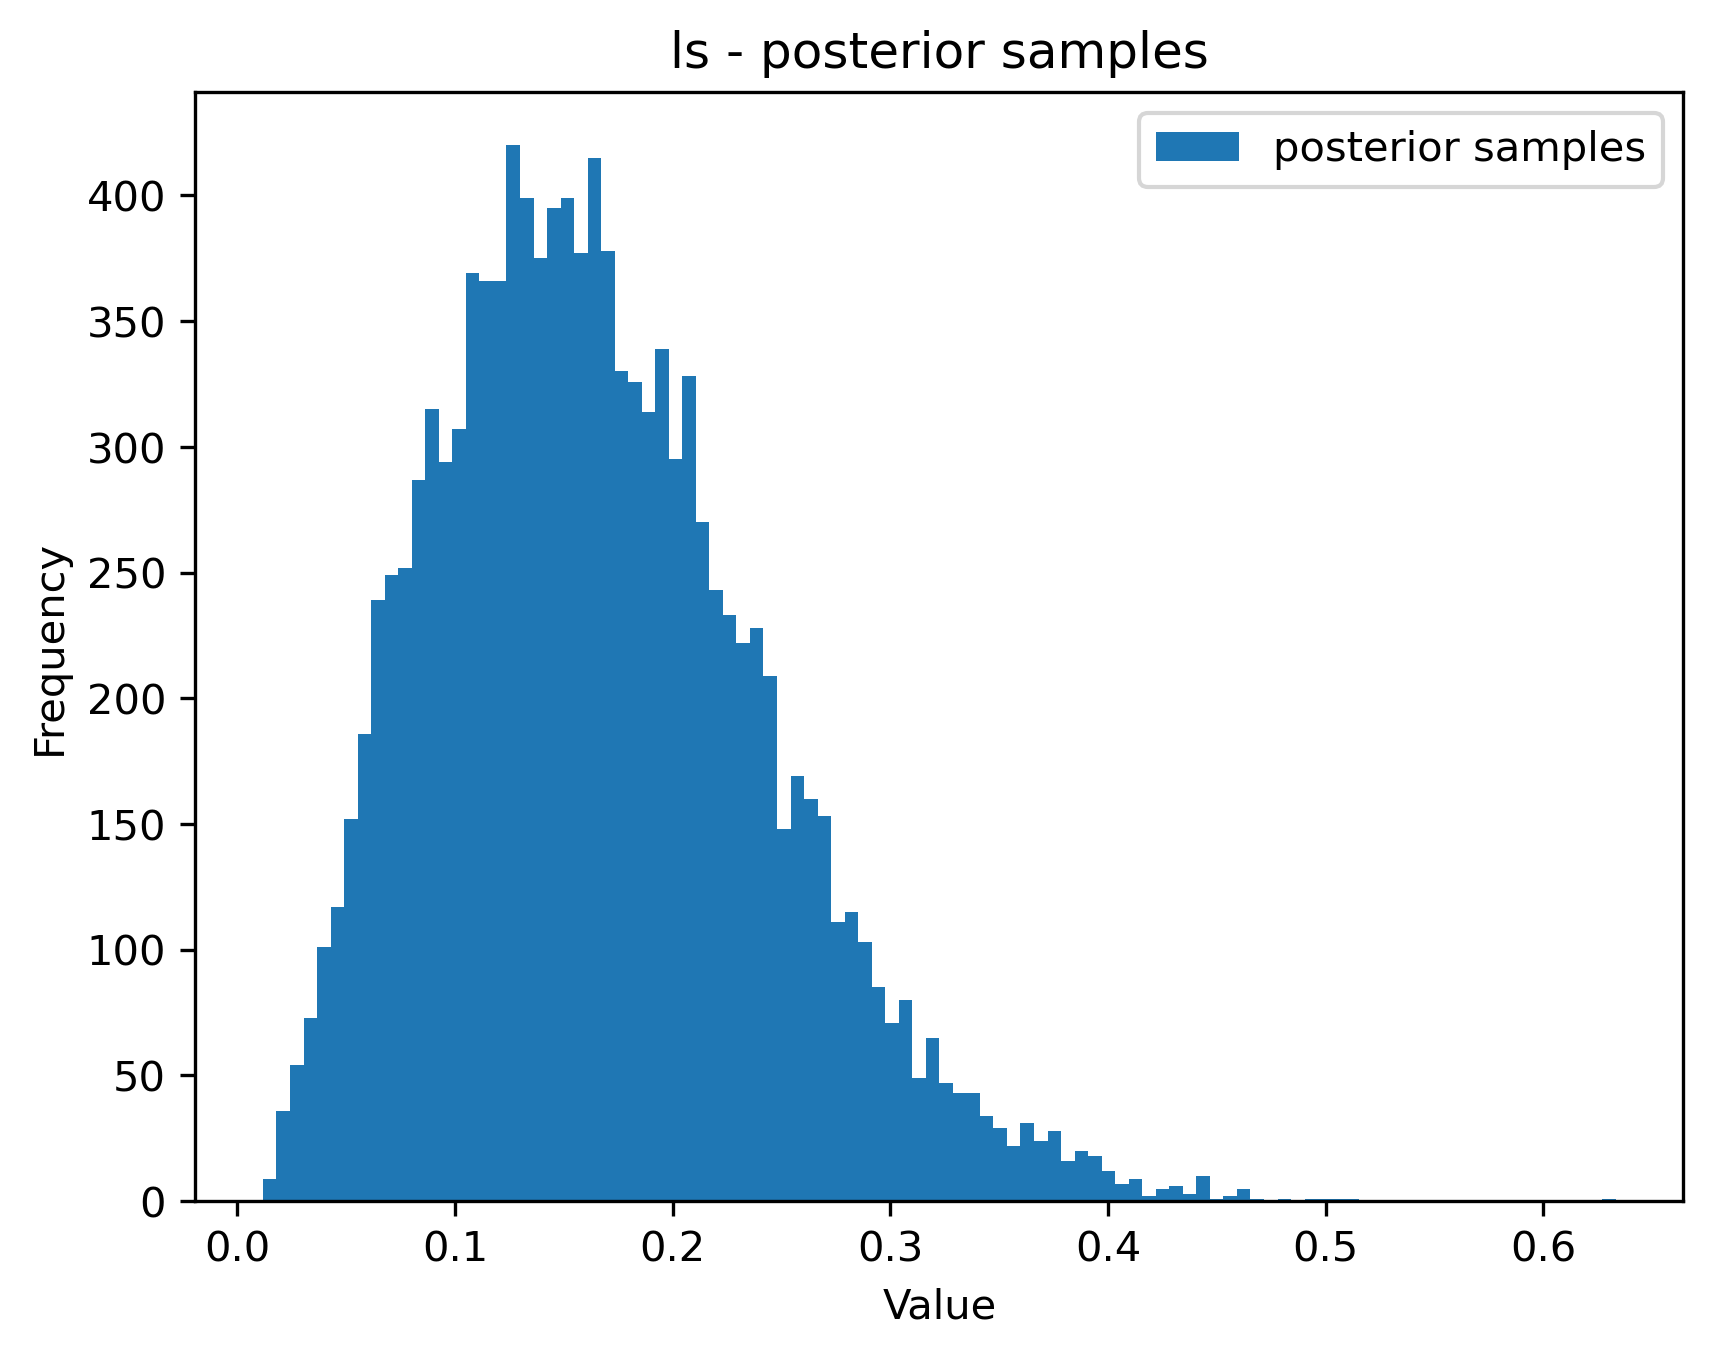

In [116]:
ls_samps = prev_samples['kernel_length']
plt.hist(ls_samps, label = 'posterior samples', bins=100)
# plt.axvline(x = args["true_ls"], color = 'red', label = 'true lengthscale')
plt.title('ls - posterior samples')
plt.legend()
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.savefig(f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+ model_specs + '_ls_posterior_hist.pdf')

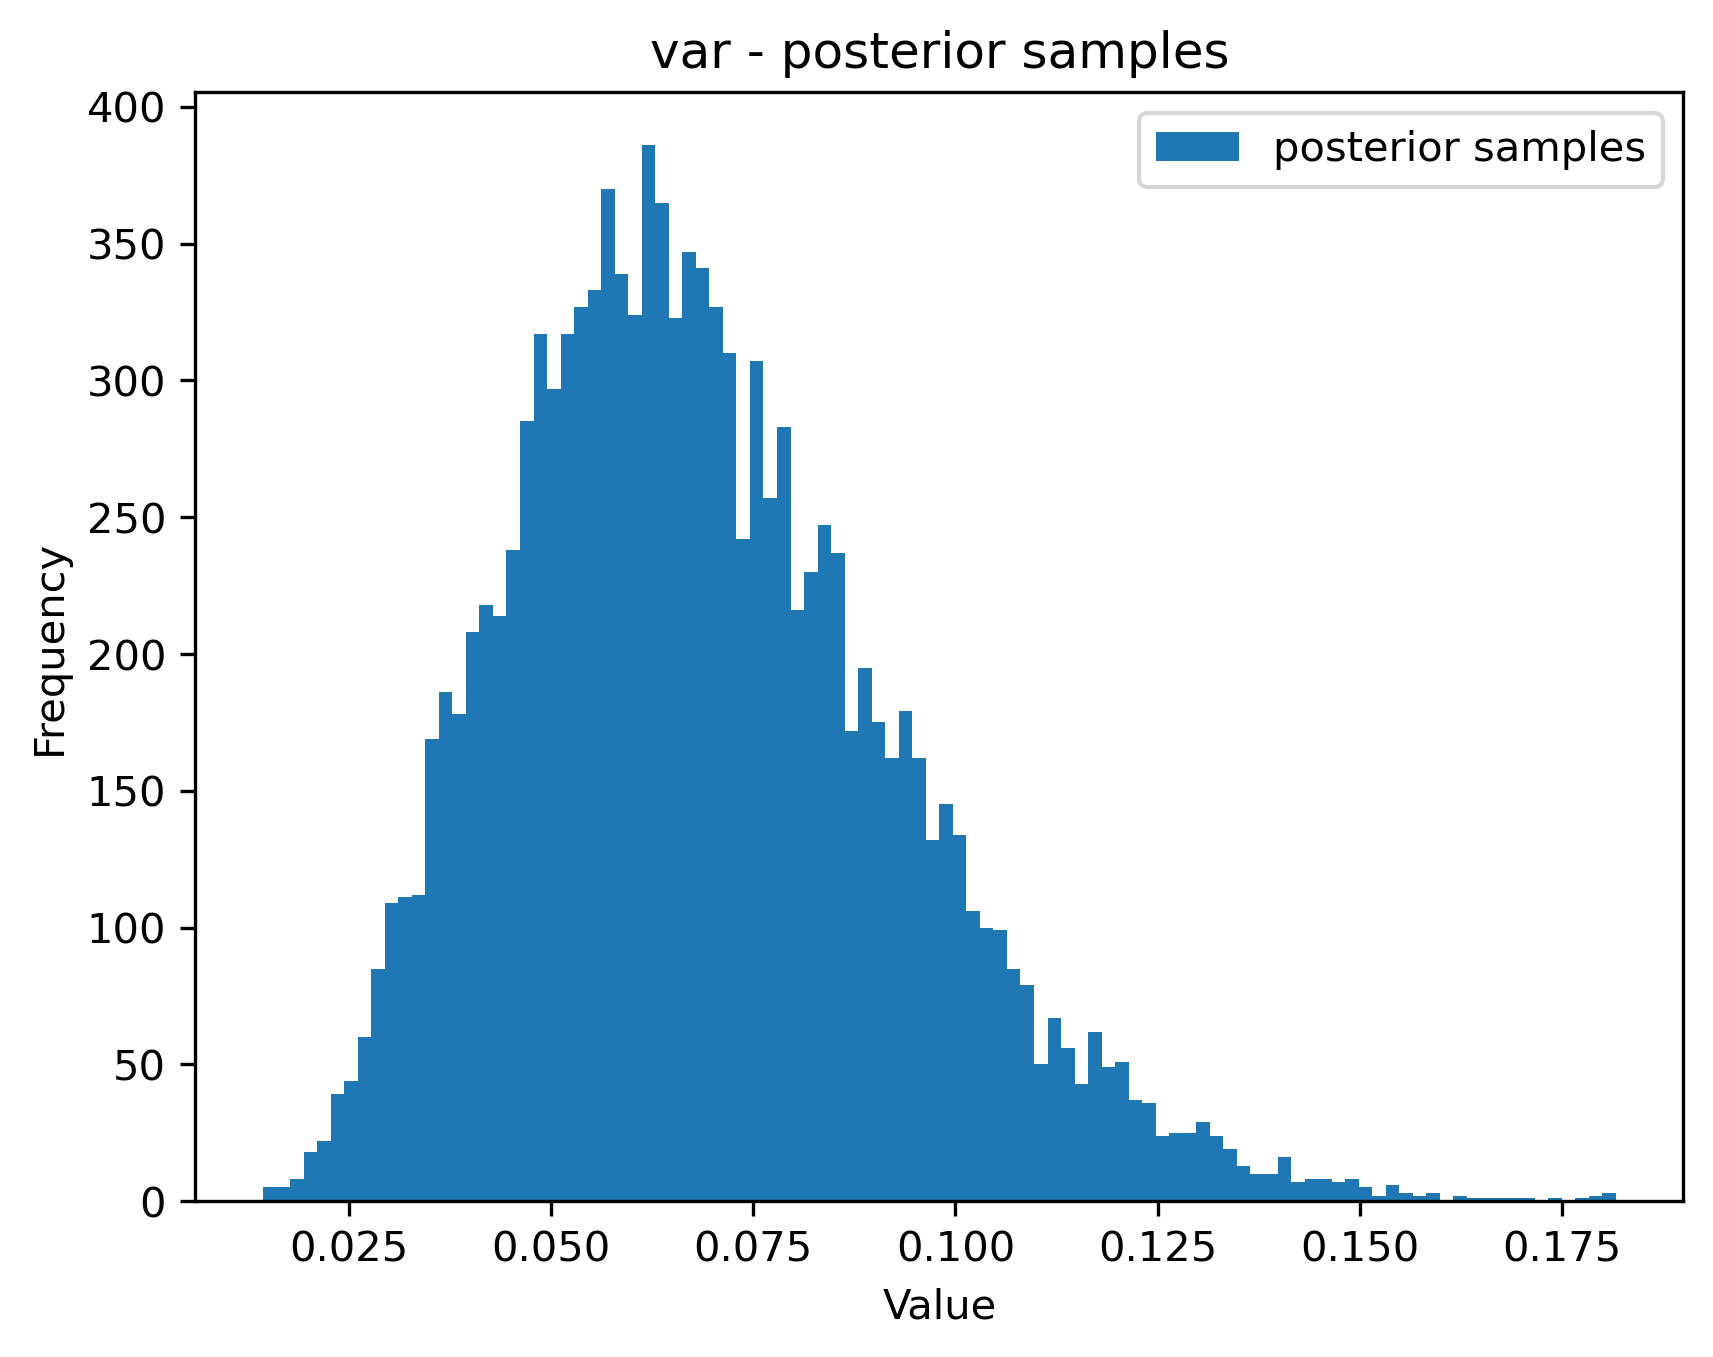

In [117]:
var_samps = prev_samples['kernel_var']
plt.hist(var_samps, label = 'posterior samples', bins=100)
# plt.axvline(x = args["true_ls"], color = 'red', label = 'true lengthscale')
plt.title('var - posterior samples')
plt.legend()
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.ylabel('Frequency')
plt.xlabel('Value')
plt.savefig(f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+ model_specs + '_var_posterior_hist.pdf')

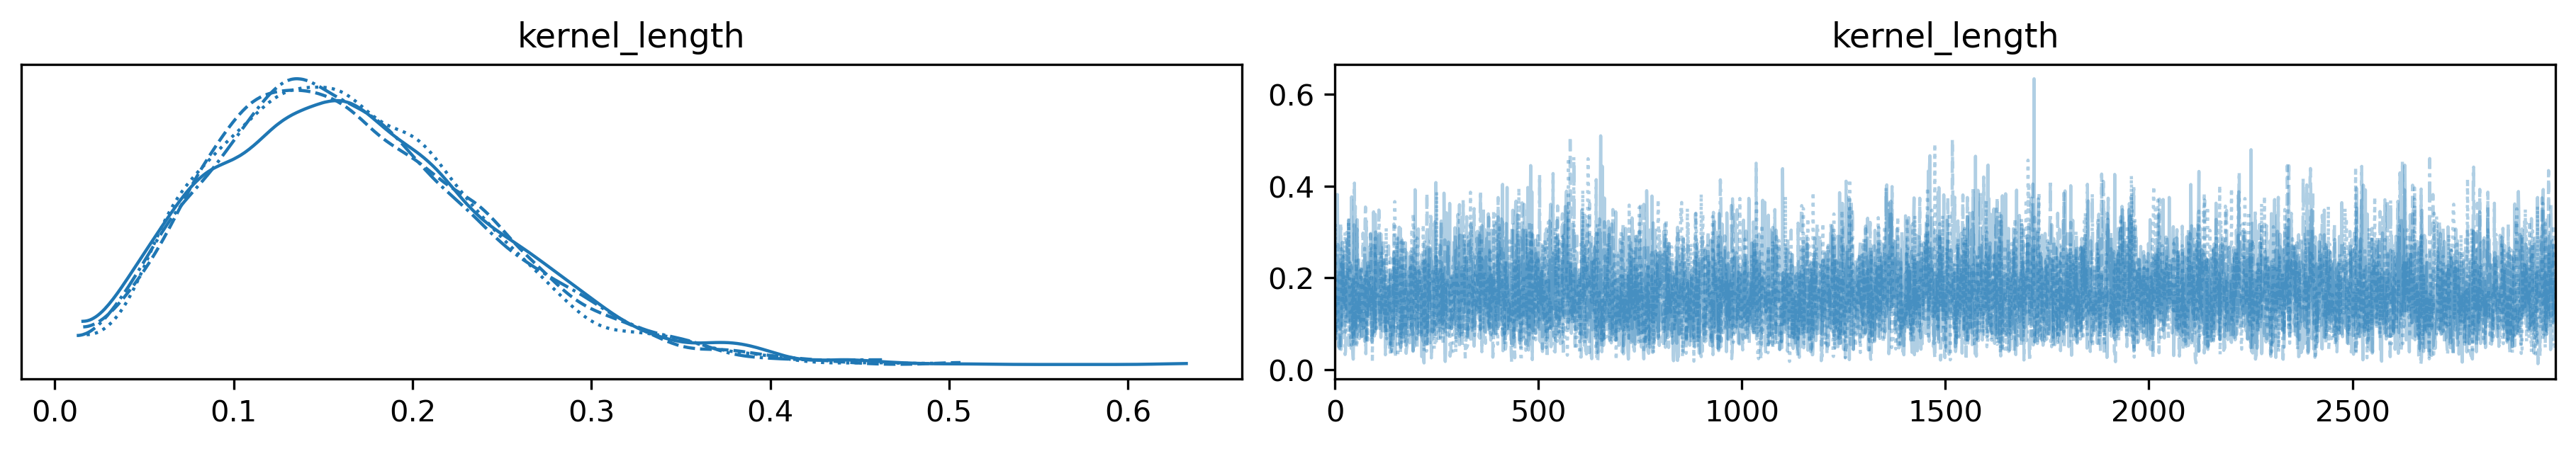

In [118]:
import arviz as az
az_data = az.from_numpyro(mcmc_vae)
az.plot_trace(az_data, var_names=('kernel_length'), filter_vars="like")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig(f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+ model_specs + '_ls_posterior_trace.pdf')

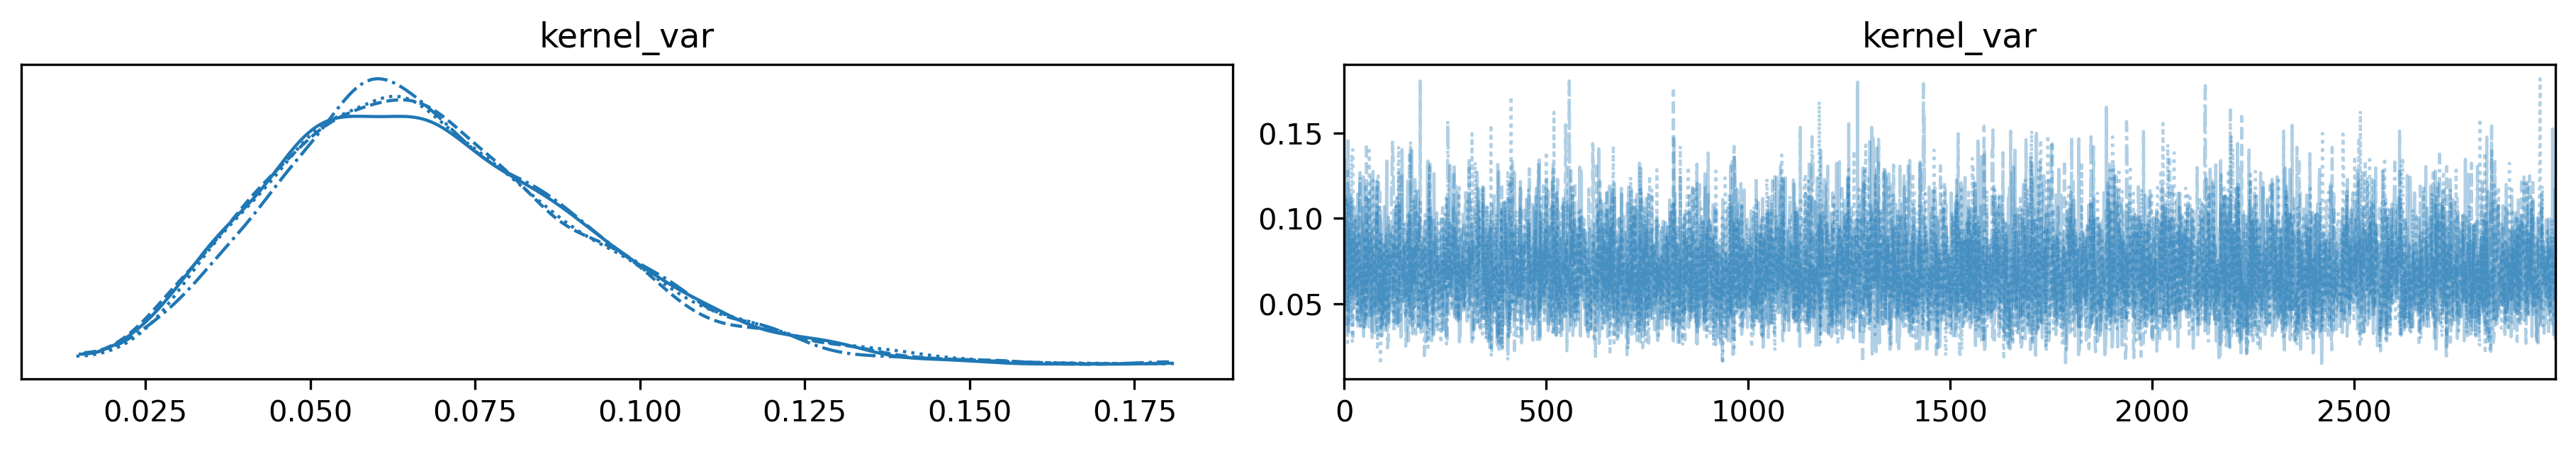

In [119]:
az.plot_trace(az_data, var_names=('kernel_var'), filter_vars="like")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig(f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+ model_specs + '_var_posterior_trace.pdf')

In [120]:
# posterior predictive - 1
prev_posterior_predictive_vae = Predictive(prev_model_vae_aggr, prev_samples)(random.PRNGKey(1), args)

theta_samps_vae_aggr = prev_posterior_predictive_vae['theta']
theta_mean_vae_aggr = theta_samps_vae_aggr.mean(axis=0)
# transpose
theta_mean_vae_aggr = theta_mean_vae_aggr.transpose()
bci_vae_aggr_025 = np.quantile(theta_samps_vae_aggr, 0.025, axis=0)
bci_vae_aggr_975 = np.quantile(theta_samps_vae_aggr, 0.975, axis=0)

s['theta_vae_aggr'] = theta_mean_vae_aggr

theta_observed = s['estimate']
theta_estimated_vae_aggr = s['theta_vae_aggr']

_max = np.max([theta_observed, theta_estimated_vae_aggr])
_min = np.min([theta_observed, theta_estimated_vae_aggr])

In [121]:
theta_samps_vae_aggr.shape
theta_mean_vae_aggr.shape

(125, 1)

In [122]:
bci_vae_aggr_025.shape

(1, 125)

In [123]:
s

area                                           geometry  new  \
0         CHADIZA  POLYGON ((32.57804 -13.93448, 32.75563 -13.982...    0   
1           CHAMA  POLYGON ((32.84411 -10.34120, 32.84790 -10.341...    0   
2         CHASEFU  POLYGON ((32.94614 -12.21183, 32.94578 -12.211...    0   
3         CHAVUMA  POLYGON ((21.99573 -13.46393, 21.99610 -13.439...    0   
4          CHEMBE  POLYGON ((28.89259 -11.50817, 28.87754 -11.520...    0   
..            ...                                                ...  ...   
5        MUCHINGA  POLYGON ((32.16182 -9.05766, 32.19187 -9.09042...    1   
6   NORTH-WESTERN  POLYGON ((24.15075 -11.02947, 24.15078 -11.029...    1   
7        NORTHERN  POLYGON ((30.48184 -8.28098, 30.48544 -8.28408...    1   
8        SOUTHERN  POLYGON ((27.61591 -15.52350, 27.61987 -15.524...    1   
9         WESTERN  POLYGON ((22.03129 -13.73621, 22.03666 -13.738...    1   

       usage  n_obs    y  estimate  theta_vae_aggr  
0   0.592593     44    2  0.054054        0.112058  
1   0.656690    220   13  0.059658        0.062145  
2   0.491268    157    3  0.018292        0.055458  
3   0.438596     56    5  0.089286        0.103174  
4   0.826087     51    0  0.000000        0.070532  
..       ...    ...  ...       ...             ...  
5   0.570684   1436   68  0.047068        0.046095  
6   0.482494   1291   61  0.046977        0.046150  
7   0.592238   1992  108  0.054141        0.053409  
8   0.429838   2851  346  0.121329        0.122168  
9   0.527002   1328  130  0.097580        0.098694  

[125 rows x 8 columns]

In [124]:
_min

0.0

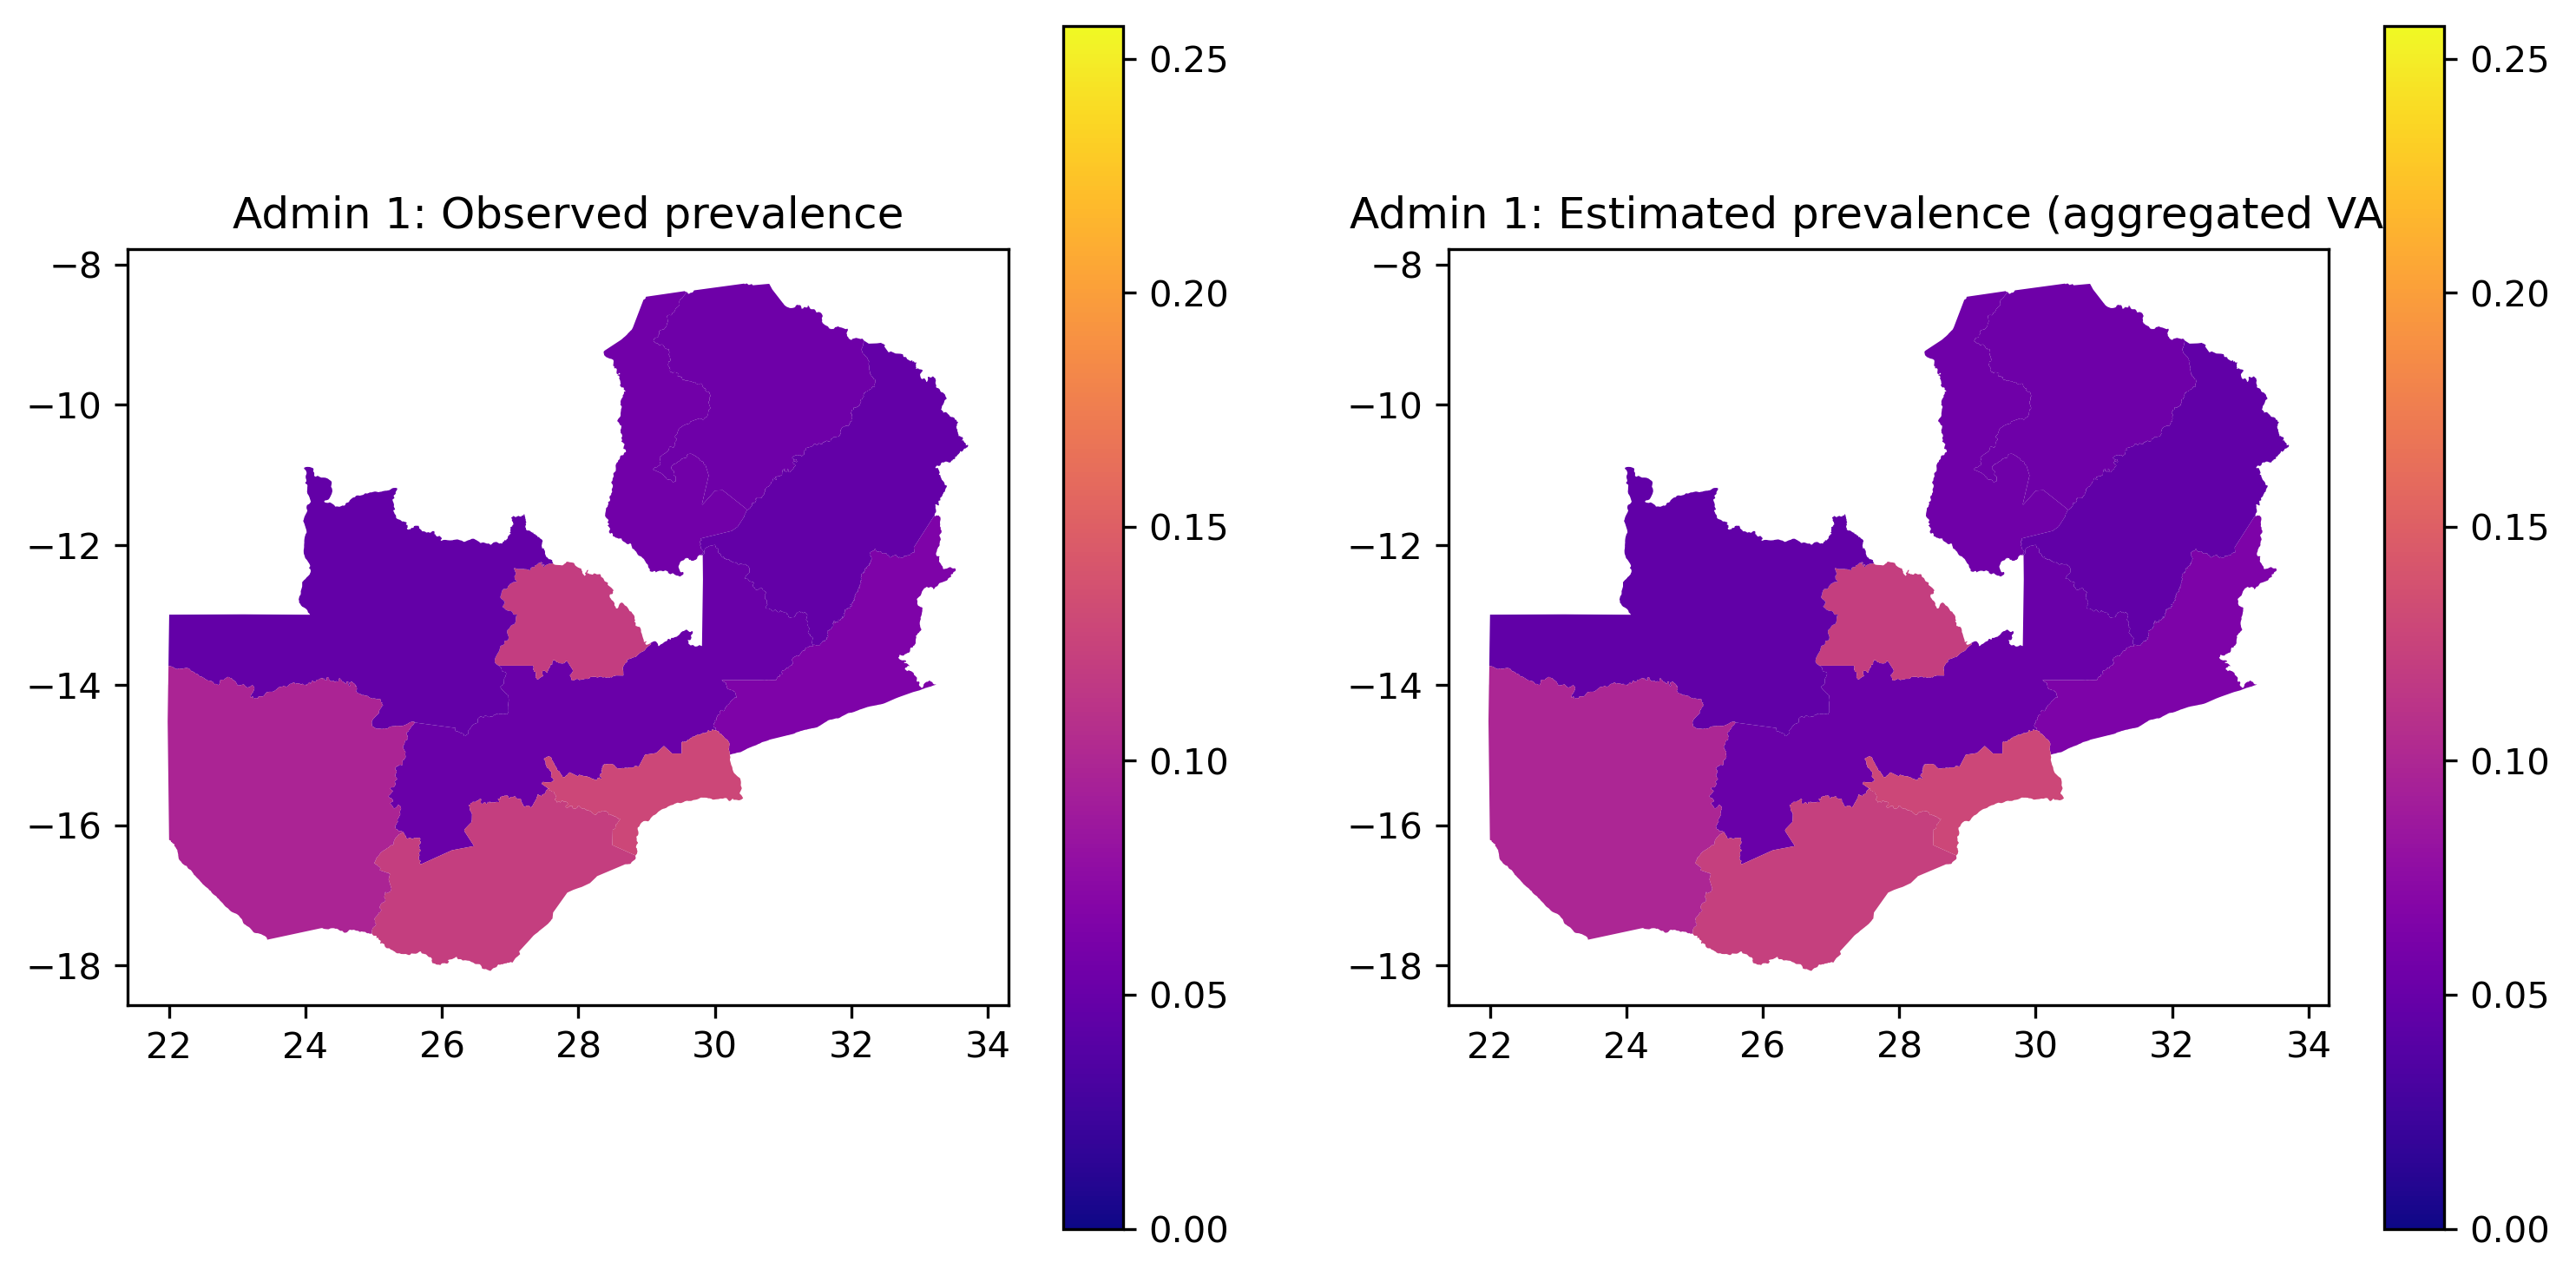

In [125]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

s[n_old:(n_old + n_new)].plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
s[n_old:(n_old + n_new)].plot(column="theta_vae_aggr", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)

ax[0].set_title('Admin 1: Observed prevalence')
ax[1].set_title('Admin 1: Estimated prevalence (aggregated VAE)')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig(f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+ model_specs + '_prev_results_admin1.pdf')

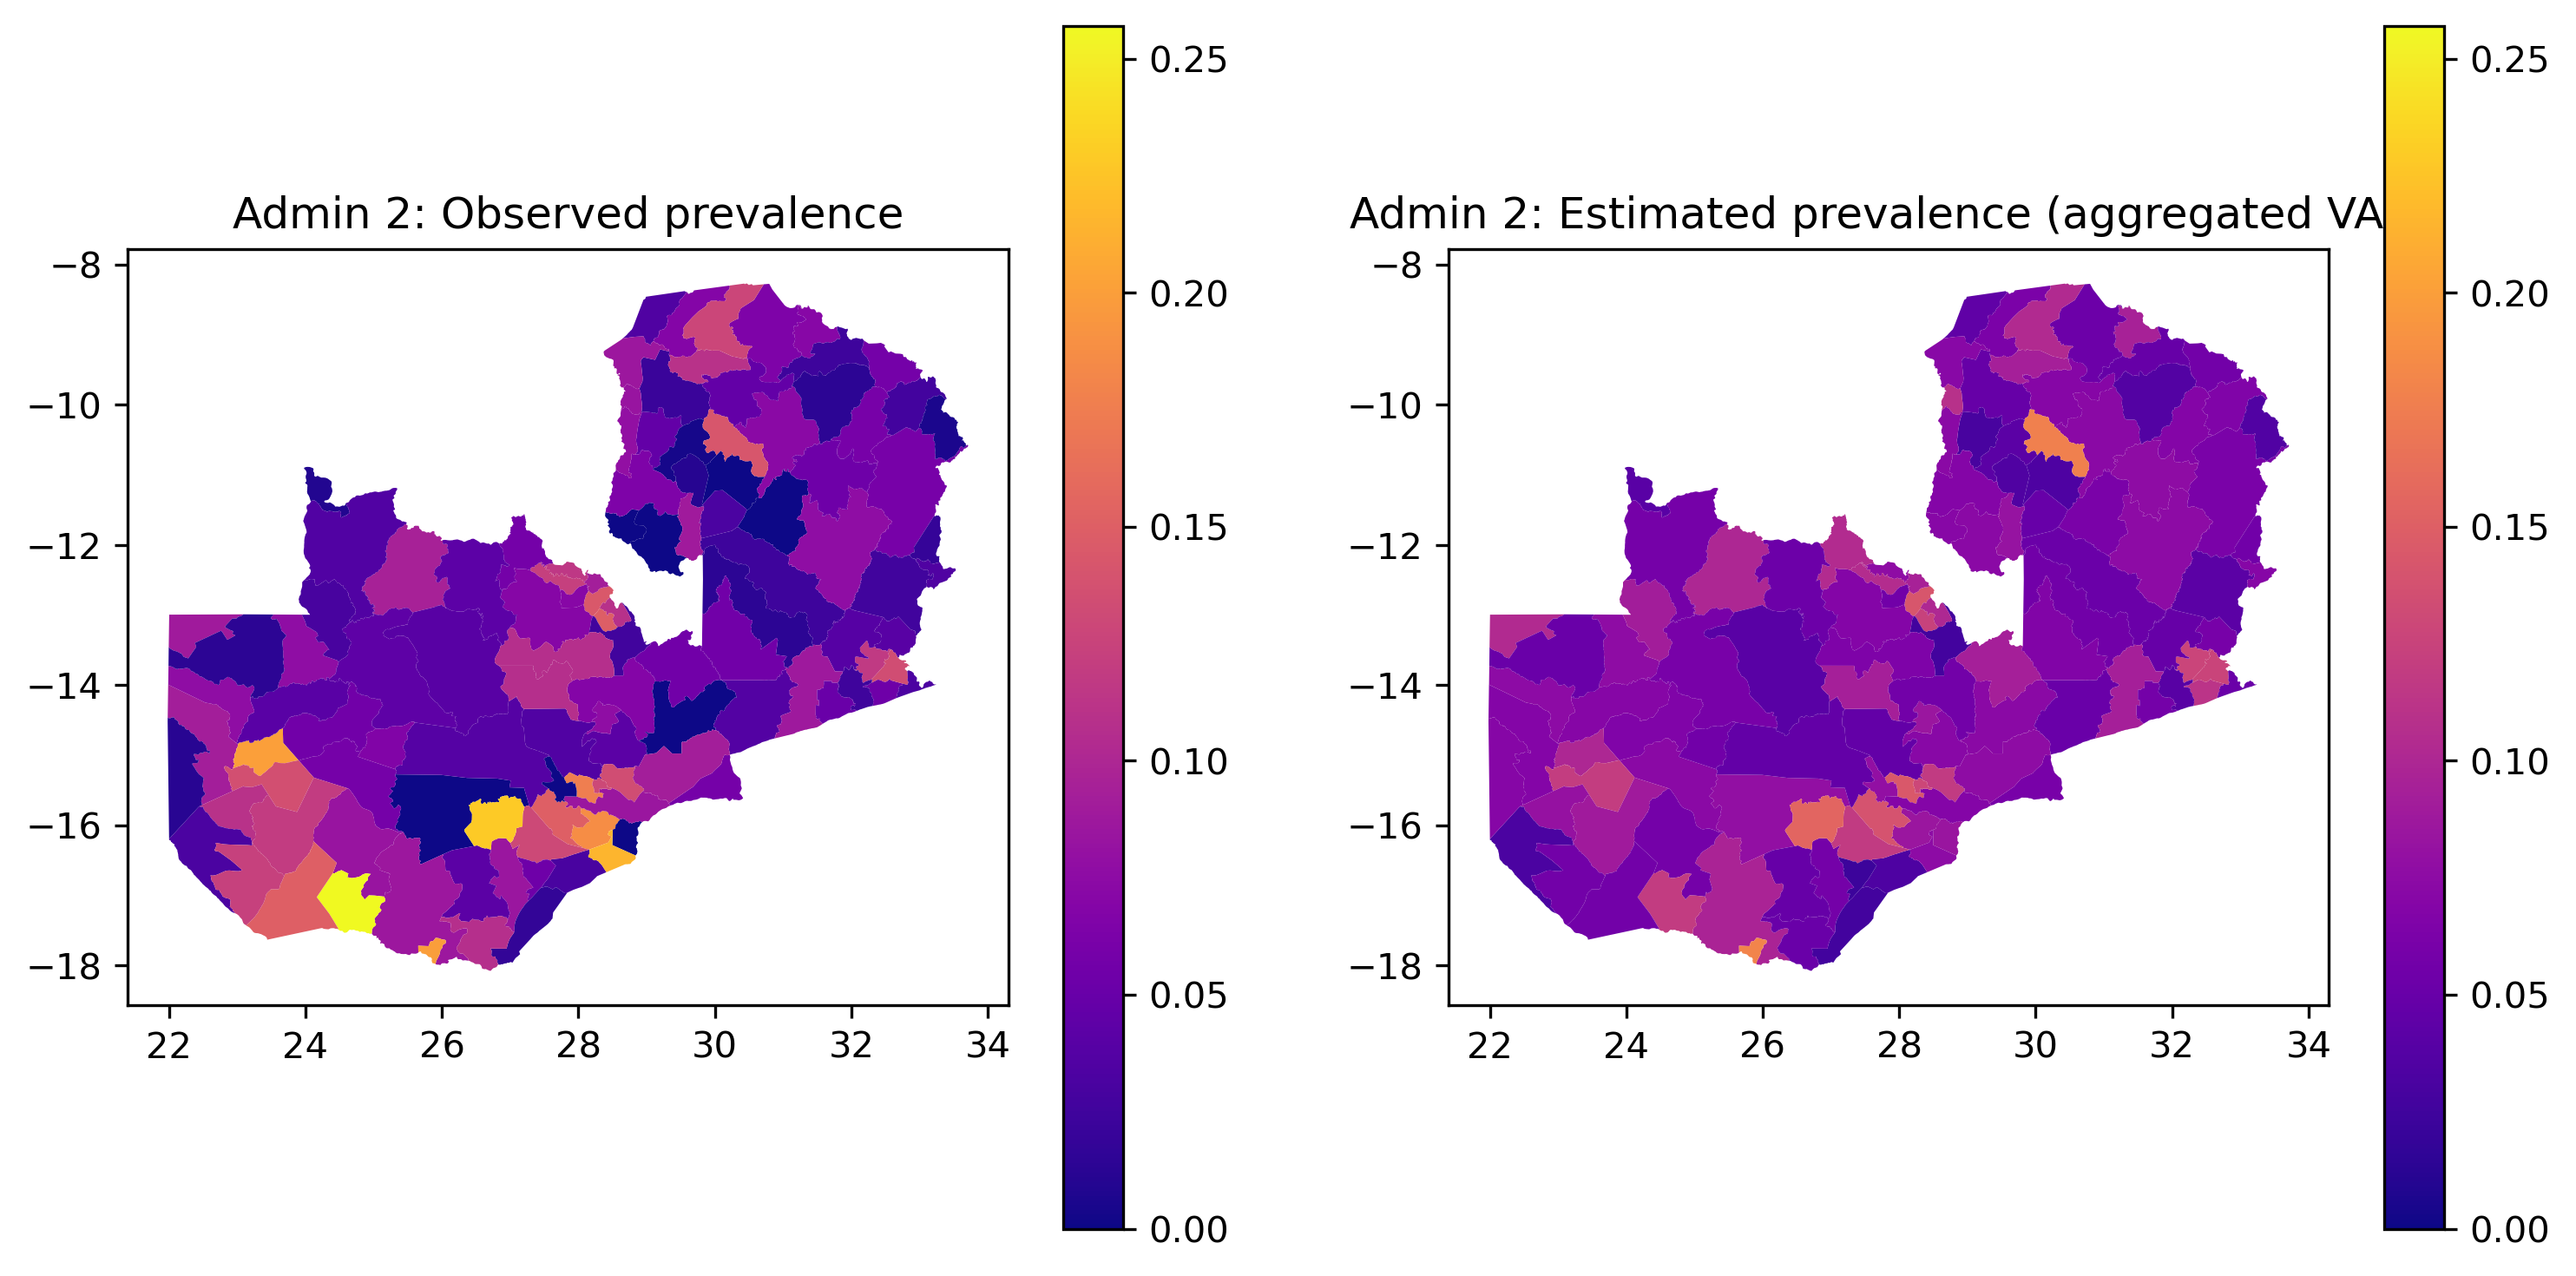

In [126]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

s[0:n_old].plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
s[0:n_old].plot(column="theta_vae_aggr", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)

ax[0].set_title( 'Admin 2: Observed prevalence')
ax[1].set_title( 'Admin 2: Estimated prevalence (aggregated VAE)')


plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig(f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+ model_specs + '_prev_results_admin2.pdf')

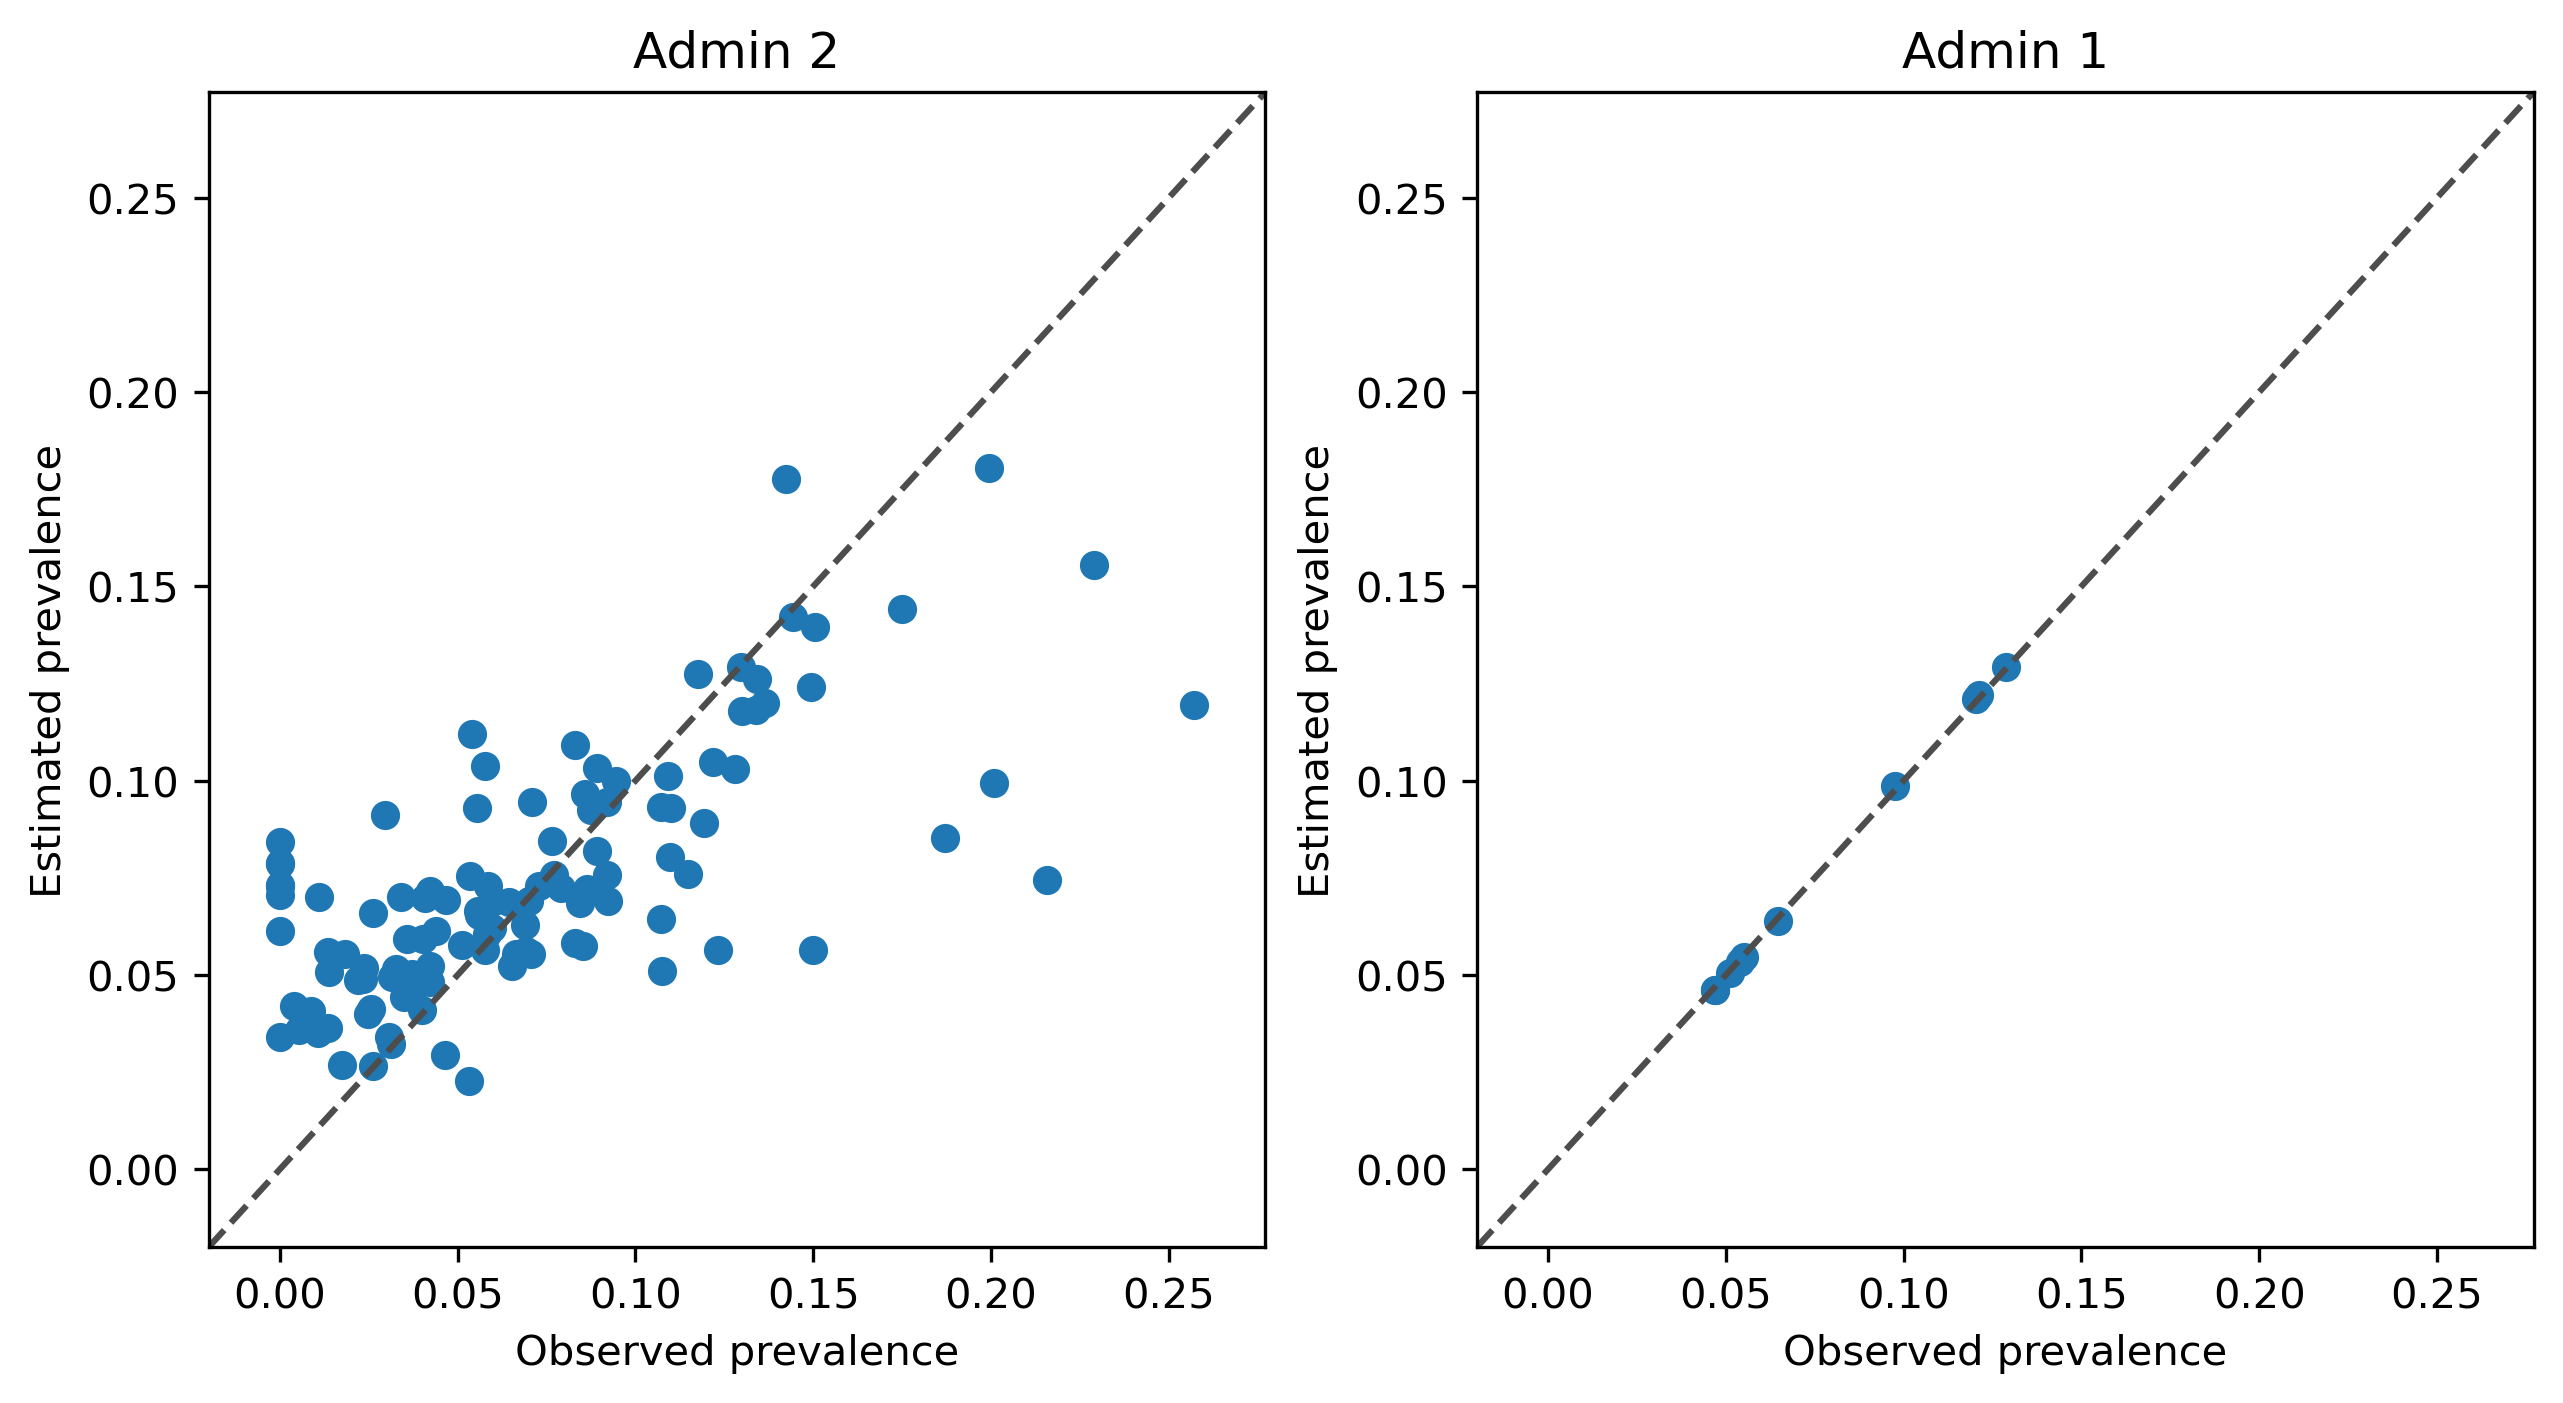

In [127]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].scatter(s[0:n_old].estimate, s[0:n_old].theta_vae_aggr)
ax[0].set_ylim(_min-0.02, _max+0.02)
ax[0].set_xlim(_min-0.02, _max+0.02)
ax[0].axline((1, 1), slope=1, ls="--", c=".3")
ax[0].set_xlabel("Observed prevalence")
ax[0].set_ylabel("Estimated prevalence")
ax[0].set_title("Admin 2")

ax[1].scatter(s[n_old:(n_old + n_new)].estimate, s[n_old:(n_old + n_new)].theta_vae_aggr)
ax[1].set_ylim(_min-0.02, _max+0.02)
ax[1].set_xlim(_min-0.02, _max+0.02)
ax[1].axline((1, 1), slope=1, ls="--", c=".3")
ax[1].set_xlabel("Observed prevalence")
ax[1].set_ylabel("Estimated prevalence")
ax[1].set_title("Admin 1")

#plt.rcParams['figure.dpi'] = 300
#plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/est_obs_vae.pdf')

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig(f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+ model_specs + '_prev_results_scatterplot.pdf')

In [128]:
# Example observations and predictions
observations = s.estimate
predictions = s.theta_vae_aggr

# Pearson correlation coefficient
pearson_corr, _ = pearsonr(observations, predictions)
print(f'Pearson correlation coefficient: {pearson_corr:.4f}')

# Spearman correlation coefficient
spearman_corr, _ = spearmanr(observations, predictions)
print(f'Spearman correlation coefficient: {spearman_corr:.4f}')

# Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(observations, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')

# Mean Absolute Error (MAE)
mae = mean_absolute_error(observations, predictions)
print(f'Mean Absolute Error (MAE): {mae:.4f}')

# Save results to a text file
with open(f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE' + model_specs + '_prev_metrics.txt', 'w') as file:
    file.write(f'Pearson correlation coefficient: {pearson_corr:.4f}\n')
    file.write(f'Spearman correlation coefficient: {spearman_corr:.4f}\n')
    file.write(f'Root Mean Squared Error (RMSE): {rmse:.4f}\n')
    file.write(f'Mean Absolute Error (MAE): {mae:.4f}\n')

# Generate LaTeX table
latex_table = f"""
\\documentclass{{article}}
\\usepackage{{booktabs}}

\\begin{{document}}

\\begin{{table}}[h!]
\\centering
\\begin{{tabular}}{{ll}}
\\toprule
Metric & Value \\\\
\\midrule
Pearson correlation coefficient & {pearson_corr:.4f} \\\\
Spearman correlation coefficient & {spearman_corr:.4f} \\\\
Root Mean Squared Error (RMSE) & {rmse:.4f} \\\\
Mean Absolute Error (MAE) & {mae:.4f} \\\\
\\bottomrule
\\end{{tabular}}
\\caption{{Performance Metrics}}
\\label{{tab:metrics}}
\\end{{table}}

\\end{{document}}
"""

latex_file = f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE' + model_specs + '_latex_metrics.tex'
# Save LaTeX table to a .tex file
with open(latex_file, 'w') as file:
    file.write(latex_table)

    
# Save metrics to a pickle file
pickle_file = f'figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE' + model_specs + '_prev_metrics.pkl'
metrics = {
    'pearson_corr': pearson_corr,
    'spearman_corr': spearman_corr,
    'rmse': rmse,
    'mae': mae
}
with open(pickle_file, 'wb') as file:
    pickle.dump(metrics, file)

# Load and verify the LaTeX table
with open(latex_file, 'r') as file:
    latex_data = file.read()
    print("\nLoaded from LaTeX file:")
    print(latex_data)

# Load and verify the pickle file results
with open(pickle_file, 'rb') as file:
    loaded_metrics = pickle.load(file)
    print("\nLoaded from pickle file:")
    print(loaded_metrics)

# Check if loaded metrics match the original metrics
assert np.isclose(loaded_metrics['pearson_corr'], pearson_corr), "Pearson correlation coefficient does not match."
assert np.isclose(loaded_metrics['spearman_corr'], spearman_corr), "Spearman correlation coefficient does not match."
assert np.isclose(loaded_metrics['rmse'], rmse), "RMSE does not match."
assert np.isclose(loaded_metrics['mae'], mae), "MAE does not match."

print("All metrics loaded correctly from the pickle file.")


Pearson correlation coefficient: 0.7149
Spearman correlation coefficient: 0.6934
Root Mean Squared Error (RMSE): 0.0372
Mean Absolute Error (MAE): 0.0251

Loaded from LaTeX file:

\documentclass{article}
\usepackage{booktabs}

\begin{document}

\begin{table}[h!]
\centering
\begin{tabular}{ll}
\toprule
Metric & Value \\
\midrule
Pearson correlation coefficient & 0.7149 \\
Spearman correlation coefficient & 0.6934 \\
Root Mean Squared Error (RMSE) & 0.0372 \\
Mean Absolute Error (MAE) & 0.0251 \\
\bottomrule
\end{tabular}
\caption{Performance Metrics}
\label{tab:metrics}
\end{table}

\end{document}


Loaded from pickle file:
{'pearson_corr': 0.7149200195718024, 'spearman_corr': 0.6934443211697144, 'rmse': 0.03720859882656935, 'mae': 0.025129638224459346}
All metrics loaded correctly from the pickle file.


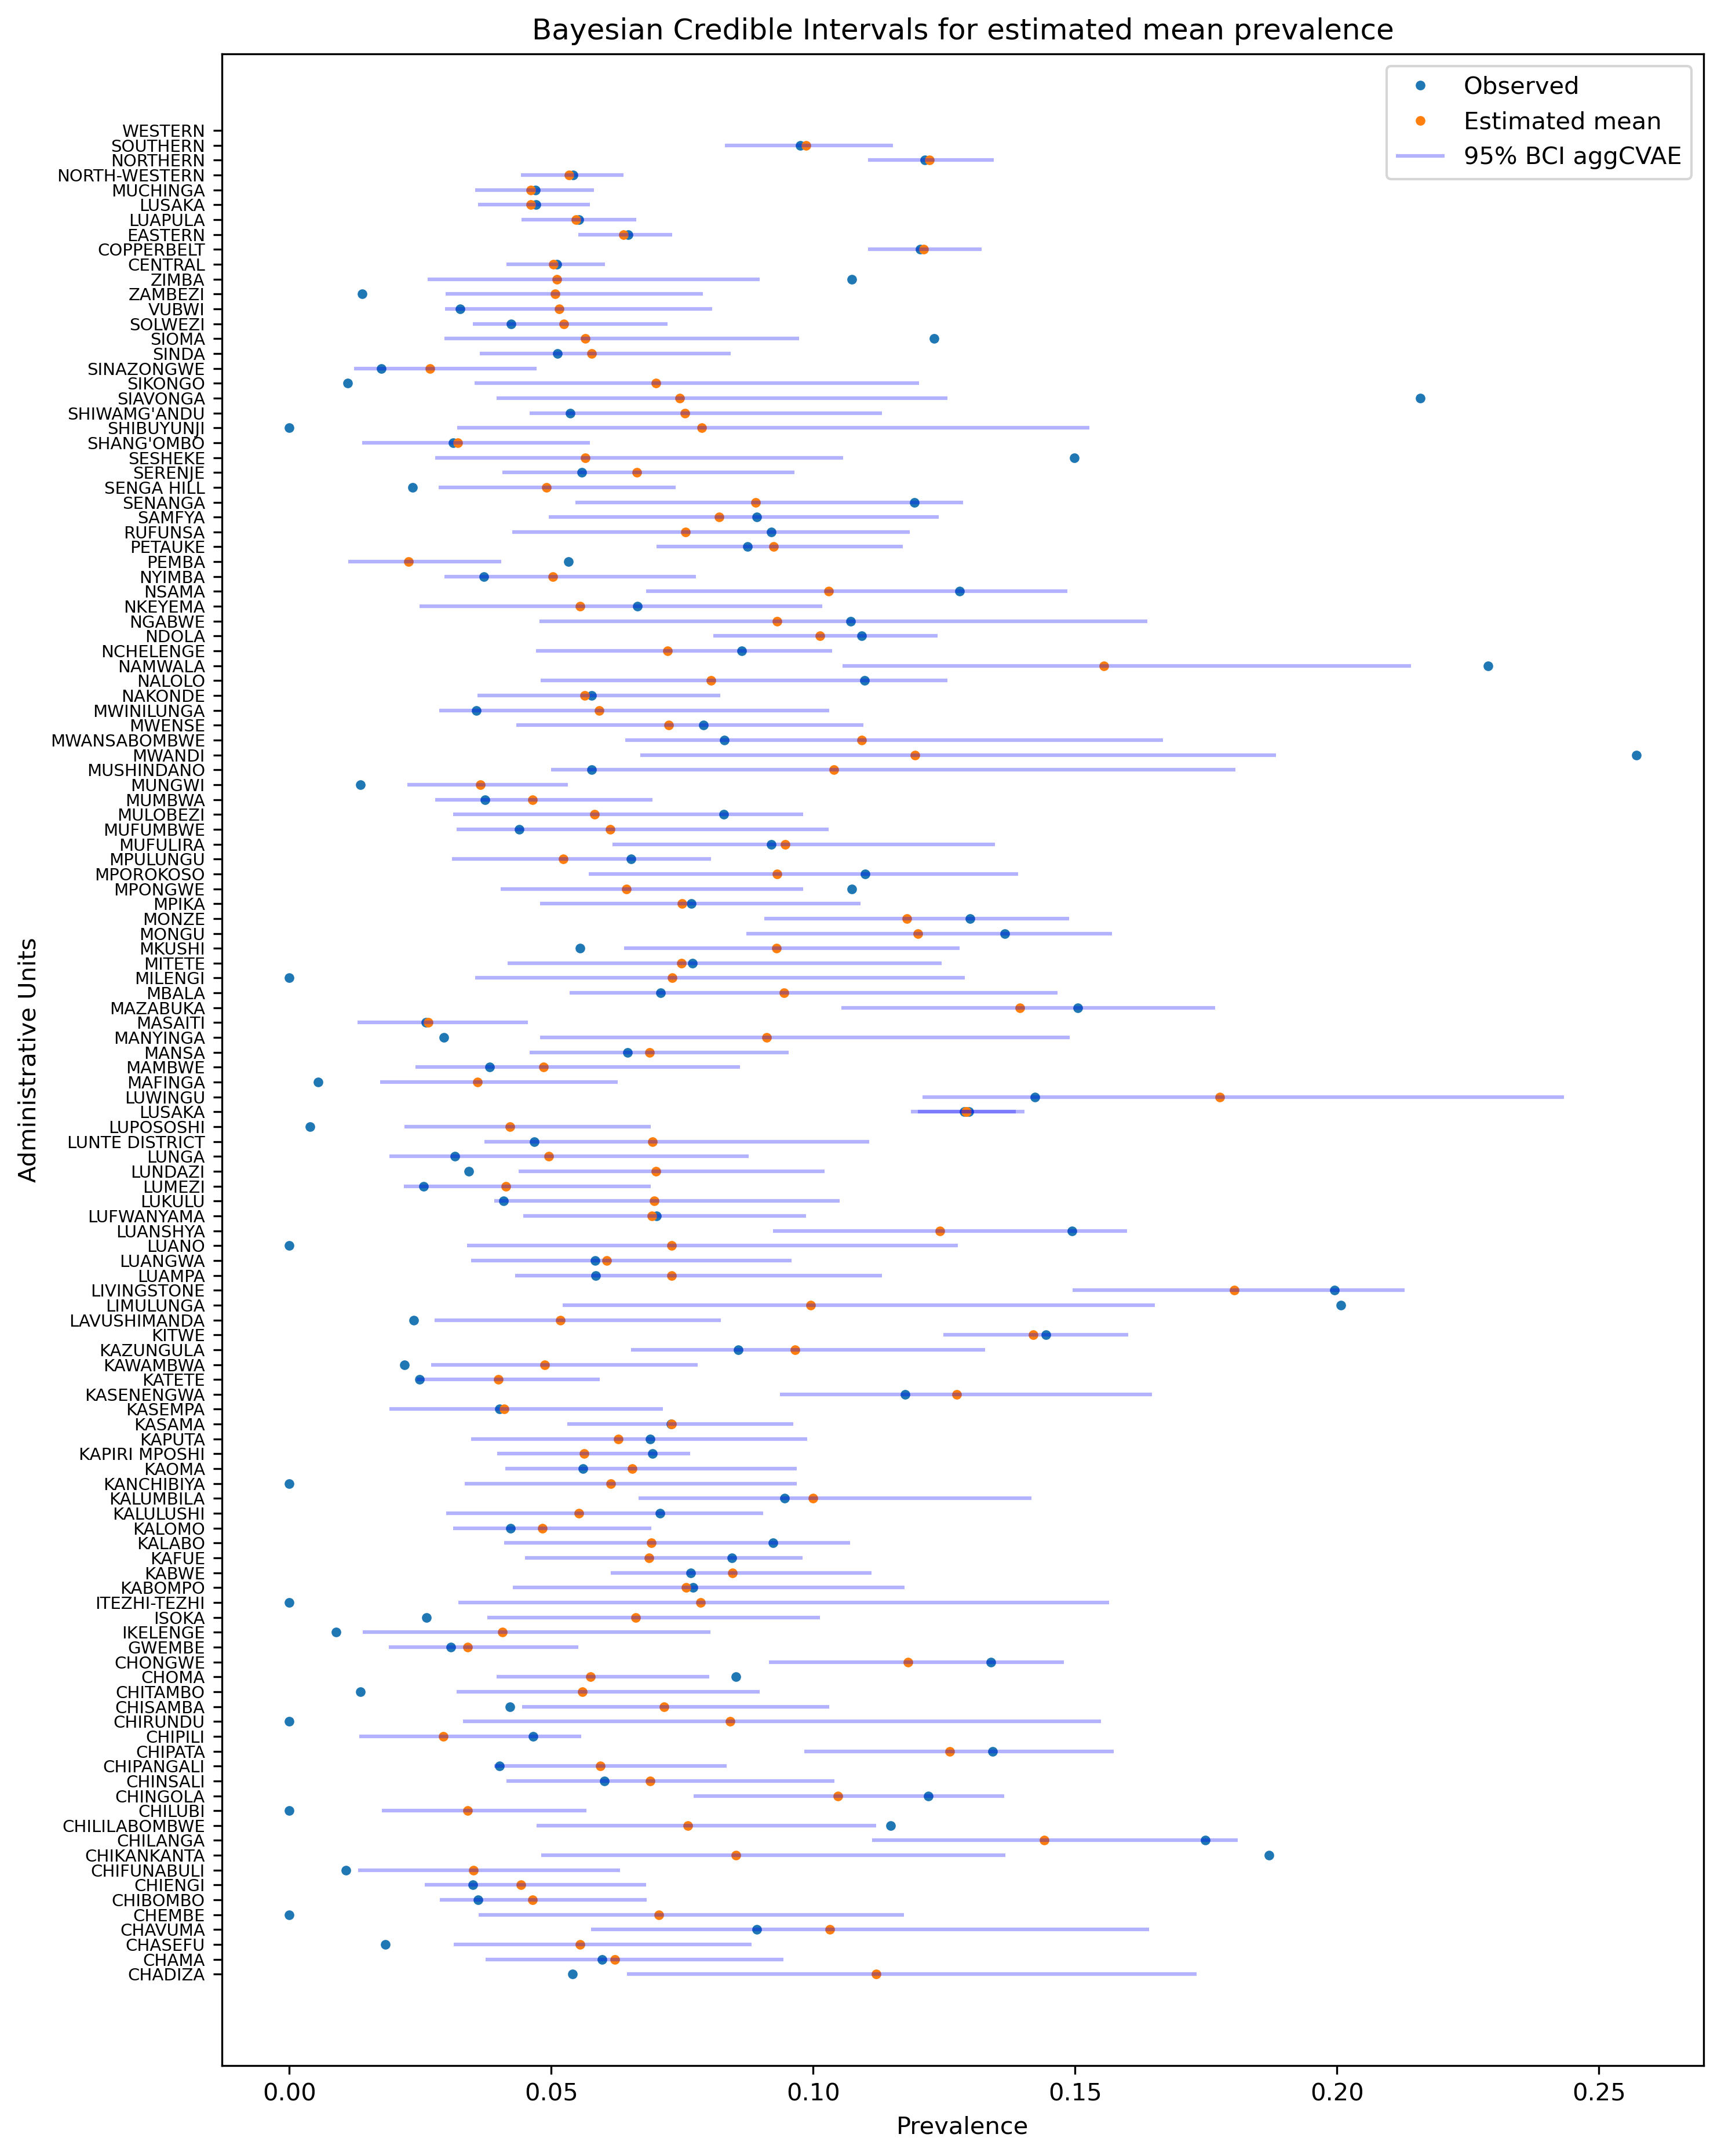

In [129]:
# BCI intervals 

x_axis = s['area']


# Calculate reasonable figure height based on the number of administrative units
fig_height = max(len(x_axis) * 0.1, 8)  # Adjust 0.4 as needed to fit the labels comfortably


# Plot with flipped axes
plt.figure(figsize=(10, fig_height))  # Increase the height of the figure
plt.plot(s["estimate"], x_axis, ".", label="Observed")
plt.plot(theta_mean_vae_aggr, x_axis, ".", label="Estimated mean") 
plt.hlines(x_axis, xmin=bci_vae_aggr_025, xmax=bci_vae_aggr_975, colors="blue", alpha=0.3, label="95% BCI aggCVAE")  # Flipped axes           # Flipped axes
plt.legend()
plt.xlabel('Prevalence')
plt.ylabel('Administrative Units')
plt.title(f'Bayesian Credible Intervals for estimated mean prevalence')

# Adjust y-axis ticks and label spacing
plt.yticks(np.arange(len(x_axis)), x_axis, fontsize=7)  # Customize fontsize and spacing

# Save plot
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.tight_layout()
plt.savefig('figures/ZMB2018_aggCVAE'+model_specs+'/ZMB2018_aggCVAE'+model_specs+'_BCI_intervals_estimated_prev.pdf')
plt.show()

In [130]:
def prev_model_gp_aggr(args, y=None):

    n_obs = args['n_obs']
    x = args["x"]
    gp_kernel=args["gp_kernel"]
    jitter = args["jitter"]
    M_old = args["M_old"]
    M_new = args["M_new"]

    # random effect - aggregated GP
    length = numpyro.sample("kernel_length", dist.InverseGamma(3,3))
    var = numpyro.sample("kernel_var", dist.HalfNormal(0.05))
    k = gp_kernel(x, x, var, length, jitter)
    f = numpyro.sample("f", dist.MultivariateNormal(loc=jnp.zeros(x.shape[0]), covariance_matrix=k))

    # aggregate f into gp_aggr according to indexing of (point in polygon)
    gp_aggr_old = numpyro.deterministic('gp_aggr_old', M_g(M_old, f))
    gp_aggr_new = numpyro.deterministic('gp_aggr_new', M_g(M_new, f))
    gp_aggr = numpyro.deterministic('gp_aggr', jnp.concatenate([gp_aggr_old, gp_aggr_new]))

    # fixed effects
    b0 = numpyro.sample('b0', dist.Normal(0, 1))

    # linear predictor
    lp = b0 + gp_aggr
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(lp))

    numpyro.sample("obs", dist.BinomialLogits(total_count = n_obs, logits=lp), obs=y)

In [131]:
# Load
#with open('MCMCs/prev_model_gp_aggr_joint_500iter_lsIG3_3', 'rb') as file:
#    mcmc_gp_aggr = pickle.load(file)

#prev_samples_aggr = mcmc_gp_aggr.get_samples()
#mcmc_gp_aggr.print_summary(exclude_deterministic=False)

In [132]:
# posterior predictive
prev_posterior_predictive = Predictive(prev_model_gp_aggr, prev_samples_aggr)(random.PRNGKey(1), args)

theta_samps_gp = prev_posterior_predictive['theta']
theta_mean_gp = theta_samps_gp.mean(axis=0)
bci_gp_25 = np.quantile(theta_samps_gp, 0.25, axis=0)
bci_gp_75 = np.quantile(theta_samps_gp, 0.75, axis=0)

s['theta_gp'] = theta_mean_gp
theta_estimated_gp = s['theta_gp']

NameError: name 'prev_samples_aggr' is not defined

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].scatter(s[0:n_old].theta_gp, s[0:n_old].theta_vae_aggr)
ax[0].set_ylim(_min-0.02, _max+0.02)
ax[0].set_xlim(_min-0.02, _max+0.02)
ax[0].axline((1, 1), slope=1, ls="--", c=".3")
ax[0].set_xlabel("estimated prev (aggGP)")
ax[0].set_ylabel("estimated prev (aggVAE)")
ax[0].set_title("before 2010")

ax[1].scatter(s[n_old:(n_old + n_new)].theta_gp, s[n_old:(n_old + n_new)].theta_vae_aggr)
ax[1].set_ylim(_min-0.02, _max+0.02)
ax[1].set_xlim(_min-0.02, _max+0.02)
ax[1].axline((1, 1), slope=1, ls="--", c=".3")
ax[1].set_xlabel("estimated prev (aggGP)")
ax[1].set_ylabel("estimated prev (aggVAE)")
ax[1].set_title("after 2010")

In [ ]:
# 1
_max = np.max([s['estimate'], s['theta_gp'], s['theta_vae_aggr']])
_min = np.min([s['estimate'], s['theta_gp'], s['theta_vae_aggr']])

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))
s[0:n_old].plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
s[0:n_old].plot(column="theta_gp", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)
s[0:n_old].plot(column="theta_vae_aggr", ax=ax[2], legend=True, cmap='plasma', vmin=_min, vmax =_max)
ax[0].set_title( 'Before: Observed prev')
ax[1].set_title( 'Before: Estimated prev (aggGP)')
ax[2].set_title( 'Before: Estimated prev (aggVAE)')

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18,6))
s[n_old:(n_old+n_new)].plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
s[n_old:(n_old+n_new)].plot(column="theta_gp", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)
s[n_old:(n_old+n_new)].plot(column="theta_vae_aggr", ax=ax[2], legend=True, cmap='plasma', vmin=_min, vmax =_max)
ax[0].set_title( 'After: Observed prev')
ax[1].set_title( 'After: Estimated prev (aggGP)')
ax[2].set_title( 'After: Estimated prev (aggVAE)')